# **Installs**

In [ ]:
!pip install photutils --quiet
!pip install webbpsf --quiet

In [ ]:
!wget https://stsci.box.com/shared/static/qxpiaxsjwo15ml6m4pkhtk36c9jgj70k.gz -O webbpsf-data-1.2.1.tar.gz

In [ ]:
!tar -xf webbpsf-data-1.2.1.tar.gz

In [ ]:
!rm webbpsf-data-1.2.1.tar.gz

In [ ]:
!pip uninstall numexpr --quiet -y

# **Imports**

In [1]:
from gloess import gloess

In [2]:
import sys
import time
import json
import numpy as np
import pandas as pd
import glob as glob
import urllib.request
import tarfile
import os
import itertools

from scipy.ndimage import gaussian_filter
from scipy.interpolate import interp1d

from astropy.io import fits
from astropy.visualization import simple_norm
from astropy.nddata import NDData
from astropy.wcs import WCS
from astropy.modeling import models, fitting, custom_model
from astropy.modeling.fitting import LevMarLSQFitter
from astropy.table import Table, QTable, vstack
from astropy.coordinates import SkyCoord, match_coordinates_sky, angular_separation
from astropy import units as u
from astropy.stats import SigmaClip, sigma_clipped_stats, gaussian_fwhm_to_sigma
from astropy.convolution import Gaussian2DKernel, convolve_fft
from astropy.nddata.utils import Cutout2D

import photutils as phot
from photutils.background import MMMBackground, MADStdBackgroundRMS, Background2D, LocalBackground
from photutils.detection import DAOStarFinder
from photutils.psf import EPSFBuilder, GriddedPSFModel
from photutils.psf import SourceGrouper, extract_stars, IterativePSFPhotometry, DAOPhotPSFPhotometry

from photutils.aperture import CircularAperture, CircularAnnulus, aperture_photometry, EllipticalAperture

from scipy.interpolate import interp1d
from scipy.stats import gaussian_kde
from scipy.ndimage import sobel, gaussian_filter, convolve
from scipy.signal import savgol_filter
from astropy.stats.biweight import biweight_location, biweight_midvariance,biweight_scale
from matplotlib.colors import LinearSegmentedColormap
from scipy.signal import find_peaks
from spectral_cube import SpectralCube
from astropy.cosmology import FlatLambdaCDM
from astropy.visualization.wcsaxes import SphericalCircle

In [3]:
from reproject import reproject_exact
from reproject.mosaicking import find_optimal_celestial_wcs

In [4]:
os.environ['WEBBPSF_PATH'] = '../data/webbpsf-data'

In [5]:
%matplotlib inline
from matplotlib import style, pyplot as plt
import matplotlib.patches as patches
import matplotlib.ticker as ticker
import matplotlib.colors as col
from matplotlib.colors import ListedColormap
from matplotlib.patches import Circle
import seaborn as sb
import matplotlib.gridspec as gridspec
sb.set_style('white')
from matplotlib.ticker import (MultipleLocator, AutoLocator, AutoMinorLocator)
from matplotlib.patches import Rectangle

from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.rcParams['image.cmap'] = 'jet'
plt.rcParams['image.origin'] = 'lower'
plt.rcParams['figure.figsize'] = (7,5)
plt.rcParams['axes.titlesize'] = plt.rcParams['axes.labelsize'] = 35
plt.rcParams['xtick.labelsize'] = plt.rcParams['ytick.labelsize'] = 35

font1 = {'family': 'sans-serif', 'color': 'black', 'weight': 'normal', 'size': '15'}
font2 = {'family': 'sans-serif', 'color': 'black', 'weight': 'normal', 'size': '25'}

In [6]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})


In [7]:
import multiprocessing as mp

In [8]:
""" Simulated (Webb PSF)
filters = ['F070W', 'F090W', 'F115W', 'F140M', 'F150W2','F150W', 'F162M', 'F164N', 'F182M',
           'F187N', 'F200W', 'F210M', 'F212N', 'F250M', 'F277W', 'F300M', 'F322W2','F323N',
           'F335M', 'F356W', 'F360M', 'F405N', 'F410M', 'F430M', 'F444W', 'F460M', 'F466N', 'F470N', 'F480M']

psf_fwhm = [0.987,   1.103,   1.298,   1.553,   1.628,   1.770,   1.801,   1.494,   1.990, 
            2.060,   2.141,   2.304,   2.341,   1.340,   1.444,   1.585,   1.547,   1.711, 
            1.760,   1.830,   1.901,   2.165,   2.179,   2.300,   2.302,   2.459,   2.507, 2.535, 2.574]

dict_utils = {filters[i]: {'psf fwhm': psf_fwhm[i]} for i in range(len(filters))}
""";

In [9]:
# Empirical (Rigby et al. 2022). https://jwst-docs.stsci.edu/jwst-near-infrared-camera/nircam-performance/nircam-point-spread-functions
filters = ['F070W', 'F090W', 'F115W', 'F140M', 'F150W2','F150W', 'F162M', 'F164N', 'F182M',
           'F187N', 'F200W', 'F210M', 'F212N', 'F250M', 'F277W', 'F300M', 'F322W2','F323N',
           'F335M', 'F356W', 'F360M', 'F405N', 'F410M', 'F430M', 'F444W', 'F460M', 'F466N', 'F470N', 'F480M']

psf_fwhm = [0.935,   1.065,   1.290,   1.548,   1.628,   1.613,   1.774,   1.806,   2.000, 
            2.065,   2.129,   2.290,   2.323,   1.349,   1.460,   1.587,   1.547,   1.714, 
            1.762,   1.841,   1.905,   2.159,   2.175,   2.286,   2.302,   2.492,   2.508, 2.540, 2.603]

dict_utils = {filters[i]: {'psf fwhm': psf_fwhm[i]} for i in range(len(filters))}

# **Input Data**

## **JWST**

In [11]:
dict_images = {'NRCA1': {}, 'NRCA2': {}, 'NRCA3': {}, 'NRCA4': {}, 'NRCA5': {},
               'NRCB1': {}, 'NRCB2': {}, 'NRCB3': {}, 'NRCB4': {}, 'NRCB5': {}}

dict_cats = {}

images_dir = '../data/NGC_628/JWST/'

images = sorted(glob.glob(os.path.join(images_dir, "*/*i2d.fits")))
cats  = sorted(glob.glob(os.path.join(images_dir, "*/*cat.ecsv")))

for image in images:

    im = fits.open(image)
    f = im[0].header['FILTER']
    d = im[0].header['DETECTOR']

    if d == 'MULTIPLE':
        d = 'NRCB3'

    # Image
    if d not in dict_images.keys():
        dict_images[d] = {}
        
    if f not in dict_images[d].keys():
        dict_images[d][f] =  {'images': [image]}
    else:
        dict_images[d][f]['images'].append(image)
    
    # Catalog
    if d not in dict_cats.keys():
        dict_cats[d] = {}
        
    if f not in dict_cats[d].keys():
        dict_cats[d][f] =  {'cats': [image[:-8] + 'cat.ecsv']}
    else:
        dict_cats[d][f]['cats'].append(image[:-8] + 'cat.ecsv')
        
 
print('Available Detectors and Filters\n-------------------------------')
      
for i in dict_images.keys():
    if len(dict_images[i])>0:
        print(f'{i} :', list(dict_images[i].keys()))

Available Detectors and Filters
-------------------------------
NRCB3 : ['F115W', 'F187N', 'F200W', 'F277W', 'F335M', 'F444W', 'F150W']
MIRIMAGE : ['F560W', 'F770W']


In [12]:
# MIRI
det_m = 'MIRIMAGE'
filt_m = 'F770W'

hdul_m = fits.open(dict_images[det_m][filt_m]['images'][0])
data_m = hdul_m[1].data
area_m = hdul_m[4].data

imh_m = hdul_m[1].header
wcs_m = WCS(imh_m)
ZAB_m = -6.1 - 2.5*np.log10(imh_m['PIXAR_SR'])
hdul_m.close()
print(f"Flux units of {filt_m}: {imh_m['BUNIT']}, Zero point (AB) : {ZAB_m}")
# NIRCAM
det_n = 'NRCB3'
filt_n = 'F200W'

hdul_n = fits.open(dict_images[det_n][filt_n]['images'][0])
data_n = hdul_n[1].data

imh_n = hdul_n[1].header
wcs_n = WCS(imh_n)
ZAB_n = -6.1 -2.5*np.log10(imh_n['PIXAR_SR'])

print(f"Flux units of {filt_n}: {imh_n['BUNIT']}, Zero point (AB) : {ZAB_n}")
hdul_n.close()

Flux units of F770W: MJy/sr, Zero point (AB) : 25.24736964927653
Flux units of F200W: MJy/sr, Zero point (AB) : 27.999178198354038


In [ ]:
"""
wcs_new = wcs_m.deepcopy()

wcs_new.wcs.pc= [[-1,0],
                 [0,1]]
wcs_new.wcs.crpix = np.array([750,750])
wcs_new.wcs.crval= np.array([24.173953, 15.783691])

out, footprint= reproject_exact((data_m, wcs_m), wcs_new, (1500,1500))
""";

In [ ]:
"""
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(projection=wcs_new)

norm = simple_norm(out, log_a=100, stretch= 'log',min_cut=12.6, max_cut = 65)

img = ax.imshow(out, norm = norm , cmap='gray')
cb = plt.colorbar(img, shrink=0.75, orientation='horizontal', pad=0.09)
cb.set_label('MJy/Sr')
cb.ax.tick_params(labelsize=20)


pos_bub = wcs_new.world_to_pixel_values([[24.186079, 15.772189]])
pos_gal = wcs_new.world_to_pixel_values([[24.173953, 15.783691]])

aper_in = EllipticalAperture(pos_bub, 162.26, 127.11, 216*u.degree)
aper_out = EllipticalAperture(pos_bub, 90.15, 70.62, 216*u.degree)

aper_in.plot(ax)
aper_out.plot(ax)

ax.annotate('', xy=pos_bub[0],
             xycoords='data',
             xytext=pos_gal[0],
             textcoords='data',
             arrowprops=dict(arrowstyle= '<|-|>',
                             color='white',
                             lw=1.5,
                             ls='-')
           )

ax.text(450,502,"1'=2.8kpc",rotation=46, color='white', fontsize=20)

ax.xaxis.set_major_locator(AutoLocator())
ax.xaxis.set_minor_locator(AutoMinorLocator())

ax.yaxis.set_major_locator(AutoLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())

ax.tick_params(which='both', length=7,direction="in")
ax.tick_params(which='minor', length=4)

lon = ax.coords[0]
lat = ax.coords[1]

lon.display_minor_ticks(True)
lat.display_minor_ticks(True)
ax.set_xlabel('Right Ascension')
ax.set_ylabel('Declination')
""";

In [ ]:
"""
plt.figure(figsize=(20, 12))

ax1= plt.subplot(1, 2, 1, projection=wcs_m)

ax1.set_title(filt_m, fontdict=font2)
norm = simple_norm(data_m, 'sqrt',min_cut=12, max_cut = 40)

img = ax1.imshow(data_m, norm = norm, cmap='gray')
ax1.grid(color='red', ls='solid')
cb = plt.colorbar(img, orientation='horizontal', anchor = (0.5, 1.5))
cb.set_label(f"{imh_m['BUNIT']}")

ax2 = plt.subplot(1, 2, 2, projection=wcs_n)

ax2.set_title(filt_n, fontdict=font2)
norm = simple_norm(data_n, 'sqrt',percent=99.)


img = ax2.imshow(data_n, norm = norm, cmap='gray')
ax2.grid(color='red', ls='solid')
cb = plt.colorbar(img, orientation='horizontal', anchor = (0.5, 1.5))
cb.set_label(f"{imh_n['BUNIT']}")
""";

### **Photometry strategy**

In [ ]:
ps = imh_n['CDELT1']*3600

In [ ]:
l = 24/ps

In [ ]:
l

In [ ]:
5.

In [ ]:
y = np.arange(0, 4640 + l, l)
x = np.arange(0, 11604 + l, l)

x_cen = 0.5*(x[:-1] + x[1:])
y_cen = 0.5*(y[:-1] + y[1:])

In [ ]:
len(x_cen), len(y_cen)

In [ ]:
poss = []

x_offset = 0
y_offset = 0
for i in x_cen:
    for j in y_cen:
        poss.append([i-x_offset,j-y_offset])
        
poss = np.array(poss)

In [ ]:
x = poss[:,0]
y = poss[:,1]
fig, ax = plt.subplots(figsize=(12,4))
ax.scatter(x,y)

for i,j in poss:
        ax.add_patch(Rectangle((i-l/2, j-l/2), l,l, fill = False,
                              edgecolor='black', lw=1))

ax.set_xlim(0,11604)
ax.set_ylim(0,4640)

In [ ]:
coords  = np.array(wcs_n.pixel_to_world_values(poss)).astype(np.float64)

In [ ]:
coords_cen  = np.array(wcs_n.pixel_to_world_values([[0,7*20/ps]]))

In [ ]:
ra_cen, dec_cen = coords_cen[0]

In [ ]:
fig, ax = plt.subplots(figsize=(12,4))

x = coords[:,0]
y = coords[:,1]
ax.scatter(x,y)

regions = {}
for n,coord in enumerate(coords):
    i = coord[0]
    j = coord[1]
    regions[f'reg_{n}'] = {}
    regions[f'reg_{n}']['ra'] = i
    regions[f'reg_{n}']['dec'] = j
    print(f"""box({np.round(i,9)}, {np.round(j,9)}, {l*ps}", {l*ps}",245.00492) # text=""" + '{' + f'Reg {n}' + '}')

ax.add_patch(Rectangle((ra_cen, dec_cen), 18*20/3600,7*20/3600, fill = False,
                              edgecolor='black', lw=1, angle=180-245.00492))

ra_t = regions['reg_0']['ra']
dec_t = regions['reg_0']['dec']

ax.scatter([ra_t], [dec_t], marker='x', color='black')
ax.invert_xaxis()
ax.axis('equal')

In [ ]:
with open('regions90.json', 'w') as convert_file: 
     convert_file.write(json.dumps(regions))

#### **Radial Completeness**

In [ ]:
poss_cen = wcs_n.world_to_pixel_values([[ra,dec]])[0]

In [ ]:
poss_cen[0]

In [ ]:
poss = []
for i in range(5):
    poss.append([poss_cen[0]+1307.*i,poss_cen[1]])

poss = np.array(poss)

In [ ]:
x = poss[:,0]
y = poss[:,1]
fig, ax = plt.subplots(figsize=(12,4))
ax.scatter(x,y)

for i,j in poss:
        ax.add_patch(Rectangle((i-653.5, j-653.5), 1307,1307, fill = False,
                              edgecolor='black', lw=1))


ax.set_xlim(0,11417)
ax.set_ylim(0,4486)

In [ ]:
940/20

In [ ]:
coords = np.array(wcs_n.pixel_to_world_values(poss))

In [ ]:
coords[0,1]

In [ ]:
r = angular_separation(coords[:,0]*u.deg, coords[:,1]*u.deg,
                                         coords[0,0]*u.deg, coords[0,1]*u.deg).to(u.arcsec).value*47/1e3

In [ ]:
f115w_c = [24.3, 25.02, 25.76, 26.33, 27.06]
f150w_c = [23.45, 24.17, 25.01, 25.51, 25.88]
f200w_c = [22.3,  23.03, 23.95, 24.58, 25.04]

In [ ]:
fig,ax = plt.subplots(figsize=(7,5))

ax.plot(r, f115w_c,'-o')
ax.plot(r, f150w_c,'-o')
ax.plot(r, f200w_c,'-o')
ax.legend(['F115W','F150W','F200W'])
ax.set_xlabel('r [Mpc]')
ax.set_ylabel(r'$m_{50}$')

ax.xaxis.set_major_locator(AutoLocator())
ax.xaxis.set_minor_locator(AutoMinorLocator())

ax.yaxis.set_major_locator(AutoLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())

#ax.set_yticks(np.arange(22.5,27,0.5))
ax.tick_params(which='both', length=14,direction="in", bottom=True, top=True,left=True, labelsize=12)
ax.tick_params(which='minor', length=8)
ax.set_title(r'Radial Compleness limit variation')

In [ ]:
regions = {}
for n,coord in enumerate(coords):
    i = coord[0]
    j = coord[1]
    regions[f'reg_{n}'] = {}
    regions[f'reg_{n}']['ra'] = i
    regions[f'reg_{n}']['dec'] = j

In [ ]:
regions

### **Plots**

In [ ]:
pos = SkyCoord(ra=ra, dec=dec, unit='deg')

In [ ]:
cutout_m = Cutout2D(data_m,pos,size = 41*u.arcsec, wcs = wcs_m)
cutout_n = Cutout2D(data_n,pos,size = 41*u.arcsec, wcs = wcs_n)

In [ ]:
cutout_n.data.shape

In [ ]:
plt.figure(figsize=(32, 20))

ax1 = plt.subplot(1, 2, 1, projection=cutout_m.wcs)

ax1.set_title(filt_m, fontdict=font2)
norm = simple_norm(cutout_m.data, 'sqrt',min_cut=13, max_cut = 40)

img = ax1.imshow(cutout_m.data, norm = norm, cmap='gray')
# MIRI Contours
levels = [13.2,15]
cmap = ListedColormap(['yellow','cyan'])
smooth_data = gaussian_filter(cutout_m.data, 2)
ax1.contour(smooth_data, levels=levels, cmap=cmap)

#ax1.grid(color='red', ls='solid')
cb = plt.colorbar(img, orientation='horizontal', anchor = (0.5, 1.6))
cb.set_label(f"{imh_m['BUNIT']}")

ax2 = plt.subplot(1, 2, 2, projection=cutout_n.wcs)

ax2.set_title(filt_n, fontdict=font2)
norm = simple_norm(cutout_n.data, 'log',min_percent=10, max_percent=99., log_a =10)

img = ax2.imshow(cutout_n.data, norm = norm, cmap='gray')
ax2.contour(smooth_data, levels=levels, cmap=cmap, transform=ax2.get_transform(cutout_m.wcs))
#ax2.grid(color='red', ls='solid')
cb = plt.colorbar(img, orientation='horizontal', anchor = (0.5, 1.6))
cb.set_label(f"{imh_n['BUNIT']}")

#plt.savefig('MIRI_NIRCAM_bubble.eps', bbox_inches='tight')

In [ ]:
cutout_n.data.shape

## **HST**

In [ ]:
images_dir = '../data/NGC_628/HST/'
images = sorted(glob.glob(os.path.join(images_dir, "*/*drc.fits")))

dict_images_hst = {}

for image in images:

    im = fits.open(image)
    if 'FILTER2' in im[0].header.keys():
        f = im[0].header['FILTER2']
    elif 'FILTER' in im[0].header.keys():
        f = im[0].header['FILTER']
    
    if 'CLEAR' in f:
        f = im[0].header['FILTER1']
        
    d = im[0].header['DETECTOR']

    # Image
    if d not in dict_images_hst.keys():
        dict_images_hst[d] = {}
        
    if f not in dict_images_hst[d].keys():
        dict_images_hst[d][f] =  {'images': [image]}
    else:
        dict_images_hst[d][f]['images'].append(image)    
 
print('Available Detectors and Filters\n-------------------------------')
      
for i in dict_images_hst.keys():
    if len(dict_images_hst[i])>0:
        print(f'{i} :', list(dict_images_hst[i].keys()))

In [ ]:
det_n = 'WFC'
filt_n = 'F814W'

hdul_n = fits.open(dict_images_hst[det_n][filt_n]['images'][0])
data_n = hdul_n[1].data

imh_n = hdul_n[1].header
wcs_n = WCS(imh_n)

print(f"Flux units of {filt_n}: {imh_n['BUNIT']}")
hdul_n.close()

In [ ]:
pos = SkyCoord(ra=ra, dec=dec, unit='deg')

In [ ]:
cutout_m = Cutout2D(data_m,pos,size = 50*u.arcsec, wcs = wcs_m)
cutout_n = Cutout2D(data_n,pos,size = 50*u.arcsec, wcs = wcs_n)

In [ ]:
plt.figure(figsize=(30, 20))

ax1 = plt.subplot(1, 2, 1, projection=cutout_m.wcs)

ax1.set_title(filt_m, fontdict=font2)
norm = simple_norm(cutout_m.data, 'sqrt',min_cut=13, max_cut = 40)

img = ax1.imshow(cutout_m.data, norm = norm, cmap='gray')
# MIRI Contours
levels = [13.2,15]
cmap = ListedColormap(['yellow','cyan'])
smooth_data = gaussian_filter(cutout_m.data, 2)
ax1.contour(smooth_data, levels=levels, cmap=cmap)

ax1.grid(color='red', ls='solid')
cb = plt.colorbar(img, orientation='horizontal', anchor = (0.5, 1.5))
cb.set_label(f"{imh_m['BUNIT']}")

ax2 = plt.subplot(1, 2, 2, projection=cutout_n.wcs)

ax2.set_title(filt_n, fontdict=font2)
norm = simple_norm(cutout_n.data, 'sqrt',percent=99.)

img = ax2.imshow(cutout_n.data, norm = norm, cmap='gray')
ax2.contour(smooth_data, levels=levels, cmap=cmap, transform=ax2.get_transform(cutout_m.wcs))
ax2.grid(color='red', ls='solid')
cb = plt.colorbar(img, orientation='horizontal', anchor = (0.5, 1.5))
cb.set_label(f"{imh_n['BUNIT']}")

## **MUSE**

In [10]:
hdul = fits.open('../data/NGC_628/MUSE/NGC0628_MAPS_native.fits')  # Open the FITS file for reading

muse_wcs = WCS(hdul[6].header)

ha = hdul[30].data
ha_err = hdul[31].data

hb = hdul[6].data
hb_err = hdul[7].data

nii = hdul[36].data
nii_err = hdul[37].data

oiii = hdul[18].data
sii16 = hdul[42].data
sii30 = hdul[48].data
sii = sii16 +  sii30

st_vel = hdul[2].data
st_sigma = hdul[4].data

ha_vel = hdul[32].data
ha_vel_err = hdul[33].data

ha_sigma = hdul[34].data

hdul.close()

### **BPT Diagrams**

/tmp/ipykernel_977/4009978192.py:1: RuntimeWarning: divide by zero encountered in divide
  x_ = np.log10(nii/ha)
/tmp/ipykernel_977/4009978192.py:1: RuntimeWarning: invalid value encountered in divide
  x_ = np.log10(nii/ha)
/tmp/ipykernel_977/4009978192.py:1: RuntimeWarning: divide by zero encountered in log10
  x_ = np.log10(nii/ha)
/tmp/ipykernel_977/4009978192.py:2: RuntimeWarning: divide by zero encountered in divide
  y_ = np.log10(oiii/hb)
/tmp/ipykernel_977/4009978192.py:2: RuntimeWarning: invalid value encountered in divide
  y_ = np.log10(oiii/hb)
/tmp/ipykernel_977/4009978192.py:2: RuntimeWarning: divide by zero encountered in log10
  y_ = np.log10(oiii/hb)


Text(0, 0.5, '$LOG([OIII]/H\\beta)$')

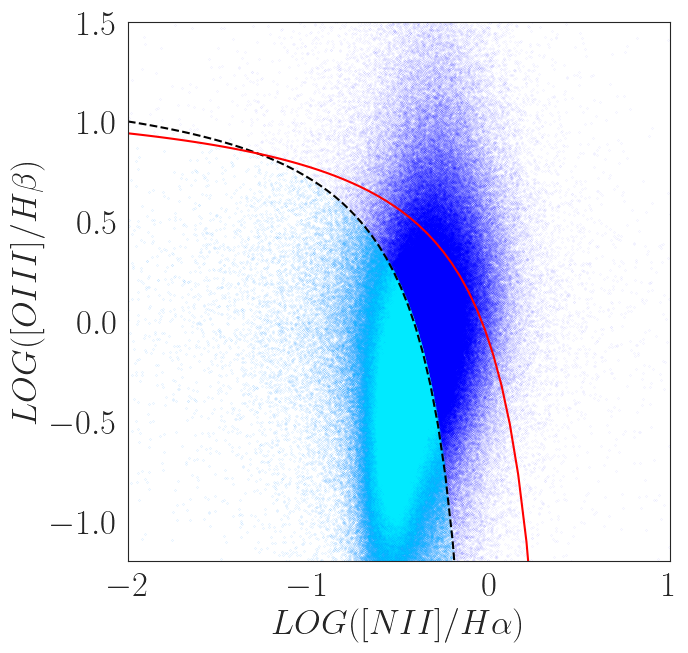

In [11]:
x_ = np.log10(nii/ha)
y_ = np.log10(oiii/hb)
fig, ax  = plt.subplots(figsize=(7,7))
ax.scatter(x_, y_, s=0.001, color='blue')

x = np.linspace(-2,0)
y = 0.61/(x-0.05) + 1.3

mask1 = y_ < 0.61/(x_-0.05) + 1.3
mask2 = y_< 0.61/(x_-0.47) + 1.19
mask3 = x_<0
mask4 = ~np.isnan(x_)
mask5 = ~np.isnan(y_)

mask = mask1 & mask2 & mask3 & mask4 & mask5

sf_mask1 = np.where(mask,1,np.nan)
x_ *= sf_mask1
y_ *= sf_mask1

ax.scatter(x_, y_, s=0.001, color='cyan')

ax.plot(x,y,'--k')

x = np.linspace(-2,0.25)
y = 0.61/(x-0.47) + 1.19

ax.plot(x,y,'-r')

ax.set_xlim(-2, 1)
ax.set_ylim(-1.2,1.5)

ax.set_xlabel(r'$LOG([NII]/H\alpha)$')
ax.set_ylabel(r'$LOG([OIII]/H\beta)$')

/tmp/ipykernel_977/1174859803.py:1: RuntimeWarning: divide by zero encountered in divide
  x_ = np.log10(nii/ha)
/tmp/ipykernel_977/1174859803.py:1: RuntimeWarning: invalid value encountered in divide
  x_ = np.log10(nii/ha)
/tmp/ipykernel_977/1174859803.py:1: RuntimeWarning: divide by zero encountered in log10
  x_ = np.log10(nii/ha)
/tmp/ipykernel_977/1174859803.py:2: RuntimeWarning: divide by zero encountered in divide
  y_ = np.log10(oiii/hb)
/tmp/ipykernel_977/1174859803.py:2: RuntimeWarning: invalid value encountered in divide
  y_ = np.log10(oiii/hb)
/tmp/ipykernel_977/1174859803.py:2: RuntimeWarning: divide by zero encountered in log10
  y_ = np.log10(oiii/hb)


Text(0, 0.5, '$LOG([OIII]/H\\beta)$')

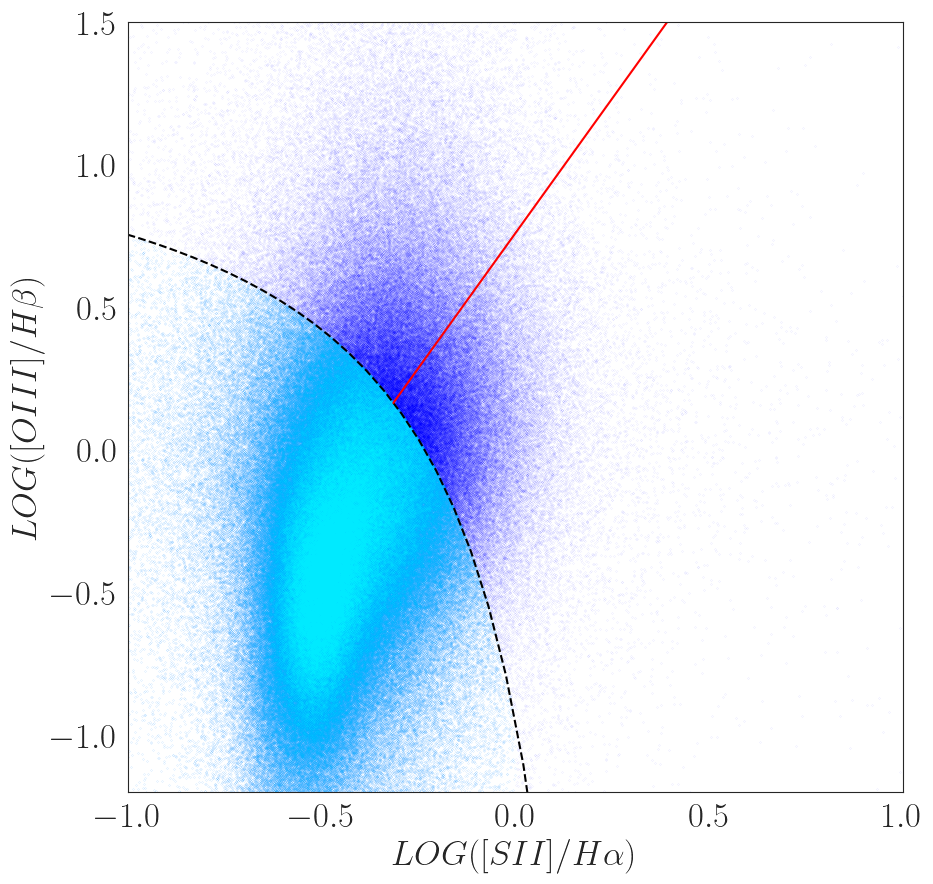

In [12]:
x_ = np.log10(nii/ha)
y_ = np.log10(oiii/hb)
fig, ax  = plt.subplots(figsize=(10,10))

ax.scatter(x_, y_, s=0.001, color='blue')


mask1 = y_ < 0.72/(x_-0.32) + 1.3
mask2 = x_<0
mask3 = ~np.isnan(x_)
mask4 = ~np.isnan(y_)

mask = mask1 & mask2 & mask3 & mask4 

sf_mask2 = np.where(mask,1,np.nan)
x_ *= sf_mask2
y_ *= sf_mask2

ax.scatter(x_, y_, s=0.001, color='cyan')
           
x = np.linspace(-2,0.2)
y = 0.72/(x-0.32) + 1.3
ax.plot(x,y,'--k')

x = np.linspace(-0.315,0.4)
y = 1.89*x + 0.76

ax.plot(x,y,'-r')

ax.set_xlim(-1, 1)
ax.set_ylim(-1.2,1.5)

ax.set_xlabel(r'$LOG([SII]/H\alpha)$')
ax.set_ylabel(r'$LOG([OIII]/H\beta)$')

In [13]:
sf_mask = sf_mask1*sf_mask2

### **Emission Line Maps**

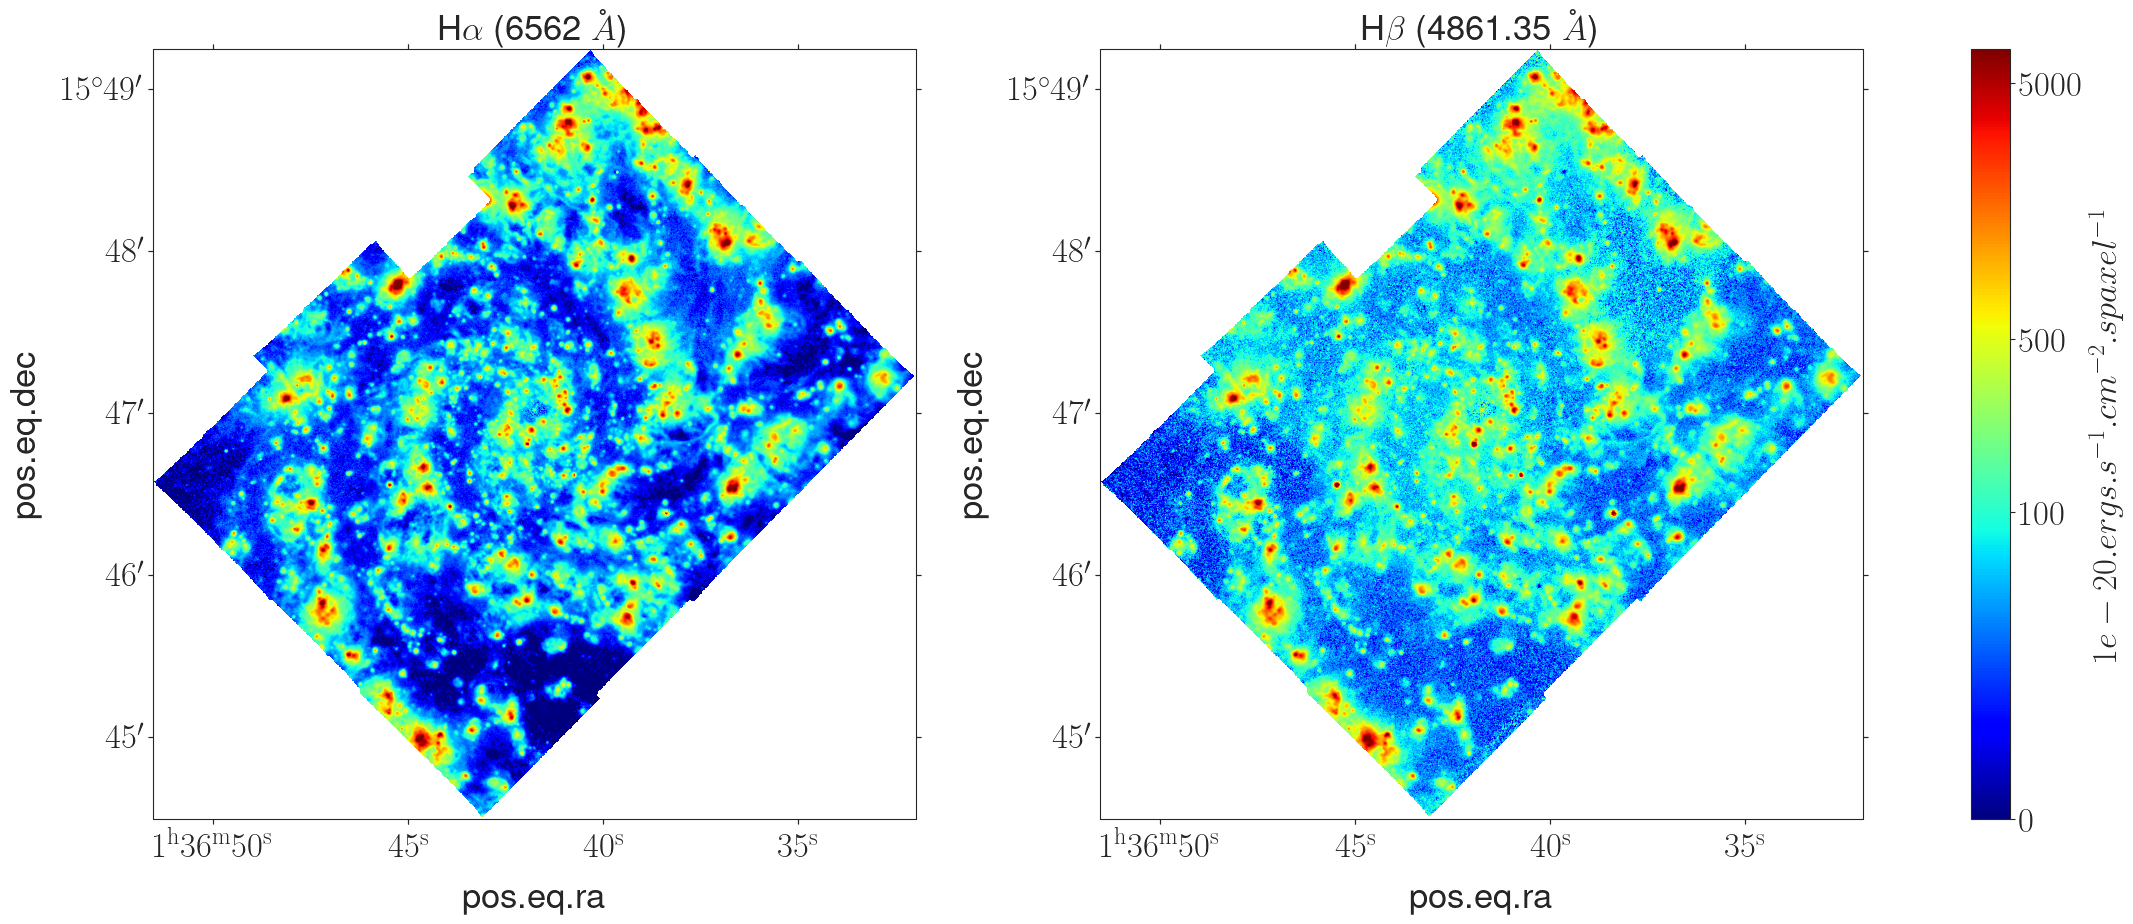

In [14]:
fig = plt.figure(figsize=(28,10))

ax1 = fig.add_subplot(121, projection=muse_wcs)
norm = simple_norm(ha, 'log',min_percent=5, max_percent = 99.9)
ax1.imshow(ha, norm=norm, cmap='jet')
ax1.set_title(r'H$\alpha$ (6562 $\AA$)')

ax2 = fig.add_subplot(122, projection=muse_wcs, sharey=ax1)
norm = simple_norm(hb, 'log',min_percent=5, max_percent = 99.9)
img = ax2.imshow(hb, norm=norm, cmap='jet')
ax2.set_title(r'H$\beta$ (4861.35 $\AA$)')

cb = plt.colorbar(img, ax= [ax1,ax2])
cb.set_label(r'$1e-20.ergs.s^{-1}.cm^{-2}.spaxel^{-1}$')
cb.ax.set_yticks([0,100,500,5000]);

### **Extinction and Balmer Decrement**

In [12]:
ha_mask1 = ha<3*ha_err 
ha_mask2 = np.isnan(ha)
ha_mask3 = np.isnan(ha_err)
ha_mask = ha_mask1 | ha_mask2 | ha_mask3

hb_mask1 = hb<3*hb_err 
hb_mask2 = np.isnan(hb)
hb_mask3 = np.isnan(hb_err)
hb_mask = hb_mask1 | hb_mask2 | hb_mask3

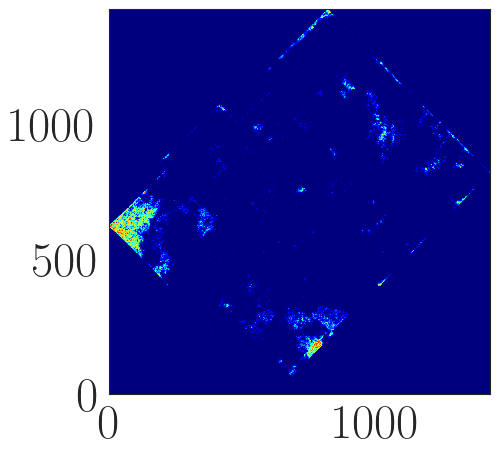

In [13]:
plt.imshow(ha_mask1)

In [14]:
Av_mask = ha_mask | hb_mask
Av_mask = np.where(Av_mask, np.nan,1)

In [15]:
ha_hb = ha/hb
E_B_V = 0.934*np.log(ha_hb/2.86)

Av_map_muse = 3.1*E_B_V*Av_mask

Av_map_muse = np.where(np.isinf(abs(Av_map_muse)),np.nan,Av_map_muse)


Av_map_muse = np.where(Av_map_muse<0,np.nan,Av_map_muse)

/tmp/ipykernel_4629/4202451177.py:1: RuntimeWarning: divide by zero encountered in divide
  ha_hb = ha/hb
/tmp/ipykernel_4629/4202451177.py:1: RuntimeWarning: invalid value encountered in divide
  ha_hb = ha/hb
/tmp/ipykernel_4629/4202451177.py:2: RuntimeWarning: divide by zero encountered in log
  E_B_V = 0.934*np.log(ha_hb/2.86)


NameError: name 'regions_dict' is not defined

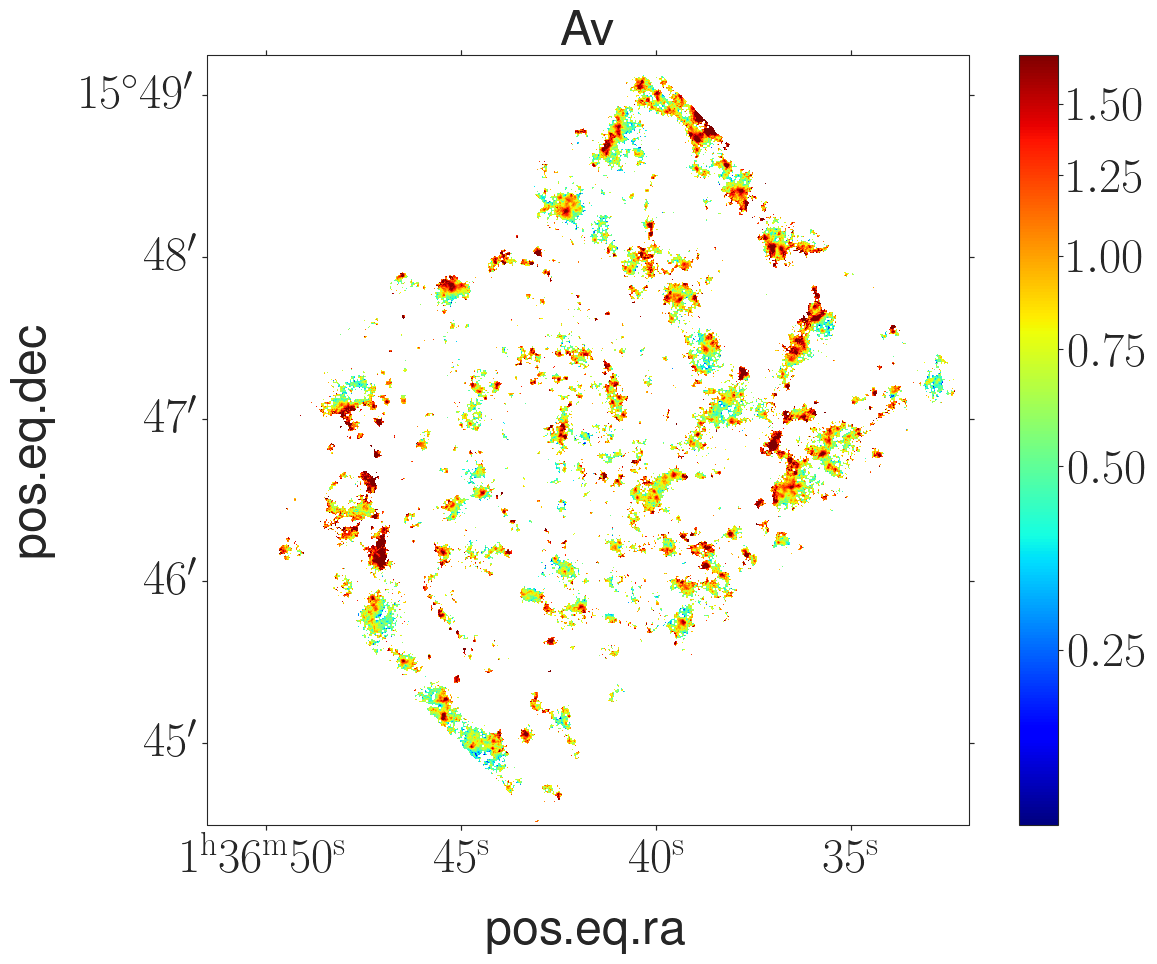

In [16]:
fig = plt.figure(figsize=(13,10))

ax = fig.add_subplot( projection=muse_wcs)
norm = simple_norm(Av_map_muse, 'sqrt',min_percent=10, max_percent = 93.)
img = ax.imshow(Av_map_muse, norm=norm, cmap='jet')
ax.set_title(r'Av')
cb = plt.colorbar(img, ax=ax)

for i in range(21):
    region =  regions_dict[f'bubble_{i}']
    ra = region['ra']
    dec = region['dec']
    radius = region['radius']
    
    r = SphericalCircle((ra* u.deg, dec* u.deg), radius * u.arcsec,
                         edgecolor='black', facecolor='none',
                         transform=ax.get_transform('icrs'))
    ax.add_patch(r)

In [20]:
Av_n,_ = reproject_exact((Av_map_muse, muse_wcs), wcs_n, data_n.shape)

/home/avinashck/anaconda3/envs/inaoe/lib/python3.11/site-packages/reproject/spherical_intersect/core.py:35: UserWarning: The reproject_exact function currently has precision issues with images that have resolutions below ~0.05 arcsec, so the results may not be accurate.
  warnings.warn(


In [55]:
Av_map_n = np.full_like(reg_arr,np.nan)
Av_map_std = np.full_like(reg_arr,np.nan)
for i in range(15):
    for j in range(6):
        k = int(reg_arr[i,j])
        region =  regions_dict[f'reg_{k}']
        ra = region['ra']
        dec = region['dec']
        pos = SkyCoord(ra=ra,dec=dec, frame='icrs', unit='deg')
        cutout = Cutout2D(Av_n, pos, 24*u.arcsec,wcs = wcs_n)
        if not np.all(np.isnan(cutout.data)):
            Av_map_n[i,j] =  np.nanmedian(cutout.data)
            Av_map_std[i,j] =  np.nanstd(cutout.data)
                           

In [56]:
np.nanmin(Av_map_n.T)

0.4259894795291456

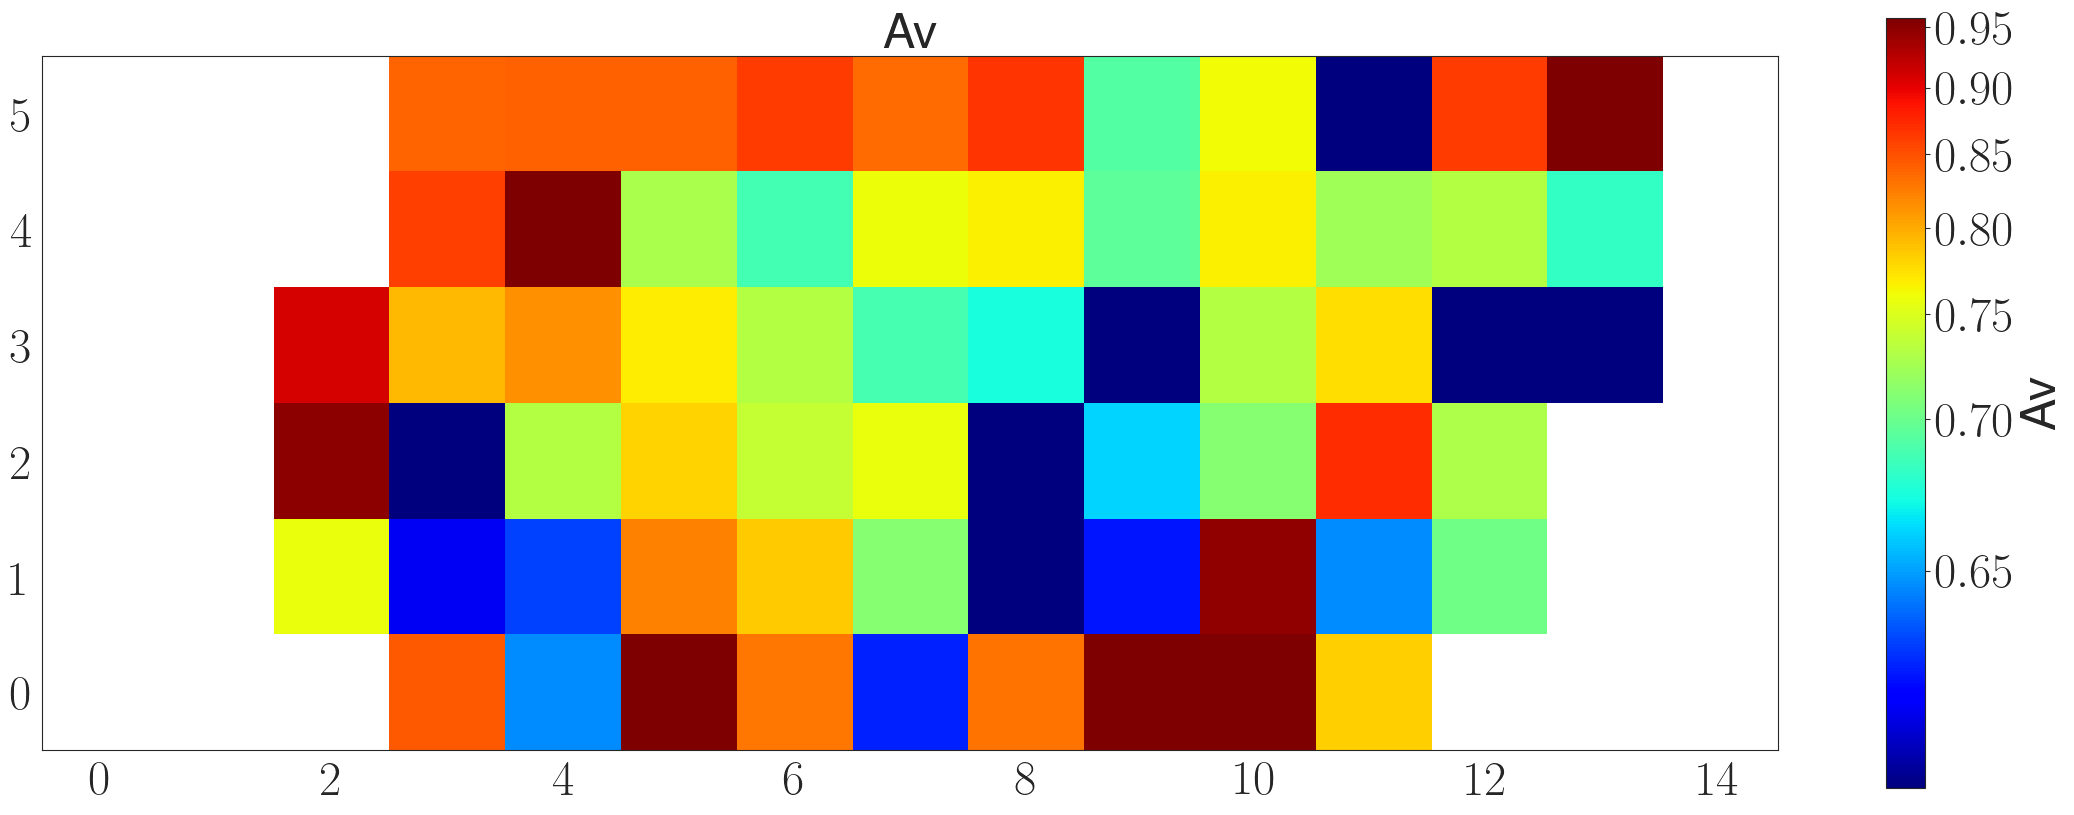

In [57]:
fig = plt.figure(figsize=(28,10))

ax = fig.add_subplot(111)
norm = simple_norm(Av_map_n.T, 'sqrt',min_percent=10, max_percent = 93.)
img = ax.imshow(Av_map_n.T, norm=norm, cmap='jet')
ax.set_title('Av')
cb = plt.colorbar(img, ax=ax)
cb.set_label('Av')

In [44]:
hdu = fits.PrimaryHDU(data=Av_map, header= muse_wcs.to_header())
hdul = fits.HDUList([hdu])
hdul.writeto('../data/NGC_628/MUSE/MUSE_Av.fits', overwrite=True)

NameError: name 'Av_map' is not defined

### **N2 Gas-phase Metallicity**

In [58]:
n2 = nii/ha

ha_mask1 = ha<3*ha_err 
ha_mask2 = np.isnan(ha)
ha_mask3 = np.isnan(ha_err)
ha_mask = ha_mask1 | ha_mask2 | ha_mask3

nii_mask1 = nii<3*nii_err 
nii_mask2 = np.isnan(nii)
nii_mask3 = np.isnan(nii_err)
nii_mask = nii_mask1 | nii_mask2 | nii_mask3

n2_mask = nii_mask | ha_mask

n2_mask = np.where(n2_mask, np.nan,1)

oh = 8.9 + 0.57*np.log10(n2)*n2_mask

oh = np.where(np.isinf(abs(oh)),np.nan,oh)

/tmp/ipykernel_4629/1204626428.py:1: RuntimeWarning: divide by zero encountered in divide
  n2 = nii/ha
/tmp/ipykernel_4629/1204626428.py:1: RuntimeWarning: invalid value encountered in divide
  n2 = nii/ha
/tmp/ipykernel_4629/1204626428.py:17: RuntimeWarning: divide by zero encountered in log10
  oh = 8.9 + 0.57*np.log10(n2)*n2_mask


NameError: name 'sf_mask' is not defined

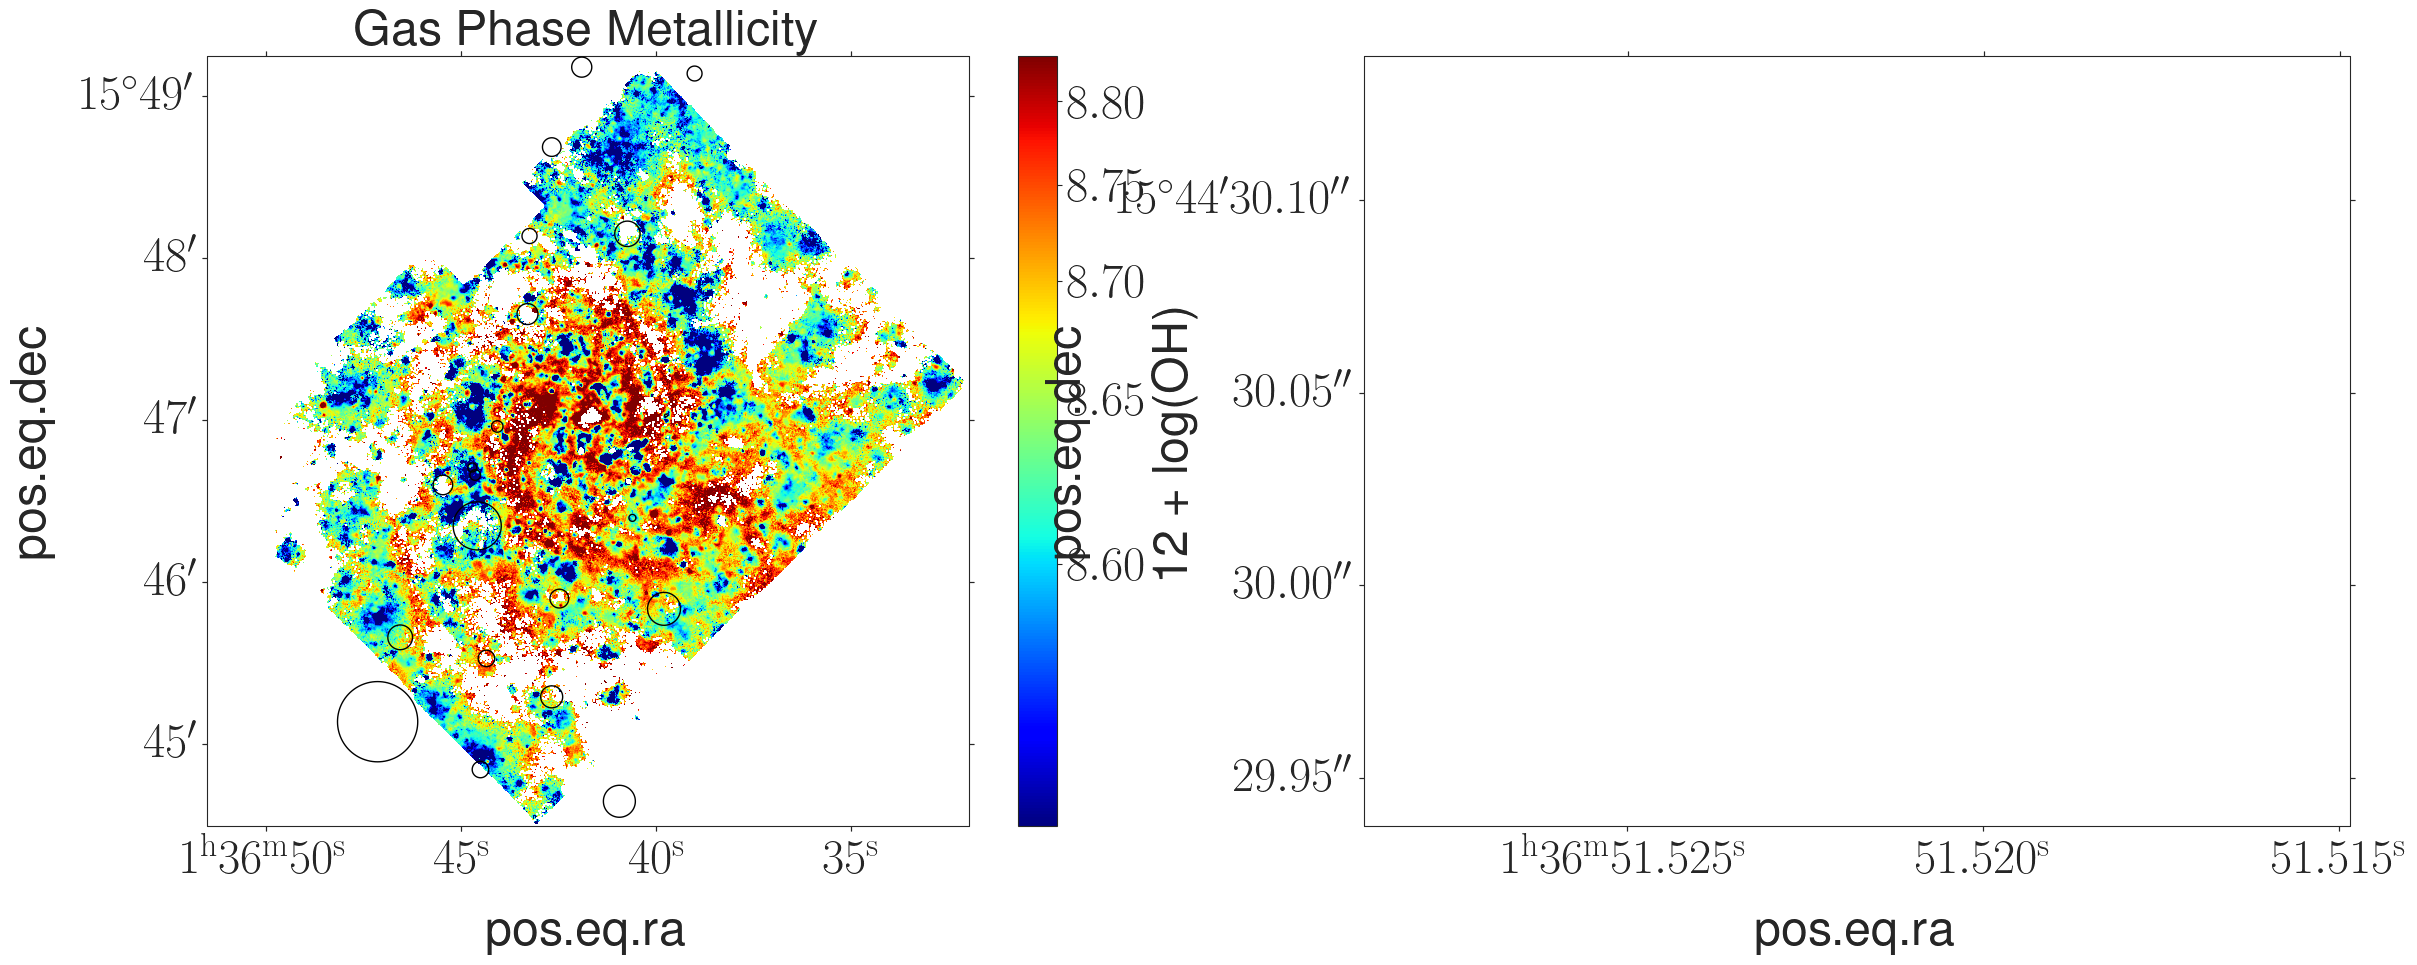

In [59]:
fig = plt.figure(figsize=(28,10))

ax = fig.add_subplot(121, projection=muse_wcs)
norm = simple_norm(oh, 'sqrt',min_percent=10, max_percent = 93.)
img = ax.imshow(oh, norm=norm, cmap='jet')
ax.set_title('Gas Phase Metallicity')
cb = plt.colorbar(img, ax=ax)
cb.set_label('12 + log(OH)')

for i in range(21):
    region =  regions_dict[f'bubble_{i}']
    ra = region['ra']
    dec = region['dec']
    radius = region['radius']
    
    r = SphericalCircle((ra* u.deg, dec* u.deg), radius * u.arcsec,
                         edgecolor='black', facecolor='none',
                         transform=ax.get_transform('icrs'))
    ax.add_patch(r)

ax = fig.add_subplot(122, projection=muse_wcs)
norm = simple_norm(oh*sf_mask, 'sqrt',min_percent=10, max_percent = 93.)
img = ax.imshow(oh*sf_mask, norm=norm, cmap='jet')
ax.set_title('Gas Phase Metallicity with SF Mask')
cb = plt.colorbar(img, ax=ax)
cb.set_label('12 + log(OH)')


for i in range(21):
    region =  regions_dict[f'bubble_{i}']
    ra = region['ra']
    dec = region['dec']
    radius = region['radius']
    
    r = SphericalCircle((ra* u.deg, dec* u.deg), radius * u.arcsec,
                         edgecolor='black', facecolor='none',
                         transform=ax.get_transform('icrs'))
    ax.add_patch(r)

In [60]:
oh_z = 10**(oh-8.69)*0.017

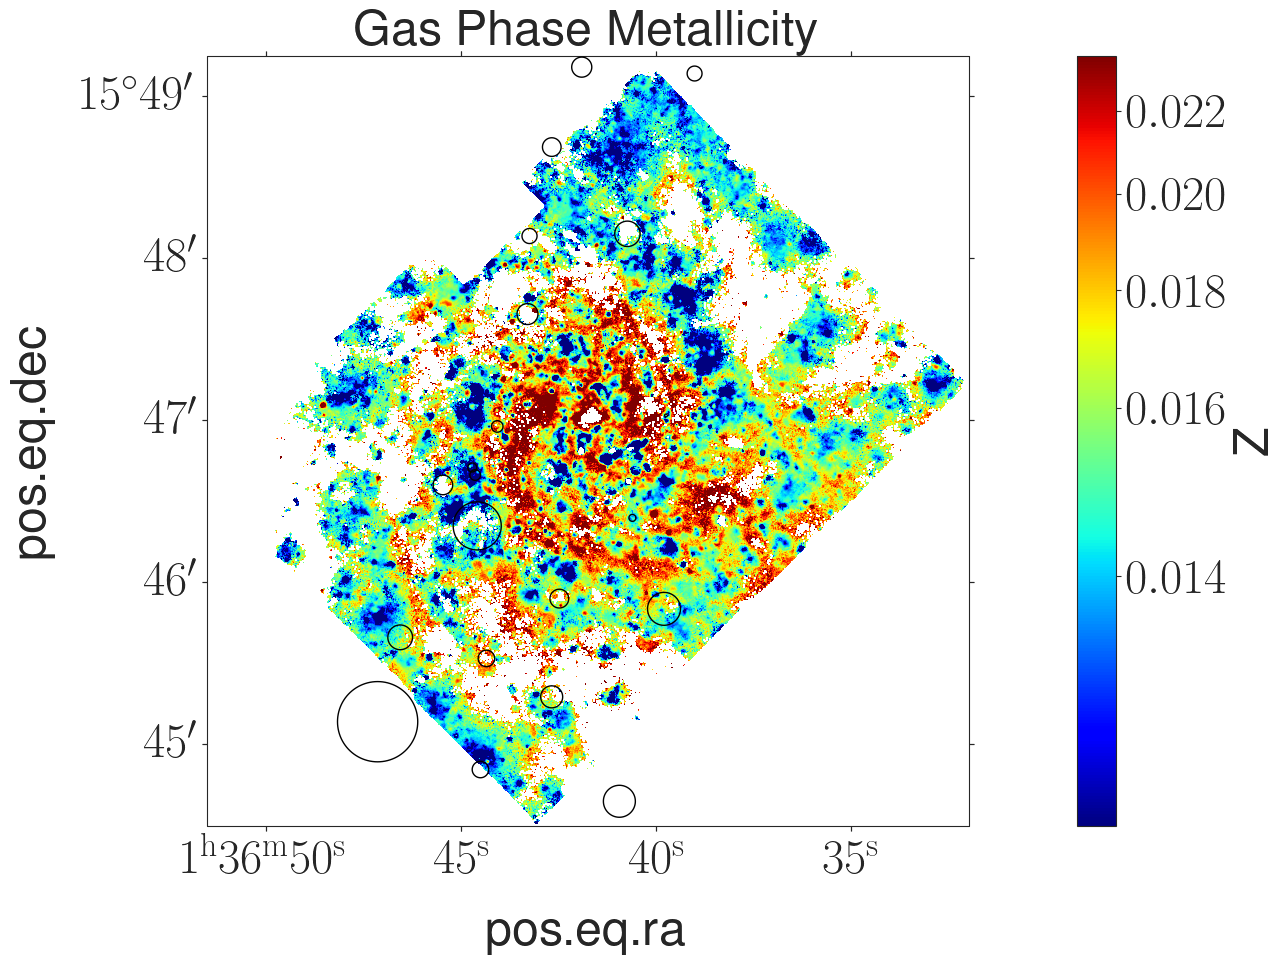

In [61]:
fig = plt.figure(figsize=(28,10))

ax = fig.add_subplot(111, projection=muse_wcs)
norm = simple_norm(oh_z, 'sqrt',min_percent=10, max_percent = 93.)
img = ax.imshow(oh_z, norm=norm, cmap='jet')
ax.set_title('Gas Phase Metallicity')
cb = plt.colorbar(img, ax=ax)
cb.set_label('Z')

for i in range(21):
    region =  regions_dict[f'bubble_{i}']
    ra = region['ra']
    dec = region['dec']
    radius = region['radius']
    
    r = SphericalCircle((ra* u.deg, dec* u.deg), radius * u.arcsec,
                         edgecolor='black', facecolor='none',
                         transform=ax.get_transform('icrs'))
    ax.add_patch(r)


In [62]:
oh_z_n,_ = reproject_exact((oh_z, muse_wcs), wcs_n, data_n.shape)

/home/avinashck/anaconda3/envs/inaoe/lib/python3.11/site-packages/reproject/spherical_intersect/core.py:35: UserWarning: The reproject_exact function currently has precision issues with images that have resolutions below ~0.05 arcsec, so the results may not be accurate.
  warnings.warn(


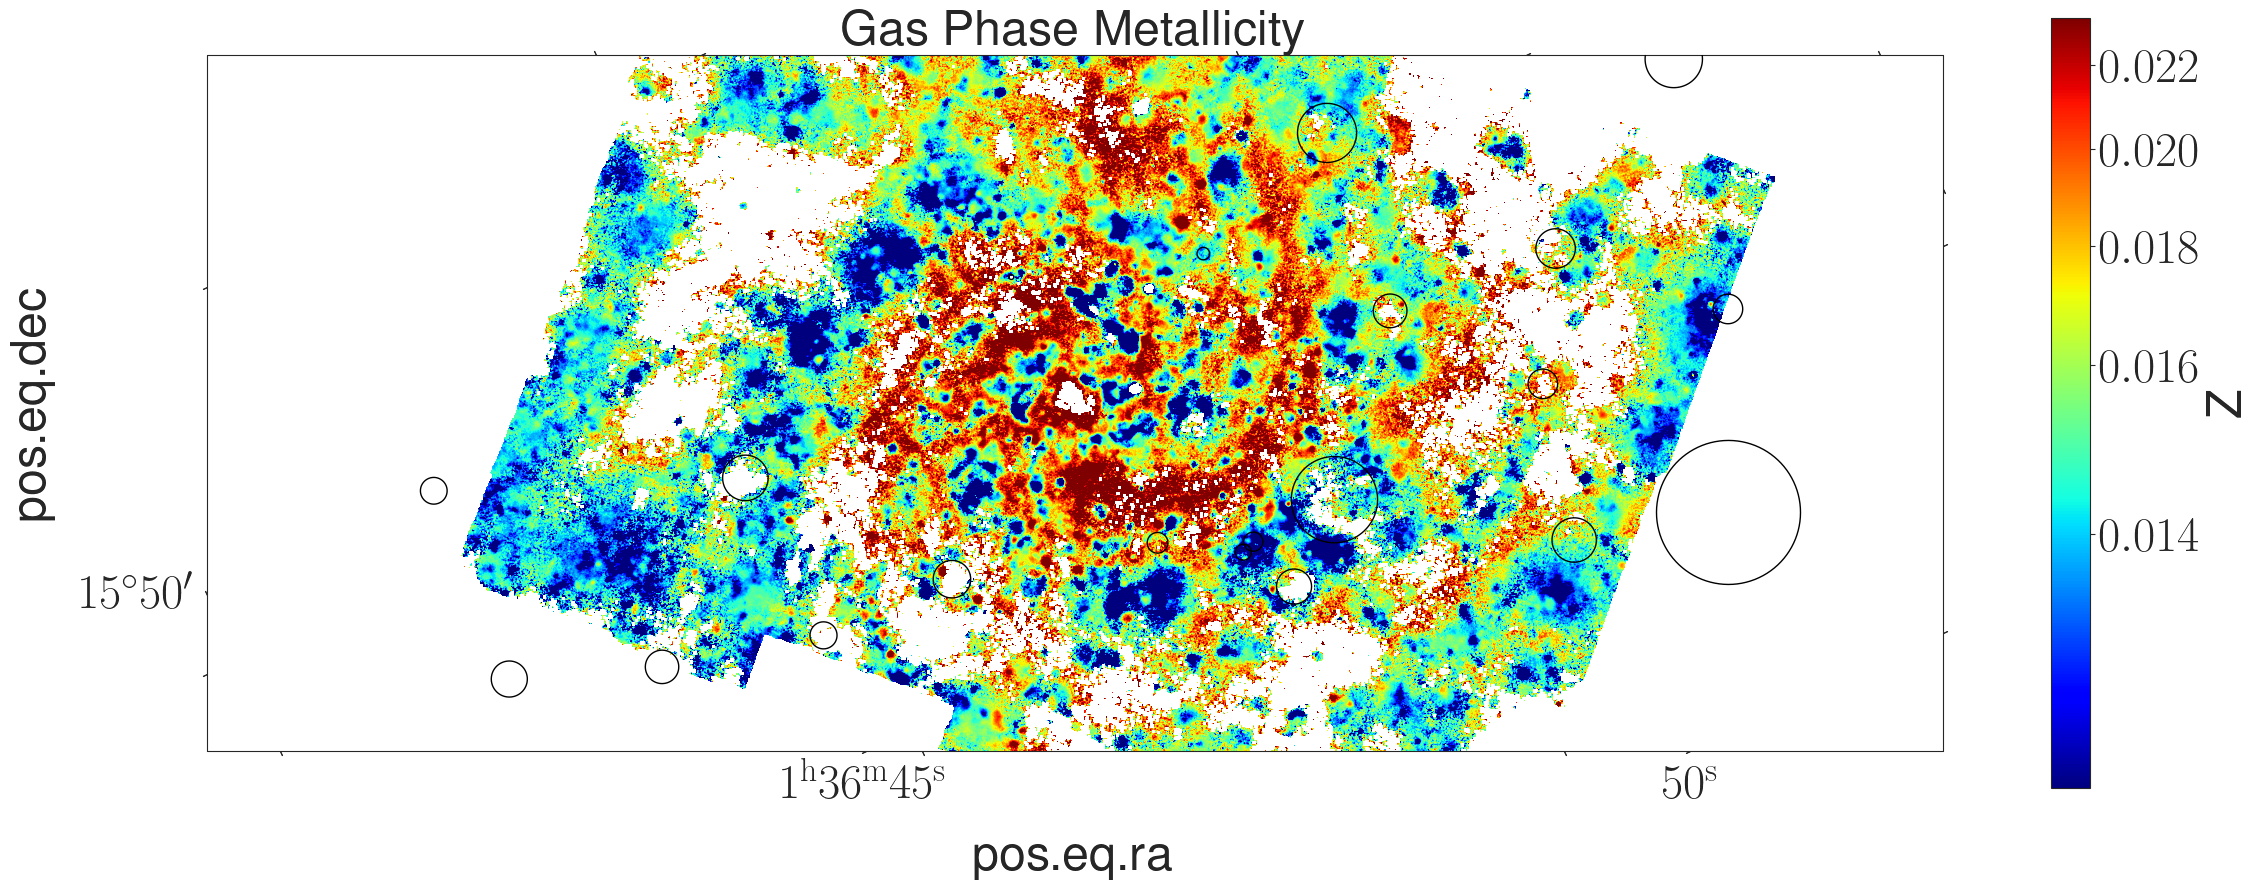

In [63]:
fig = plt.figure(figsize=(28,10))

ax = fig.add_subplot(111, projection=wcs_n)
norm = simple_norm(oh_z_n, 'sqrt',min_percent=10, max_percent = 93.)
img = ax.imshow(oh_z_n, norm=norm, cmap='jet')
ax.set_title('Gas Phase Metallicity')
cb = plt.colorbar(img, ax=ax)
cb.set_label('Z')

for i in range(21):
    region =  regions_dict[f'bubble_{i}']
    ra = region['ra']
    dec = region['dec']
    radius = region['radius']
    
    r = SphericalCircle((ra* u.deg, dec* u.deg), radius * u.arcsec,
                         edgecolor='black', facecolor='none',
                         transform=ax.get_transform('icrs'))
    ax.add_patch(r)


In [64]:
Z_gas = np.full_like(reg_arr,np.nan)
Z_gas_std = np.full_like(reg_arr,np.nan)
for i in range(15):
    for j in range(6):
        k = int(reg_arr[i,j])
        region =  regions_dict[f'reg_{k}']
        ra = region['ra']
        dec = region['dec']
        pos = SkyCoord(ra=ra,dec=dec, frame='icrs', unit='deg')
        cutout = Cutout2D(oh_z_n, pos, 24*u.arcsec,wcs = wcs_n)
        if not np.all(np.isnan(cutout.data)):
            Z_gas[i,j] =  np.nanmedian(cutout.data)
            Z_gas_std[i,j] =  np.nanstd(cutout.data)
                           

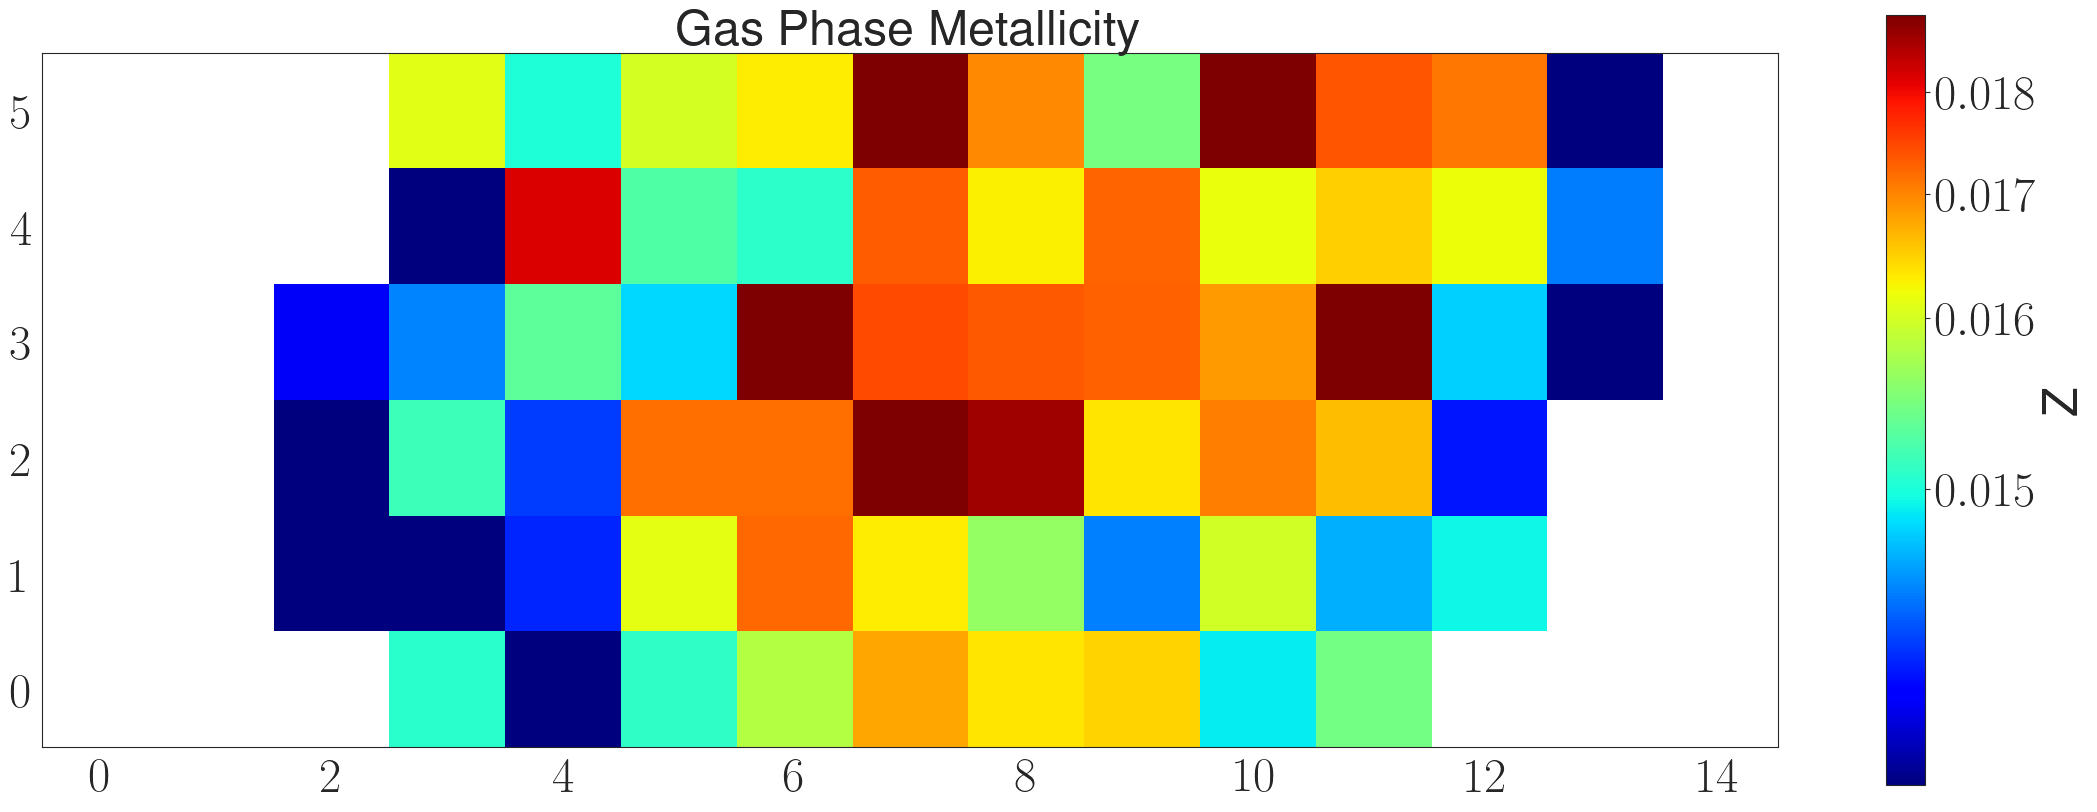

In [65]:
fig = plt.figure(figsize=(28,10))

ax = fig.add_subplot(111)
norm = simple_norm(Z_gas.T, 'sqrt',min_percent=10, max_percent = 93.)
img = ax.imshow(Z_gas.T, norm=norm, cmap='jet')
ax.set_title('Gas Phase Metallicity')
cb = plt.colorbar(img, ax=ax)
cb.set_label('Z')

### **Spatially-resolved SFR**

In [ ]:
F_ha_dc = ha*pow(10,2.468*E_B_V)*1e-20

cosmo = FlatLambdaCDM(69.6, 0.286)
z = (650.55*u.km/u.s).to(u.dimensionless_unscaled,u.doppler_redshift())
DL = cosmo.luminosity_distance(z.value).to(u.cm).value

L_ha = F_ha_dc*4*np.pi*DL**2

SFR = 5.5*pow(10,-42)*L_ha*sf_mask

In [ ]:
fig = plt.figure(figsize=(13,10))

ax = fig.add_subplot( projection=muse_wcs)
norm = simple_norm(SFR, 'sqrt',min_percent=10, max_percent = 93.)
img = ax.imshow(SFR, norm=norm, cmap='jet')
ax.set_title('SFR')
cb = plt.colorbar(img, ax=ax)
cb.set_label(r'$M_{\odot}/yr$')

for i in range(21):
    region =  regions_dict[f'bubble_{i}']
    ra = region['ra']
    dec = region['dec']
    radius = region['radius']
    
    r = SphericalCircle((ra* u.deg, dec* u.deg), radius * u.arcsec,
                         edgecolor='black', facecolor='none',
                         transform=ax.get_transform('icrs'))
    ax.add_patch(r)

### **Velocity maps**

In [ ]:
ha_vel_mask1 = np.abs(ha_vel)<3*ha_vel_err 
ha_vel_mask2 = np.isnan(ha_vel)
ha_vel_mask3 = np.isnan(ha_vel_err)
ha_vel_mask = ha_vel_mask1 | ha_vel_mask2 | ha_vel_mask3

ha_vel_mask = np.where(ha_vel_mask, np.nan,1)

In [ ]:
ha_vel[700,700], ha_vel_err[700,700]

In [ ]:
fig = plt.figure(figsize=(28,10))

ax = fig.add_subplot(121, projection=muse_wcs)
norm = simple_norm(st_vel, 'sqrt',min_percent=10, max_percent = 93.)
img = ax.imshow(st_vel, norm=norm, cmap='RdBu_r')
ax.set_title('Stellar Velocity')
cb = plt.colorbar(img, ax=ax)
cb.set_label(r'$km/s$')

for i in range(21):
    region =  regions_dict[f'bubble_{i}']
    ra = region['ra']
    dec = region['dec']
    radius = region['radius']
    
    r = SphericalCircle((ra* u.deg, dec* u.deg), radius * u.arcsec,
                         edgecolor='black', facecolor='none',
                         transform=ax.get_transform('icrs'), lw=3)
    ax.add_patch(r)

ax = fig.add_subplot(122, projection=muse_wcs)
norm = simple_norm(ha_vel, 'sqrt',min_percent=10, max_percent = 93.)
img = ax.imshow(ha_vel, norm=norm, cmap='RdBu_r')
ax.set_title(r'$H\alpha$ Velocity')
cb = plt.colorbar(img, ax=ax)
cb.set_label(r'$km/s$')

for i in range(21):
    region =  regions_dict[f'bubble_{i}']
    ra = region['ra']
    dec = region['dec']
    radius = region['radius']
    
    r = SphericalCircle((ra* u.deg, dec* u.deg), radius * u.arcsec,
                         edgecolor='black', facecolor='none',
                         transform=ax.get_transform('icrs'), lw=3)
    ax.add_patch(r)

In [ ]:
fig = plt.figure(figsize=(28,10))

ax = fig.add_subplot(121, projection=muse_wcs)
norm = simple_norm(st_sigma, 'sqrt',min_percent=10, max_percent = 93.)
img = ax.imshow(st_sigma, norm=norm, cmap='jet')
ax.set_title('Stellar Velocity Dispersion')
cb = plt.colorbar(img, ax=ax)
cb.set_label(r'$km/s$')


ax = fig.add_subplot(122, projection=muse_wcs)
norm = simple_norm(ha_sigma, 'sqrt',min_percent=10, max_percent = 93.)
img = ax.imshow(ha_sigma, norm=norm, cmap='jet')
ax.set_title(r'$H\alpha$ Velocity Dispersion')
cb = plt.colorbar(img, ax=ax)
cb.set_label(r'$km/s$')

for i in range(21):
    region =  regions_dict[f'bubble_{i}']
    ra = region['ra']
    dec = region['dec']
    radius = region['radius']
    
    r = SphericalCircle((ra* u.deg, dec* u.deg), radius * u.arcsec,
                         edgecolor='black', facecolor='none',
                         transform=ax.get_transform('icrs'), lw =3)
    ax.add_patch(r)

# **Photometric Analysis**

## **Functions**

In [10]:
def rotate_coords(x,y,h=0,k=0,theta=0,Sx=1,Sy=1):
    
    X = np.array([x,y,x**0])

    T = np.array([[1,0,h],
                 [0,1,k],
                 [0,0,1]])

    Tinv =  np.array([[1,0,-h],
                      [0,1,-k],
                      [0,0,1]])

    R = np.array([[np.cos(theta), -np.sin(theta),0],
                  [np.sin(theta),  np.cos(theta),0],
                  [0            ,              0,1]])
    
    S = np.array([[Sx,0,0],
                  [0, Sy,0],
                  [0,0,1]])
    
    X_n = T@S@R@Tinv@X
    
    return X_n[0], X_n[1]

In [11]:
def gen_CMD(filt1='f115w', filt2='f150w', filt3=None,name=None,r=333, r_in=None, r_out=None, mag_err_lim=0.2,
             out_dir='PHOT_OUTPUT_EPSF',Av=0.19,  Av_ = 3, Av_x=2, Av_y=19, sqr_field=False, ab_dist = True,
            dismod=29.7415, xlims=[-0.5,2.5], ylims=[18,28], label=3, met=0.02, gen_contours=False,
            cmd=None, regions=['bubble','bkg1', 'bkg2','bkg3'], mag_err_cols = ['mag_err_1','mag_err_2'],
            gen_kde=False, add_ref=False, add_ext='', fig = None, ax= None, label_min=None, label_max=None,
             ra_col = 'ra_1', dec_col= 'dec_1', ages=[7.,8.,9.], alpha=1, age_Z = False,s =0.2,lw=3,
            comp_flag=False, ref_xpos=-0.25, skip_data = False, ang=114.99508):
    
    if label_min is None or label_max is None:
        label_min=0
        label_max=label
    if filt3 is None:
        filt3 = filt2
    if met is not None and cmd is not None:
        cmd = cmd[cmd['Zini']==met]
        
    age_lin = []
    for i in ages:
        if i<6:
            age_lin.append(f'{np.round(10**i,1)} Myr')
        if i >= 6  and i <9:
            i-=6
            age_lin.append(f'{np.round(10**i,1)} Myr')
        elif i >= 9:
            i-=9
            age_lin.append(f'{np.round(10**i,1)} Gyr')
            
    if fig is None:        
        fig = plt.figure(figsize=(len(regions)*12,10))
        
    for i,region in enumerate(regions):
        if ax is None:
            ax = fig.add_subplot(1,len(regions),int(i+1))
        
        if name is None:
            tab_bub = Table.read(f"../{out_dir}/{region}/{filt1}_{filt2}{add_ext}.fits")
        else:
            tab_bub = Table.read(f"../{out_dir}/{name}.fits")
            
        for i in mag_err_cols:
            tab_bub = tab_bub[tab_bub[i]<=mag_err_lim]

        AF1 =  Av_dict[filt1]*Av
        AF2 =  Av_dict[filt2]*Av
        AF3 =  Av_dict[filt3]*Av
        
        ra_cen = regions_dict[region]['ra']
        dec_cen = regions_dict[region]['dec']
        
        coords = SkyCoord(ra=tab_bub[ra_col]*u.degree, dec=tab_bub[dec_col]*u.degree, frame='icrs')
        origin = SkyCoord(ra=ra_cen*u.degree, dec=dec_cen*u.degree, frame='icrs')

        # Calculate the position angle and separation from the origin
        pos_angle = coords.position_angle(origin)
        sep = coords.separation(origin)

        # Convert the rotation angle to radians and apply it to the position angle
        angle_rad = np.deg2rad(ang)
        new_pos_angle = pos_angle + angle_rad*u.radian

        # Calculate the new coordinates using the updated position angle and separation
        new_coords = origin.directional_offset_by(new_pos_angle, sep)
        tab_bub['temp_ra'] = new_coords.ra.value
        tab_bub['temp_dec'] = new_coords.dec.value
        
        
        tab_bub['r'] = angular_separation(tab_bub['temp_ra']*u.deg,tab_bub['temp_dec']*u.deg,
                                          ra_cen*u.deg, dec_cen*u.deg).to(u.arcsec).value
        
        if (r_out is None or r_in is None) :
            r_in = 0
            r_out = r
            
        if r_out is not None:  
            if not sqr_field:
                tab_bub = tab_bub[ (tab_bub['r']>=r_in) & (tab_bub['r'] <r_out)]
            else:
                tab_bub = tab_bub[ (tab_bub['temp_ra']>=ra_cen-r_out/3600) & (tab_bub['temp_ra']<=ra_cen+r_out/3600) ]
                tab_bub = tab_bub[ (tab_bub['temp_dec']>=dec_cen-r_out/3600) & (tab_bub['temp_dec']<=dec_cen+r_out/3600) ]
        
        tab_bub.remove_columns(['temp_ra', 'temp_dec'])
        
        x = tab_bub[f'mag_vega_{filt1.upper()}'] - tab_bub[f'mag_vega_{filt2.upper()}']
        y = tab_bub[f'mag_vega_{filt3.upper()}'] 
        
        x = x.value.astype(float)
        y = y.value.astype(float)
        
        n_sources = len(x)
        
        if gen_kde and not gen_contours:
            # Peform the kernel density estimate
            xx, yy = np.mgrid[xlims[0]:xlims[1]:100j, ylims[0]:ylims[1]:100j]
            positions = np.vstack([xx.ravel(), yy.ravel()])
            values = np.vstack([x, y])

            kernel = gaussian_kde(values, bw_method=0.05)
            f = np.reshape(kernel(positions), xx.shape)

            f = f.T
            img = ax.imshow(f, cmap='gray_r', 
                          extent=[xlims[0], xlims[1], 
                                  ylims[0], ylims[1]],
                           interpolation='nearest', aspect='auto')

            
        elif gen_contours:
            cmap_custom = LinearSegmentedColormap.from_list("custom_grey_to_white", ["grey", "white"], N=256)
            ax.scatter(x,y, s=0.2, color='black', label='data')
            sb.kdeplot(x=x, y=y, levels=[0.1, 0.25,0.5,0.75,0.9,0.95,0.99],
                       ax=ax, fill=True, cmap=cmap_custom)
            sb.kdeplot(x=x, y=y, levels=[0.1, 0.25,0.5,0.75,0.9,0.95,0.99],
                       ax=ax,  color='black')
            
            
        elif not skip_data:
            ax.scatter(x,y, s=s, color='black', label='data')
         
        if ab_dist:
            
            ax1 = ax.twinx()  # instantiate a second axes that shares the same x-axis

            ax1.set_ylabel(r'$M_{' + f'{filt3.upper()}' + r'}$')  # we already handled the x-label with ax1

        ax.set_xlabel(f"{filt1.upper()} - {filt2.upper()}")
        ax.set_ylabel(filt3.upper())
        
        # Error bars

        ref = tab_bub[f'mag_vega_{filt3.upper()}']
        ref_new = np.arange(np.ceil(y.min()),np.floor(y.max())+0.5,0.5)

        mag_err1 = tab_bub[mag_err_cols[0]]
        mag_err2 = tab_bub[mag_err_cols[1]]

        if len(mag_err_cols)>2:
            mag_err3 = tab_bub[mag_err_cols[2]]
        else:
            mag_err3 = mag_err2

        col_err = np.sqrt(mag_err1**2 + mag_err2**2)

        if not skip_data:
            init = models.Exponential1D()
            fit = fitting.LevMarLSQFitter()
            model_col = fit(init,ref,col_err)

            init = models.Exponential1D()
            fit = fitting.LevMarLSQFitter()
            model_mag = fit(init,ref,mag_err3)

            x = ref_xpos + 0*ref_new
            y = ref_new
            yerr = model_mag(ref_new)
            xerr = model_col(ref_new)

            ax.errorbar(x, y, yerr,xerr ,fmt='o', color = 'red', markersize=0.5, capsize=2) 
        
        if cmd is not None:
            for i, age in enumerate(ages):
                t = cmd[np.round(cmd['logAge'],4)==age].copy()
                
                mags = np.unique(t['Zini'])
                
                for Z in mags:
                    t_ = t[t['Zini']==Z]
                    t_ = t_[(t_['label']>=label_min) & (t_['label']<=label_max)]

                    x =  (t_[f'{filt1.upper()}mag'] + AF1) - (t_[f'{filt2.upper()}mag'] + AF2)
                    y =  t_[f'{filt3.upper()}mag'] + AF3 + dismod

                    mask = (y.values[1:]- y.values[:-1])<1
                    mask = np.array([True] + list(mask))
                    mask = np.where(~mask, np.nan, 1)

                    if len(mags)>1:
                        ax.plot(x*mask, y*mask, linewidth=lw, label=age_lin[i]+ f' {Z}', alpha=alpha)
                    else:
                        ax.plot(x*mask, y*mask, linewidth=lw, label=age_lin[i], alpha=alpha)
                
        else: 
            met = ' '

        ax.set_ylim(ylims[0], ylims[1])
        ax.set_xlim(xlims[0], xlims[1]) 
        
        yticks = ax.get_yticks()
        yticks_n = yticks - dismod - AF3
        
        dy = yticks_n - np.floor(yticks_n)
        
        if ab_dist:
            ax1.set_yticks(yticks - dy, np.floor(yticks_n))

            ax1.set_ylim(ylims[0], ylims[1])
            ax1.set_xlim(xlims[0], xlims[1]) 

        ax.invert_yaxis()
        if ab_dist:
            ax1.invert_yaxis()
        ax.set_title(region.capitalize() + f" | No of sources: {n_sources} | Z : {met}", fontsize=30)
            
        if add_ref:
            ax.plot([xlims[0], xlims[1]],[25,25], '--r', zorder=200)
            ax.plot([xlims[0], xlims[1]],[24.5,24.5], '--r', zorder=200)
            ax.plot([xlims[0], xlims[1]],[23,23], '--r', zorder=200)
         
        if comp_flag:
            comp_f1 = comp[region][filt1]
            comp_f2 = comp[region][filt2]

            y0 = comp_f2
            x0 = comp_f1 - comp_f2

            ax.plot([x0,xlims[1]],[y0,y0])
            
        ax.legend(fontsize=15)
        ax.xaxis.set_major_locator(AutoLocator())
        ax.xaxis.set_minor_locator(AutoMinorLocator())

        ax.yaxis.set_major_locator(AutoLocator())
        ax.yaxis.set_minor_locator(AutoMinorLocator())
        

        ax.tick_params(which='both', length=14,direction="in", bottom=True, top=True,left=True)
        ax.tick_params(which='minor', length=8)
        
        if ab_dist:
            ax1.yaxis.set_minor_locator(AutoMinorLocator())
            ax1.tick_params(which='both', length=14,direction="in", right=True)
            ax1.tick_params(which='minor', length=8)

        AF1_ =  Av_dict[filt1]*Av_
        AF2_ =  Av_dict[filt2]*Av_
        AF3_ =  Av_dict[filt3]*Av_

        dx = AF1_ - AF2_
        dy = AF3_

        ax.annotate('', xy=(Av_x, Av_y),
                     xycoords='data',
                     xytext=(Av_x+dx, Av_y+dy),
                     textcoords='data',
                     arrowprops=dict(arrowstyle= '<|-',
                                     color='black',
                                     lw=2,
                                     ls='-')
                   )
            
        ax.annotate(f'Av = {Av_}', xy=(Av_x-0.1, Av_y-0.1), fontsize=20)
        
    fig.tight_layout()
    return fig, ax, tab_bub

In [12]:
def gen_CMD_xcut( filt1='f115w', filt2='f150w',filt3=None,region='bubble', 
                 name=None, Av=0.19, r=333, sqr_field=False,
                 r_in=None, r_out=None, met=0.02, mag_err_cols = ['mag_err_1','mag_err_2'],
                 dismod=29.95, fit_slope=False, cmd_ylo=None, cmd_yhi=None,
                 mag_err_lim=0.2,label_min=0, label_max=10,
                 cmd=None, ra_col = 'ra_1', dec_col= 'dec_1',
                out_dir='PHOT_OUTPUT_EPSF', xlims=[-0.5,2.5], ylims=[18,30],
                age=9.0, cmd_xlo = None, cmd_xhi= None, age_Z=False,
                l_lo = 22, l_hi=26.5, dl=0.5, Av_ = 3,
                Av_x=2, Av_y=22, flag=111, fit_isochrone=True, fig=None, ax=None,ang=114.99508):
        
    if filt3 is None:
        filt3 = filt2
        
    if met is not None:
        cmd = cmd[cmd['Zini']==met]
        
    if cmd_ylo is None or cmd_yhi is None:
        cmd_ylo = l_lo - dl
        cmd_yhi = l_hi + dl
    
    if name is None:
        tab_bub = Table.read(f"../{out_dir}/{region}/{filt1}_{filt2}.fits")
    else:
        tab_bub = Table.read(f"../{out_dir}/{name}.fits")
        
    for i in mag_err_cols:
        tab_bub = tab_bub[tab_bub[i]<=mag_err_lim]
    
    AF1 =  Av_dict[filt1]*Av
    AF2 =  Av_dict[filt2]*Av
    AF3 =  Av_dict[filt3]*Av

    ra_cen = regions_dict[region]['ra']
    dec_cen = regions_dict[region]['dec']
    
    coords = SkyCoord(ra=tab_bub[ra_col]*u.degree, dec=tab_bub[dec_col]*u.degree, frame='icrs')
    origin = SkyCoord(ra=ra_cen*u.degree, dec=dec_cen*u.degree, frame='icrs')

    # Calculate the position angle and separation from the origin
    pos_angle = coords.position_angle(origin)
    sep = coords.separation(origin)

    # Convert the rotation angle to radians and apply it to the position angle
    angle_rad = np.deg2rad(ang)
    new_pos_angle = pos_angle + angle_rad*u.radian

    # Calculate the new coordinates using the updated position angle and separation
    new_coords = origin.directional_offset_by(new_pos_angle, sep)
    tab_bub['temp_ra'] = new_coords.ra.value
    tab_bub['temp_dec'] = new_coords.dec.value


    tab_bub['r'] = angular_separation(tab_bub['temp_ra']*u.deg,tab_bub['temp_dec']*u.deg,
                                      ra_cen*u.deg, dec_cen*u.deg).to(u.arcsec).value

    if (r_out is None or r_in is None) :
        r_in = 0
        r_out = r

    if r_out is not None:  
        if not sqr_field:
            tab_bub = tab_bub[ (tab_bub['r']>=r_in) & (tab_bub['r'] <r_out)]
        else:
            tab_bub = tab_bub[ (tab_bub['temp_ra']>=ra_cen-r_out/3600) & (tab_bub['temp_ra']<=ra_cen+r_out/3600) ]
            tab_bub = tab_bub[ (tab_bub['temp_dec']>=dec_cen-r_out/3600) & (tab_bub['temp_dec']<=dec_cen+r_out/3600) ]

    tab_bub.remove_columns(['temp_ra', 'temp_dec'])
    
    x = tab_bub[f'mag_vega_{filt1.upper()}'] - tab_bub[f'mag_vega_{filt2.upper()}']
    y = tab_bub[f'mag_vega_{filt3.upper()}'] 

    x = x.value.astype(float)
    y = y.value.astype(float)

    if cmd_xlo is None or cmd_xhi is None:
        cmd_xlo = x.mean() - 0.5

        cmd_xhi = x.mean() + 0.5
    
    if fig is None or ax is None:
        fig = plt.figure(figsize=(7,7))
        ax = fig.add_subplot(1,1,1)
    
    theta = np.arctan(AF3/(AF1-AF2)) #
    
    ax.scatter(x,y, s=0.1, color='black')
    
    if cmd is not None:
        cmd = cmd[(cmd['label']>=label_min) & (cmd['label']<=label_max)]

        t = cmd[np.round(cmd['logAge'],1)==age].copy()

        met = np.array(cmd['Zini'])[0]
        x_i =  (t[f'{filt1.upper()}mag'] + AF1) - (t[f'{filt2.upper()}mag'] + AF2)
        y_i =  t[f'{filt3.upper()}mag'] + AF3 + dismod
        
        x_i = np.array(x_i)
        y_i = np.array(y_i)
        
        x_iso = x_i.copy()
        y_iso = y_i.copy()
        
        x_i = x_i[np.where( (y_i>=cmd_ylo) & (y_i<=cmd_yhi))[0]]
        y_i = y_i[np.where( (y_i>=cmd_ylo) & (y_i<=cmd_yhi))[0]]
        
        ax.plot(x_iso,y_iso, zorder=300,color='red')

        ax.legend(['data', f'age = {age}'])

    x_l = np.linspace(cmd_xlo, cmd_xhi)    

    # Bin mid points
    y_rgbn = np.arange(l_lo, l_hi, dl)
    
    y_rgb_mid = y_rgbn[:-1] + dl/2   
    
    if fit_isochrone:
        init = models.Linear1D()
        fit = fitting.LinearLSQFitter()
        model_iso = fit(init, y_i, x_i)
        
        ax.plot(model_iso(np.linspace(l_lo-0.1,l_hi+0.1)),
                          np.linspace(l_lo-0.1,l_hi+0.1),'--g', 
               zorder=400)
        if fit_slope:
            theta = np.arctan(-model_iso.slope.value)
        
    else:
        model_iso =  models.Linear1D(slope=0, intercept=l_lo) #interp1d(y_i, x_i)
        ax.plot(model_iso(np.linspace(l_lo-0.1,l_hi+0.1)),
                          np.linspace(l_lo-0.1,l_hi+0.1),'--g', 
               zorder=400)
        
    x_rgb_mid = model_iso(y_rgb_mid)
    
    ax.scatter(x_rgb_mid, y_rgb_mid, c='r' ,zorder = 200)

    dats = []
    
    dx = (cmd_xhi-cmd_xlo)/2
    for i,y0 in enumerate(y_rgbn[:-1]):

        # Extinction Vector
        x0 = model_iso(y0)
        y_Avl = y0 + np.tan(theta)*(x_l-x0)
        
        x01 = model_iso(y0 + dl)
        y_Avu = y0 + dl + np.tan(theta)*(x_l-x01)

        ax.plot(x_l,y_Avl, color='grey')
        ax.plot(x_l,y_Avu, color='grey')

        init = models.Linear1D()
        fit = fitting.LinearLSQFitter()
        
        model_Avl = fit(init, x_l, y_Avl)
        model_Avu = fit(init, x_l, y_Avu)

        c1 = (y>model_Avl(x)) & (y<=model_Avu(x))
        c2 = (x>=x_rgb_mid[i]-dx) & (x<=x_rgb_mid[i]+dx) 

        yn = y[np.where(c1&c2)]
        xn = x[np.where(c1&c2)]
        
        dat = np.array([xn, yn])
        dats.append(dat)
    
    ax.set_xlabel(f"{filt1.upper()} - {filt2.upper()}")
    ax.set_ylabel(filt3.upper())

    ax.set_ylim(ylims[0], ylims[1])
    ax.set_xlim(xlims[0], xlims[1])  
    ax.invert_yaxis()
    ax.set_title(region.capitalize())

    ax.xaxis.set_major_locator(AutoLocator())
    ax.xaxis.set_minor_locator(AutoMinorLocator())

    ax.yaxis.set_major_locator(AutoLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())

    ax.tick_params(which='both', length=7,direction="in", bottom=True, top=True,left=True, right=True)
    ax.tick_params(which='minor', length=4)
    
    AF1_ =  Av_dict[filt1]*Av_
    AF2_ =  Av_dict[filt2]*Av_
    AF3_ =  Av_dict[filt3]*Av_
    
    dx = AF1_ - AF2_
    dy = AF3_

    ax.annotate('', xy=(Av_x, Av_y),
                 xycoords='data',
                 xytext=(Av_x+dx, Av_y+dy),
                 textcoords='data',
                 arrowprops=dict(arrowstyle= '<|-',
                                 color='black',
                                 lw=0.5,
                                 ls='-')
               )

    ax.annotate(f'Av = {Av_}', xy=(Av_x-0.1, Av_y-0.1))
    
    return fig, ax, dats, x_rgb_mid, y_rgb_mid, y_rgbn

In [13]:
def gen_CMD_ycut( filt1='f115w', filt2='f150w', filt3=None,region='bubble',name=None, Av=0.19, r=333,
                r_in=None, r_out=None, fig = None, ax = None, met=0.02, mag_err_lim=0.2, mag_err_cols = ['mag_err_1','mag_err_2'],
                dismod=29.95, cmd=None, label=3, ra_col = 'ra_1', dec_col= 'dec_1',
                out_dir='PHOT_OUTPUT_r25', xlims=[-0.5,2.5], ylims=[18,30], sqr_field=False,
                age=9.0, cmd_xlo = None, cmd_xhi= None, gen_kde=False, age_Z=False, perp_iso=False,
                l_lo = 22, l_hi=26.5, dl=0.5, Av_ = 3,ref_xpos=0.25,
                Av_x=2, Av_y=22, fit_isochrone=True,y0=None,ang=114.99508):
    
    if filt3 is None:
        filt3 = filt2
    if met is not None:
        if 'Zini' in cmd.keys():
            cmd = cmd[cmd['Zini']==met]
        else:
            cmd = cmd[cmd['Zini_1']==met]  
            
    cmd_ylo = l_lo
    cmd_yhi = l_hi
    
    age_lin = []
    for i in [age]:
        if i<6:
            age_lin.append(f'{np.ceil(10**i)} Myr')
        if i >= 6  and i <9:
            i-=6
            age_lin.append(f'{np.ceil(10**i)} Myr')
        elif i >= 9:
            i-=9
            age_lin.append(f'{np.ceil(10**i)} Gyr')
            
    
    if name is None:
        tab_bub = Table.read(f"../{out_dir}/{region}/{filt1}_{filt2}.fits")
    else:
        tab_bub = Table.read(f"../{out_dir}/{name}.fits")
        
    mag_errs = [i for i in tab_bub.keys() if 'mag_err' in i]
        
    for i in mag_errs:
        tab_bub = tab_bub[tab_bub[i]<=mag_err_lim]

    AF1 =  Av_dict[filt1]*Av
    AF2 =  Av_dict[filt2]*Av
    AF3 =  Av_dict[filt3]*Av

    ra_cen = regions_dict[region]['ra']
    dec_cen = regions_dict[region]['dec']
    
    coords = SkyCoord(ra=tab_bub[ra_col]*u.degree, dec=tab_bub[dec_col]*u.degree, frame='icrs')
    origin = SkyCoord(ra=ra_cen*u.degree, dec=dec_cen*u.degree, frame='icrs')

    # Calculate the position angle and separation from the origin
    pos_angle = coords.position_angle(origin)
    sep = coords.separation(origin)

    # Convert the rotation angle to radians and apply it to the position angle
    angle_rad = np.deg2rad(ang)
    new_pos_angle = pos_angle + angle_rad*u.radian

    # Calculate the new coordinates using the updated position angle and separation
    new_coords = origin.directional_offset_by(new_pos_angle, sep)
    tab_bub['temp_ra'] = new_coords.ra.value
    tab_bub['temp_dec'] = new_coords.dec.value


    tab_bub['r'] = angular_separation(tab_bub['temp_ra']*u.deg,tab_bub['temp_dec']*u.deg,
                                      ra_cen*u.deg, dec_cen*u.deg).to(u.arcsec).value

    if (r_out is None or r_in is None) :
        r_in = 0
        r_out = r

    if r_out is not None:  
        if not sqr_field:
            tab_bub = tab_bub[ (tab_bub['r']>=r_in) & (tab_bub['r'] <r_out)]
        else:
            tab_bub = tab_bub[ (tab_bub['temp_ra']>=ra_cen-r_out/3600) & (tab_bub['temp_ra']<=ra_cen+r_out/3600) ]
            tab_bub = tab_bub[ (tab_bub['temp_dec']>=dec_cen-r_out/3600) & (tab_bub['temp_dec']<=dec_cen+r_out/3600) ]

    tab_bub.remove_columns(['temp_ra', 'temp_dec'])
    
    x = tab_bub[f'mag_vega_{filt1.upper()}'] - tab_bub[f'mag_vega_{filt2.upper()}']
    y = tab_bub[f'mag_vega_{filt3.upper()}'] 
    
    x = x.value.astype(float)
    y = y.value.astype(float)
    
    if cmd_xlo is None or cmd_xhi is None:
        cmd_xlo = x.mean() - 1

        cmd_xhi = x.mean() + 1
    
    if fig is None or ax is None:
        fig = plt.figure(figsize=(7,7))
        ax = fig.add_subplot(1,1,1)
    l = []
    if gen_kde:

        # Peform the kernel density estimate
        xx, yy = np.mgrid[xlims[0]:xlims[1]:100j, ylims[0]:ylims[1]:100j]
        positions = np.vstack([xx.ravel(), yy.ravel()])
        values = np.vstack([x, y])

        kernel = gaussian_kde(values, bw_method=0.05)
        f = np.reshape(kernel(positions), xx.shape)

        f = f.T
        img = ax.imshow(f, cmap='jet', 
                      extent=[xlims[0], xlims[1], 
                              ylims[0], ylims[1]],
                       interpolation='nearest', aspect='auto')
            
    else:
        ax.scatter(x,y, s=0.2, color='black')
        l.append('data')
        
    l_ = [i for i in cmd.keys() if 'logAge' in i][0]
    
    if cmd is not None:
        t = cmd[np.round(cmd[l_],1)==age].copy()
        t = t[t['label']<=label]
        x_i =  (t[f'{filt1.upper()}mag'] + AF1) - (t[f'{filt2.upper()}mag'] + AF2)
        y_i =  t[f'{filt3.upper()}mag']
        # Max mag and Color
        M = y_i.min()
        c_ = x_i[y_i==y_i.min()].values[0]
        
        y_i +=   AF3 + dismod
        
        x_i = np.array(x_i)
        y_i = np.array(y_i)
        
        x_iso = x_i.copy()
        y_iso = y_i.copy()
        

        x_i = x_i[np.where( (y_i>=cmd_ylo-0.5) & (y_i<=cmd_yhi+0.5))[0]]
        y_i = y_i[np.where( (y_i>=cmd_ylo-0.5) & (y_i<=cmd_yhi+0.5))[0]]

        y_i = y_i[np.where( (x_i>=cmd_xlo-0.2) & (x_i<=cmd_xhi+0.2))[0]]
        x_i = x_i[np.where( (x_i>=cmd_xlo-0.2) & (x_i<=cmd_xhi+0.2))[0]]
        
        ax.plot(x_iso,y_iso, zorder=200, color='black')
        
        l.append(f'Age = {age_lin[0]}')

    x_l = np.linspace(0, 2)    

    # Bin mid points
    x_rgbn = np.arange(cmd_xlo, cmd_xhi, dl)
    
    x_rgb_mid = x_rgbn[:-1]+dl/2   
    
    if fit_isochrone:
        init = models.Linear1D()
        fit = fitting.LinearLSQFitter()
        model_iso = fit(init, x_i, y_i)
        slope = 1/model_iso.slope.value
    
    elif perp_iso:
        slope=0
        
    else:
        model_iso = interp1d(x_i, y_i)
        slope = 1/model_iso.slope.value
    
    if y0 is None:
        y0 = y.mean()
    y_rgb_mid = y0 + x_rgb_mid*0

    dats = []
    
    x0 = 1# x.mean()
    init = models.Linear1D()
    fit = fitting.LinearLSQFitter()
    for x0 in x_rgbn[:-1]:
        
        y_l = np.linspace(cmd_ylo, cmd_yhi)
        x_l = slope*(y_l - y0) + x0
        
        y_r = np.linspace(cmd_ylo, cmd_yhi)
        x_r = slope*(y_r - y0) + x0 + dl

        ax.plot(x_l,y_l, color='red')
        ax.plot(x_r,y_r, color='red')

        init = models.Linear1D()
        fit = fitting.LinearLSQFitter()
        
        model_l = fit(init, y_l,x_l)
        model_r = fit(init, y_r,x_r)

        c1 = (x>model_l(y)) & (x<=model_r(y))

        yn = y[np.where(c1)]
        xn = x[np.where(c1)]
        if not gen_kde:
            ax.scatter(xn,yn, s =0.1, color='green', zorder=100)
        dat = np.array([xn, yn])
        dats.append(dat)
    
    ref = tab_bub[f'mag_vega_{filt2.upper()}']
    ref_new = np.arange(np.ceil(y.min()),np.ceil(y.max()) + 0.5,0.5)

    mag_err1 = tab_bub[mag_err_cols[0]]
    mag_err2 = tab_bub[mag_err_cols[1]]

    if len(mag_err_cols)>2:
        mag_err3 = tab_bub[mag_err_cols[2]]
    else:
        mag_err3 = mag_err2

    col_err = np.sqrt(mag_err1**2 + mag_err2**2)

    init = models.Exponential1D()
    fit = fitting.LevMarLSQFitter()
    model_col = fit(init,ref,col_err)

    init = models.Exponential1D()
    fit = fitting.LevMarLSQFitter()
    model_mag = fit(init,ref,mag_err3)

    x = ref_xpos + 0*ref_new
    y = ref_new
    yerr = model_mag(ref_new)
    xerr = model_col(ref_new)

    ax.errorbar(x, y, yerr,xerr ,fmt='o', color = 'red', markersize=0.5, capsize=2) 
    
    AF1_ =  Av_dict[filt1]*Av_
    AF2_ =  Av_dict[filt2]*Av_
    AF3_ =  Av_dict[filt3]*Av_
    
    dx = AF1_ - AF2_
    dy = AF3_

    ax.annotate('', xy=(Av_x, Av_y),
                 xycoords='data',
                 xytext=(Av_x+dx, Av_y+dy),
                 textcoords='data',
                 arrowprops=dict(arrowstyle= '<|-',
                                 color='black',
                                 lw=0.5,
                                 ls='-')
               )

    ax.annotate(f'Av = {Av_}', xy=(Av_x-0.1, Av_y-0.1))
    
    ax.set_xlabel(f"{filt1.upper()} - {filt2.upper()}")
    ax.set_ylabel(filt3.upper())

    ax.set_ylim(ylims[0], ylims[1])
    ax.set_xlim(xlims[0], xlims[1])  
    ax.invert_yaxis()
    title = f" | Z : {met} | " + "$M_" + "{" + f"{filt3.upper()}" +r"}^{TRGB}$ : " + f"{M} | "
    title += r"$A_{" + f"{filt3.upper()}" + r"}$ : " + f"{np.round(AF3,3)}"
    ax.set_title(region.capitalize() + title,
                fontsize=15)

    ax.xaxis.set_major_locator(AutoLocator())
    ax.xaxis.set_minor_locator(AutoMinorLocator())

    ax.yaxis.set_major_locator(AutoLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())

    ax.tick_params(which='both', length=7,direction="in", bottom=True, top=True,left=True, right=True)
    ax.tick_params(which='minor', length=4)
    ax.legend(l)
    
    return fig, ax, dats, x_rgb_mid, y_rgb_mid, x_rgbn, [M, AF3, c_]

In [14]:
Av_dict = { 
            'f275w': 2.02499,
            'f336w': 1.67536,
            'f435w': 1.33879,
            'f555w': 1.03065,
            'f814w': 0.59696,
            'f115w': 0.419,
            'f150w': 0.287,
            'f200w': 0.195,
    
            'f438w': 1.34148,
            'f606w': 0.90941,
            'f814w': 0.59845
          }

In [15]:
regions_dict = {'bubble' : {'ra'   : 24.1858128,  
                       'dec'  : 15.7725802,
                       'F115W': 25.4, 
                       'F150W': 24.63,
                       'F200W': 23.53,
                      
                       'F435W': 27.88, 
                       'F555W': 27.48,
                       'F814W': 26.52},
           
           'bkg1'   : {'ra'   : 24.1918038,
                       'dec'  : 15.7600032,
                       'F115W': 26., 
                       'F150W': 25.26,
                       'F200W': 24.21,
                      
                      'F435W': 28.26, 
                       'F555W': 27.94,
                       'F814W': 27.05},
              
           'bkg2'   : {'ra'   : 24.1787197,
                       'dec'  : 15.7543227,
                       'F115W': 26.31, 
                       'F150W': 25.39,
                       'F200W': 24.39,
                      
                      'F435W': 28.26, 
                       'F555W': 27.94,
                       'F814W': 27.05},
              
           'bkg3'   : {'ra'   : 24.1728133,
                       'dec'  : 15.7669357,
                       'F115W': 25.42, 
                       'F150W': 24.55,
                       'F200W': 23.56,
                      
                      'F435W': 27.88, 
                       'F555W': 27.48,
                       'F814W': 26.52},
                
            'galaxy' : {'ra'   : 24.1738983, 
                       'dec'  : 15.7836543,
                       'F115W': 25.42, 
                       'F150W': 24.55,
                       'F200W': 23.56},
            'm81-gc' :  {'ra':  149.47781,
                           'dec': 68.816955,
                          }}
                             
            
with open('regions90.json') as json_file:
    data = json.load(json_file)
    
regions_dict.update(data)

with open('../data/DS9 regions/bubbles.reg') as f:
    dat = f.readlines()
    
bubbles = {}
for n,i in enumerate(dat[3:]):
    ra = float(i.split(',')[0][7:])
    dec = float(i.split(',')[1])
    radius = float(i.split(',')[2].split('"')[0])
    bubbles[f'bubble_{n}'] = {'ra' : ra,
                              'dec': dec,
                              'radius': radius}
regions_dict.update(bubbles) ;

## **JWST**

### **PARSEC Isochrones**

In [44]:
with open("../data/isochrones_master/cmd_jwst_n.dat") as f:
    dat = f.readlines()

data = []

for i,d in enumerate(dat[13:]):
    if 'Zini' not in d and 'terminated' not in d:
        data.append([float(i) for i in d.split()])
        
df_cmd = pd.DataFrame(data,columns=dat[13][2:].split())
df_cmd = df_cmd.drop_duplicates(['Mini','logAge','label'])
df_cmd.to_csv("../data/isochrones_master/cmd_jwst.csv")

In [16]:
df_cmd_jwst = pd.read_csv("../data/isochrones_master/cmd_jwst.csv")

In [17]:
ages= np.unique(df_cmd_jwst['logAge'])
mets = np.unique(df_cmd_jwst['Zini'])

In [21]:
mets

array([0.0001, 0.0002, 0.0005, 0.001 , 0.002 , 0.003 , 0.004 , 0.006 ,
       0.008 , 0.01  , 0.014 , 0.017 , 0.02  , 0.03  , 0.04  , 0.06  ])

In [ ]:
if not os.path.exists('../data/isochrones/JWST'):
    os.mkdir('../data/isochrones/JWST/')
else:
    os.system('rm ../data/isochrones/JWST/*')

tabs = pd.DataFrame()
l = 1
for i, age in enumerate([ 6.8    ,  6.9    ,  7.     ,
                        7.1    ,  7.2    ,  7.3  ,  7.4    ,  7.5    ,  7.6    ,
                        7.7    ,  7.8    ,  7.9  ,  8.,   8.1    ,  8.2    ,
                        8.3    ,  8.4    ,  8.5, 9.5, 9.6    ,  9.7    ,  9.8    ,  9.90001, 10.00001]):  

    if len(str(i+1))==1:
        i = '0' + str(i+1)
    else:
        i =  str(i+1)

    for met in [0.02, 0.003]:
        temp = df_cmd_jwst[df_cmd_jwst['logAge']==age]

        temp = temp[(temp['Zini']==met) & (temp['label']<=8)]
        temp = temp.drop_duplicates(['Mini','logAge','label'])
        
        # Interpolation using F115W-F200W vs F200W
        
        x = temp['F115Wmag'].values - temp['F200Wmag'].values 
        y = temp['F200Wmag'].values
        
        diff = np.array([0] + list(np.sqrt((x[1:]-x[:-1])**2 + (y[1:]-y[:-1])**2)))
        dist = []
        for i in range(len(diff)):
            dist.append(diff[:i+1].sum())
            
        temp['dist'] = dist
        temp = temp.sort_values('dist')
        
        x = temp['dist']
        x_new = np.arange(x.min(), x.max(),0.01)

        label = np.interp(x_new, x, temp['label'])
        Mini = np.interp(x_new, x, temp['Mini'])
        f115w = np.interp(x_new, x, temp['F115Wmag'])
        f150w = np.interp(x_new, x, temp['F150Wmag'])
        f200w = np.interp(x_new, x, temp['F200Wmag'])

        temp_interp = pd.DataFrame(zip(label, Mini, f115w, f150w, f200w), columns = ['label','Mini','F115Wmag', 'F150Wmag', 'F200Wmag'])
        temp_interp['Zini'] = temp['Zini'].max()
        temp_interp['logAge'] = temp['logAge'].max()
        temp = temp_interp

        temp = temp[['label', 'Mini', 'F115Wmag', 'F150Wmag', 'F200Wmag', 'Zini', 'logAge']]
        header = list(temp.keys())
        header[0] = '#' + header[0]

        if (met==0.02 and age<=9) or (met==0.003 and age>9):
            if l<10:
                temp.to_csv(f'../data/isochrones/JWST/0{l}_PARSEC1.2S_Z0.02_logAGE{age}Myr_JWST_JHK.isoc',sep=' ',
                               index=None, header = header)
            else:
                temp.to_csv(f'../data/isochrones/JWST/{l}_PARSEC1.2S_Z0.02_logAGE{age}Myr_JWST_JHK.isoc',sep=' ',
                               index=None, header = header)
            l += 1
        if len(temp)>0:
            tabs = pd.concat([tabs, temp])
        

### **CMD**

Label: 0=PMS, 1=MS, 2=SGB, 3=RGB, (4,5,6)=different stages of CHEB, 7=EAGB, 8=TPAGB, 9=post-AGB

In [140]:
mss = []
colss = []

filt1 = 'F115W'
filt2 = 'F200W'
filt3 = 'F200W'

for i in [9.6,9.8,10,10.1139]:
    df = df_cmd_jwst[np.round(df_cmd_jwst['logAge'],4)==i]
    df = df[df['label']<=3]
    ms = []
    cols = []
    for j in [0.0001, 0.0002, 0.0005, 0.001 , 0.002 , 0.003 , 0.004 , 0.006]:
        df_ = df[df['Zini']==j]
        df_ = df_[df_['logL']==df_['logL'].max()]
        m = df_[f'{filt3}mag'].values[0]
        col = (df_[f'{filt1}mag'] - df_[f'{filt2}mag']).values[0]
        ms.append(m)
        cols.append(col)
    mss.append(ms)
    colss.append(cols)
m = np.array(mss)
col = np.array(colss)

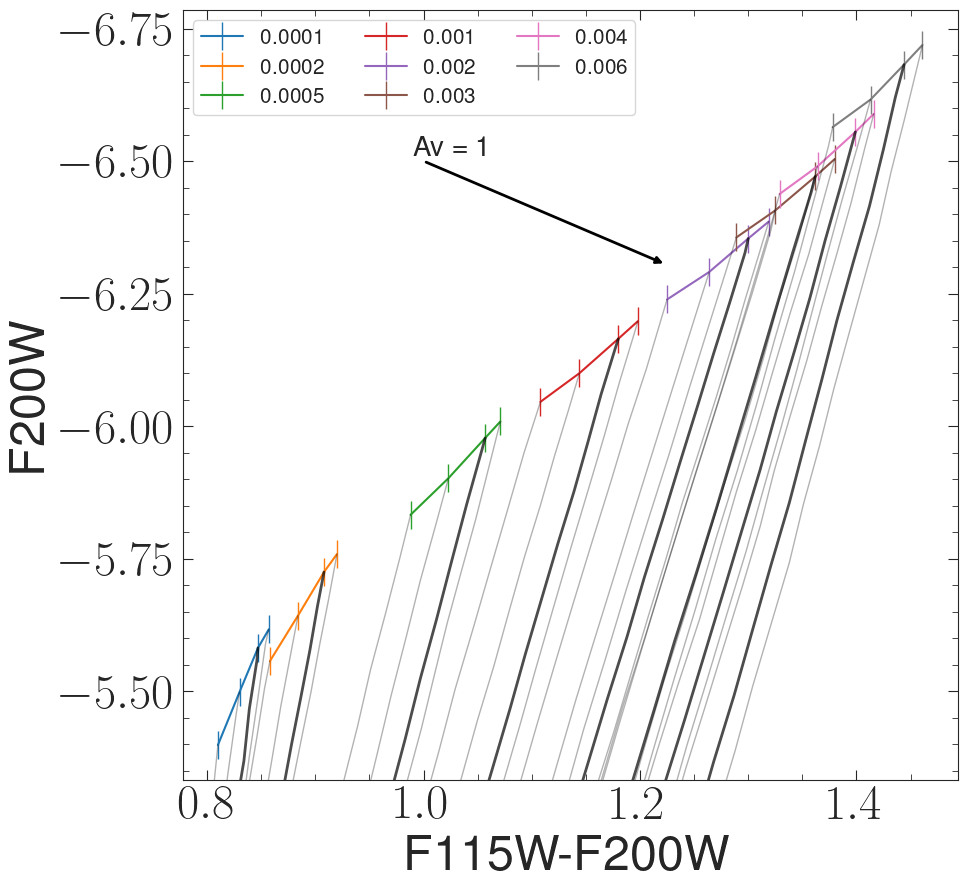

In [141]:
fig, ax = plt.subplots(figsize=(10,10))

ax.plot(col,m, '-|', markersize=20)

ax.xaxis.set_major_locator(AutoLocator())
ax.xaxis.set_minor_locator(AutoMinorLocator())

ax.yaxis.set_major_locator(AutoLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())

ax.tick_params(which='both', length=7,direction="in", bottom=True, top=True,left=True, right=True)
ax.tick_params(which='minor', length=4)
ax.invert_yaxis()

ax.legend([0.0001, 0.0002, 0.0005, 0.001 , 0.002 , 0.003 , 0.004 , 0.006],
         ncols=3, fontsize=15)
ax.set_xlabel(f'{filt1}-{filt2}')
ax.set_ylabel(f'{filt3}')

Av_ = 1
Av_x = 1
Av_y = -6.5

AF1_ =  Av_dict[f'{filt1.lower()}']*Av_
AF2_ =  Av_dict[f'{filt2.lower()}']*Av_
AF3_ =  Av_dict[f'{filt3.lower()}']*Av_

dx = AF1_ - AF2_
dy = AF3_

ax.annotate('', xy=(Av_x, Av_y),
             xycoords='data',
             xytext=(Av_x+dx, Av_y+dy),
             textcoords='data',
             arrowprops=dict(arrowstyle= '<|-',
                             color='black',
                             lw=2,
                             ls='-')
           )

ax.annotate(f'Av = {Av_}', xy=(Av_x-0.01, Av_y-0.01),fontsize=20)

ax.set_ylim(ax.get_ylim()[0], ax.get_ylim()[1])
ax.set_xlim(ax.get_xlim()[0], ax.get_xlim()[1])


for i in [9.6,9.8,10,10.1139]:
    df = df_cmd_jwst[np.round(df_cmd_jwst['logAge'],4)==i]
    df = df[df['label']==3]
    for j in np.array([0.0001, 0.0002, 0.0005, 0.001 , 0.002 , 0.003 , 0.004 , 0.006]):
        df_ = df[df['Zini']==j]
        x = df_[f'{filt1}mag'] - df_[f'{filt2}mag']
        y = df_[f'{filt3}mag']

        mask = (y.values[1:]- y.values[:-1])<1
        mask = np.array([True] + list(mask))
        mask = np.where(~mask, np.nan, 1)

        if i ==10:
            lw = 2
            alpha=0.7
        else:
            lw =1
            alpha=0.3
        ax.plot(x,y*mask, color='black',alpha=alpha,lw=lw) 
        

In [142]:
Av_dict['f200w']*0.19

0.03705

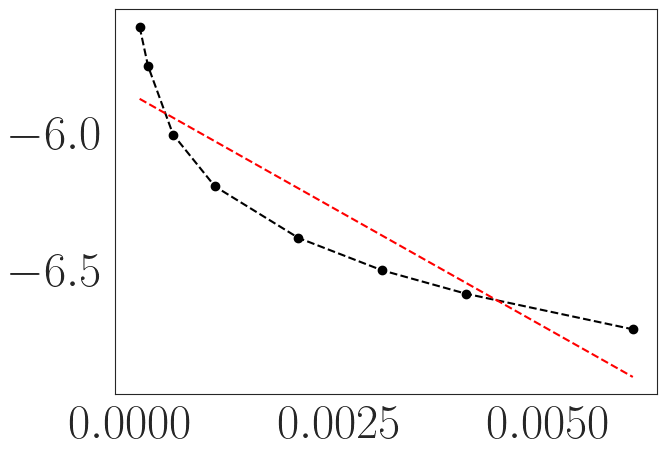

In [157]:
x = np.array([0.0001, 0.0002, 0.0005, 0.001 , 0.002 , 0.003 , 0.004 , 0.006])
y = m[3]

init = models.Linear1D()
fit = fitting.LinearLSQFitter()
model = fit(init, x, y)
plt.plot(x,y, '--ok')
plt.plot(x,model(x),'--r')

In [159]:
np.round(y.max()-y.min(),3)

1.102

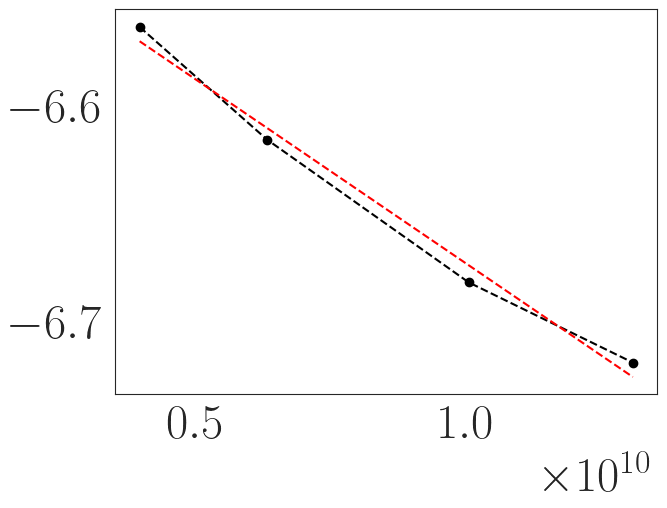

In [148]:
x = 10**np.array([9.6,9.8,10,10.1139])
y = m[:,-1]

init = models.Linear1D()
fit = fitting.LinearLSQFitter()
model = fit(init, x, y)
plt.plot(x,y, '--ok')
plt.plot(x,model(x),'--r')

In [149]:
np.round(y.max()-y.min(),3)

0.155

In [109]:
np.round(model.parameters[0]*1e9,3)

-0.008

In [98]:
ages_ = [6.8,7,7.2, 7.5,7.8,8,8.2,8.5,8.8,9,9.6,10]

ages_y = [6.8, 7.0,7.3,7.6,7.8,8,8.5,8.8]
ages_o = [9.0, 9.4, 9.6,10]
mag_err_lim = 0.2

In [95]:
x = np.array([25.9781503 , 25.74232124, 25.19845565, 24.80504045, 24.53260125,
       23.85941158, 23.47109451, 22.7474432 , 23.53099111, 24.60594044,
       25.0658088 , 25.12595093, 25.5101388 , 25.88185164])

In [ ]:
r_in = 0
r_out = 12

counts = []
crowding = []
for i in [3,9,15,21,27,33,39,45]:
    fig,ax1, tab = gen_CMD('f115w', 'f200w', 'f200w',name = 'ngc628/f115w_f200w',  cmd=df_cmd_jwst, r=None, Av_=1, Av_x=1.5, Av_y=26, xlims=[-0.25,3], ylims=[17,28],
                     out_dir='photometry',gen_kde=False, label=3, met=0.003,dismod=29.95, ages=ages_y+ages_o, r_in=r_in, r_out=r_out, skip_data=False,
                    regions=[f'reg_{i}'],sqr_field=True)
    plt.close(fig)
    crowding.append(np.median(tab['crowd_2'].value))
    counts.append(len(tab))

In [ ]:
y = np.array(counts)/24**2
crowding = np.array(crowding)

In [ ]:
plt.plot(x,y,'-ok')
plt.xlabel(r'$m_{50} (F200W)$')
plt.ylabel(r'$\rho (n/arcsec^2)$')

In [ ]:
plt.plot(x,crowding,'-ok')
plt.xlabel(r'$m_{50} (F200W)$')
plt.ylabel(r'Crowding')

In [ ]:
r_in = 0
r_out = 12
fig,ax1, tab = gen_CMD('f115w', 'f200w', 'f200w',name = 'ngc628/f115w_f200w',  cmd=df_cmd_jwst, r=None, Av_=1, Av_x=2.5, Av_y=26, xlims=[-0.5,4], ylims=[17,28],
                 out_dir='photometry',gen_kde=False, label=10, met=0.003,dismod=29.95, ages=ages_,
                 r_in=r_in, r_out=r_out, sqr_field=True,ang = 114.99508,
                regions=['reg_0'])

fig,ax1, tab1 = gen_CMD('f115w', 'f200w', 'f200w',name = 'ngc628/f115w_f200w',  cmd=df_cmd_jwst, r=None, Av_=1, Av_x=2.5, Av_y=26, xlims=[-0.5,4], ylims=[17,28],
                 out_dir='photometry',gen_kde=False, label=10, met=0.003,dismod=29.95, ages=ages_,
                 r_in=r_in, r_out=r_out, sqr_field=True,ang = 114.99508,
                regions=['reg_1'])

fig,ax1, tab2 = gen_CMD('f115w', 'f200w', 'f200w',name = 'ngc628/f115w_f200w',  cmd=df_cmd_jwst, r=None, Av_=1, Av_x=2.5, Av_y=26, xlims=[-0.5,4], ylims=[17,28],
                 out_dir='photometry',gen_kde=False, label=10, met=0.003,dismod=29.95, ages=ages_,
                 r_in=r_in, r_out=r_out, sqr_field=True,ang = 114.99508,
                regions=['reg_60'])

In [ ]:
x = tab['ra_1']
y = tab['dec_1']

plt.scatter(x,y, marker='.', color='black')

x = tab1['ra_1']
y = tab1['dec_1']

plt.scatter(x,y, marker='.', color='red')

x = tab2['ra_1']
y = tab2['dec_1']

plt.scatter(x,y, marker='.', color='orange')
plt.axis('equal')

plt.xlabel('RA (deg)')
plt.ylabel('Dec (deg)')

In [ ]:
x = tab['mag_vega_F200W']
y = tab['mag_err_2']

fig, ax = plt.subplots()

ax.scatter(x,y,s=0.1, color='black')

ax.set_xlabel('F200W (vega)')
ax.set_ylabel('mag_err')

ax.xaxis.set_major_locator(AutoLocator())
ax.xaxis.set_minor_locator(AutoMinorLocator())

ax.yaxis.set_major_locator(AutoLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())

ax.tick_params(which='both', length=7,direction="in", bottom=True, top=True,left=True, right=True)
ax.tick_params(which='minor', length=4)

In [ ]:
r_in = 0
r_out = 200


fig,ax, tab = gen_CMD('f115w', 'f200w',name='ngc628/f115w_f200w', cmd=df_cmd_jwst, r=None, Av_=1, Av_x=1.6, Av_y=26, xlims=[-1,5], ylims=[17,28],
                 out_dir='photometry',gen_kde=False, label=3, met=0.02,dismod=29.95, ages=ages_y, alpha=0.8, Av=0.19,
                 r_in=r_in, r_out=r_out,
                regions=['galaxy'])

fig,ax, tab = gen_CMD('f115w', 'f200w',name='ngc628/f115w_f200w', cmd=df_cmd_jwst, r=None, Av_=1, Av_x=1.6, Av_y=26,xlims=[-1,5], ylims=[17,28],
                 out_dir='photometry',gen_kde=False, label=3, met=0.003,dismod=29.95, ages=ages_o, alpha=0.8,skip_data=True,Av=0.19,
                 r_in=r_in, r_out=r_out, fig=fig,ax=ax,
                regions=['galaxy'])

r = plt.Rectangle((-0.1,20),0.3,7, edgecolor='cyan', facecolor='none', lw=5
                 ,zorder=500)
ax.add_patch(r)

r = plt.Rectangle((1.2,23.5),0.5,3, edgecolor='red', facecolor='none', lw=5,
                 angle=9,zorder=500)
ax.add_patch(r)

r = plt.Rectangle((1.55,20.9),0.5,2.5, edgecolor='green', facecolor='none', lw=5,
                 angle=9,zorder=500)
ax.add_patch(r)


r = plt.Rectangle((1.35,19),0.4,1.5, edgecolor='blue', facecolor='none', lw=5,
                 angle=9,zorder=500)
ax.add_patch(r)

r = plt.Rectangle((2.2,21),2,3, edgecolor='purple', facecolor='none', lw=5
                 ,zorder=500)
ax.add_patch(r)

r = plt.Polygon([[0.3,21],[1.2,21],[0.4,26.5],[0.3,26.5]], edgecolor='orange', facecolor='none', lw=5
                 ,zorder=500)
ax.add_patch(r)

In [ ]:
x

In [ ]:
x = tab['mag_vega_F200W']
y = tab['mag_err_2']

init = models.Exponential1D()
fit = fitting.LevMarLSQFitter()
model = fit(init, x, y)

plt.scatter(x,y, s=1, color='black')
x_new = np.linspace(20,26)
plt.plot(x_new,model(x_new),'--r')

plt.xlabel('F200W')
plt.ylabel('Mag error')
model(27)

In [ ]:
model.parameters

In [ ]:
model_mag_f200w = models.Exponential1D(1.14741174e-10, 1.27585744e+00)

In [ ]:
model_mag_f200w(27)

In [ ]:
x = tab['mag_vega_F200W']
y = np.sqrt(tab['mag_err_1']**2 + tab['mag_err_2']**2)


init = models.Exponential1D()
fit = fitting.LevMarLSQFitter()
model = fit(init, x, y)

plt.scatter(x,y, s=1, color='black')
x_new = np.linspace(20,26)
plt.plot(x_new,model(x_new),'--r')

plt.xlabel('F200W')
plt.ylabel('Color error (F115W-F200W)')
model(27)

In [ ]:
model.parameters

/home/avinashck/anaconda3/envs/inaoe/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/avinashck/anaconda3/envs/inaoe/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/avinashck/anaconda3/envs/inaoe/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/avinashck/anaconda3/envs/inaoe/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be

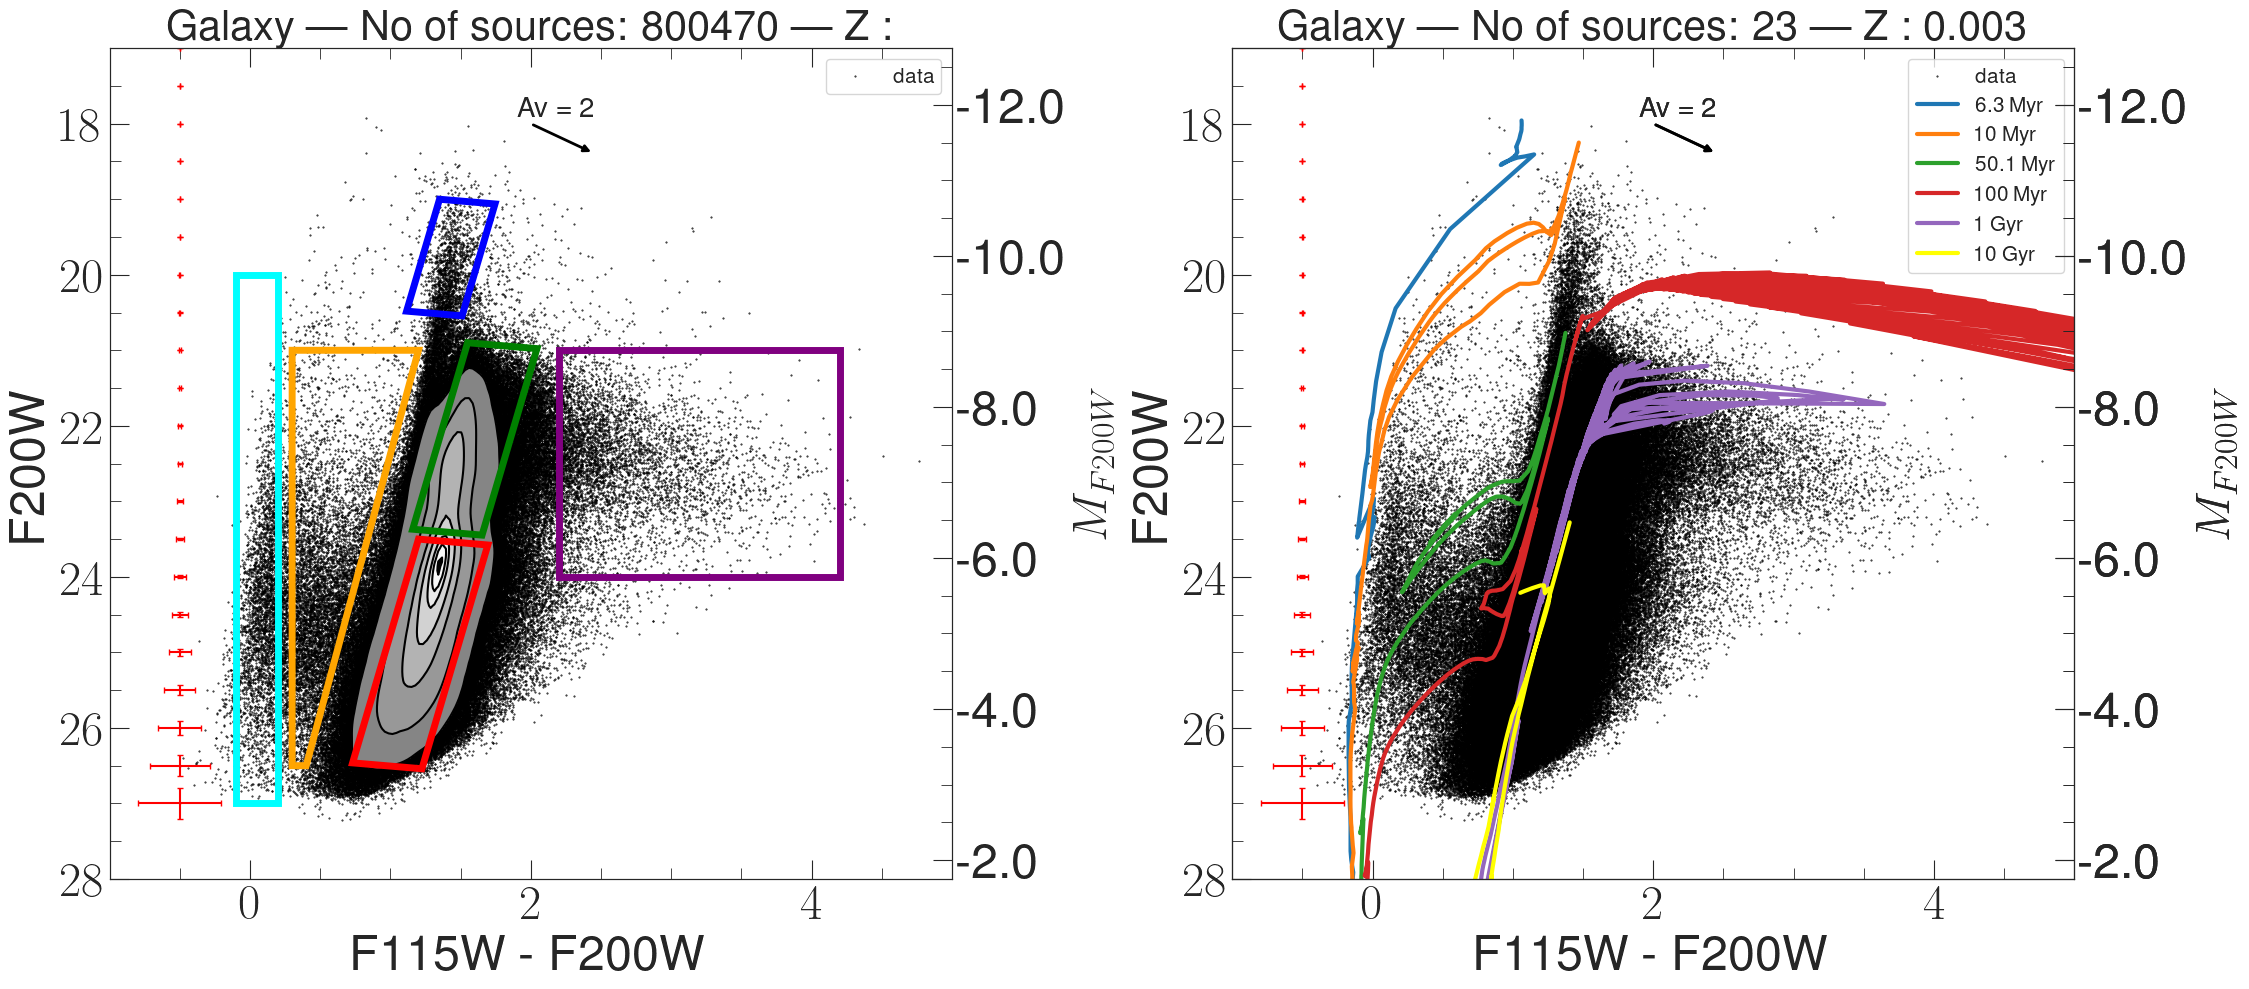

In [132]:
r_in = 0
r_out = 200

fig, ax = plt.subplots(1,2, sharey=False,figsize=(22.6,10))

filt1 = 'f115w'

filt2 = 'f200w'

filt3 = 'f200w'

fig,ax1, tab = gen_CMD(filt1, filt2,filt3, name = f'ngc628/{filt1}_{filt2}',mag_err_lim = 0.2,
                       cmd=None, Av_=2, Av_x=2, Av_y=18, xlims=[-1,5], ylims=[17,28],
                     out_dir='photometry',gen_kde=False,gen_contours=True, label=10, met=0.02,
                    dismod=29.7126, sqr_field=False, r_in=r_in, r_out=r_out, regions=['galaxy'],
                    fig=fig,ax=ax[0],ref_xpos=-0.5)

r = plt.Rectangle((-0.1,20),0.3,7, edgecolor='cyan', facecolor='none', lw=5
                 ,zorder=500)
ax1.add_patch(r)

r = plt.Rectangle((1.2,23.5),0.5,3, edgecolor='red', facecolor='none', lw=5,
                 angle=9,zorder=500)
ax1.add_patch(r)

r = plt.Rectangle((1.55,20.9),0.5,2.5, edgecolor='green', facecolor='none', lw=5,
                 angle=9,zorder=500)
ax1.add_patch(r)


r = plt.Rectangle((1.35,19),0.4,1.5, edgecolor='blue', facecolor='none', lw=5,
                 angle=9,zorder=500)
ax1.add_patch(r)

r = plt.Rectangle((2.2,21),2,3, edgecolor='purple', facecolor='none', lw=5
                 ,zorder=500)
ax1.add_patch(r)

r = plt.Polygon([[0.3,21],[1.2,21],[0.4,26.5],[0.3,26.5]], edgecolor='orange', facecolor='none', lw=5
                 ,zorder=500)
ax1.add_patch(r)

fig,ax2, tab = gen_CMD(filt1, filt2,filt3, name = f'ngc628/{filt1}_{filt2}',mag_err_lim = 0.2,
                       cmd=df_cmd_jwst, r=None, Av_=2, Av_x=2, Av_y=18, xlims=[-1,5], ylims=[17,28],
                 out_dir='photometry',gen_kde=False, label=10, met=0.02,dismod=29.7126, ages=[6.8,7,7.7,8,9],
                 r_in=r_in, r_out=r_out, fig=fig,ax=ax[1],ref_xpos=-0.5,
                regions=['galaxy'])

ax2.set_prop_cycle(color=['yellow'])

fig,ax2, tab1 = gen_CMD(filt1, filt2,filt3, name = f'ngc628/{filt1}_{filt2}',mag_err_lim = 0.2,
                       cmd=df_cmd_jwst, r=None, Av_=2, Av_x=2, Av_y=18, xlims=[-1,5], ylims=[17,28],
                 out_dir='photometry',gen_kde=False, label=10, met=0.003,dismod=29.7126, ages=[10],
                 r_in=r_in, r_out=1, fig=fig,ax=ax2,ref_xpos=-0.5, skip_data=True,
                regions=['galaxy'])


In [130]:
plt.rcParams['axes.prop_cycle'].

['#1f77b4',
 '#ff7f0e',
 '#2ca02c',
 '#d62728',
 '#9467bd',
 '#8c564b',
 '#e377c2',
 '#7f7f7f',
 '#bcbd22',
 '#17becf']

/tmp/ipykernel_14885/3536506228.py:252: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


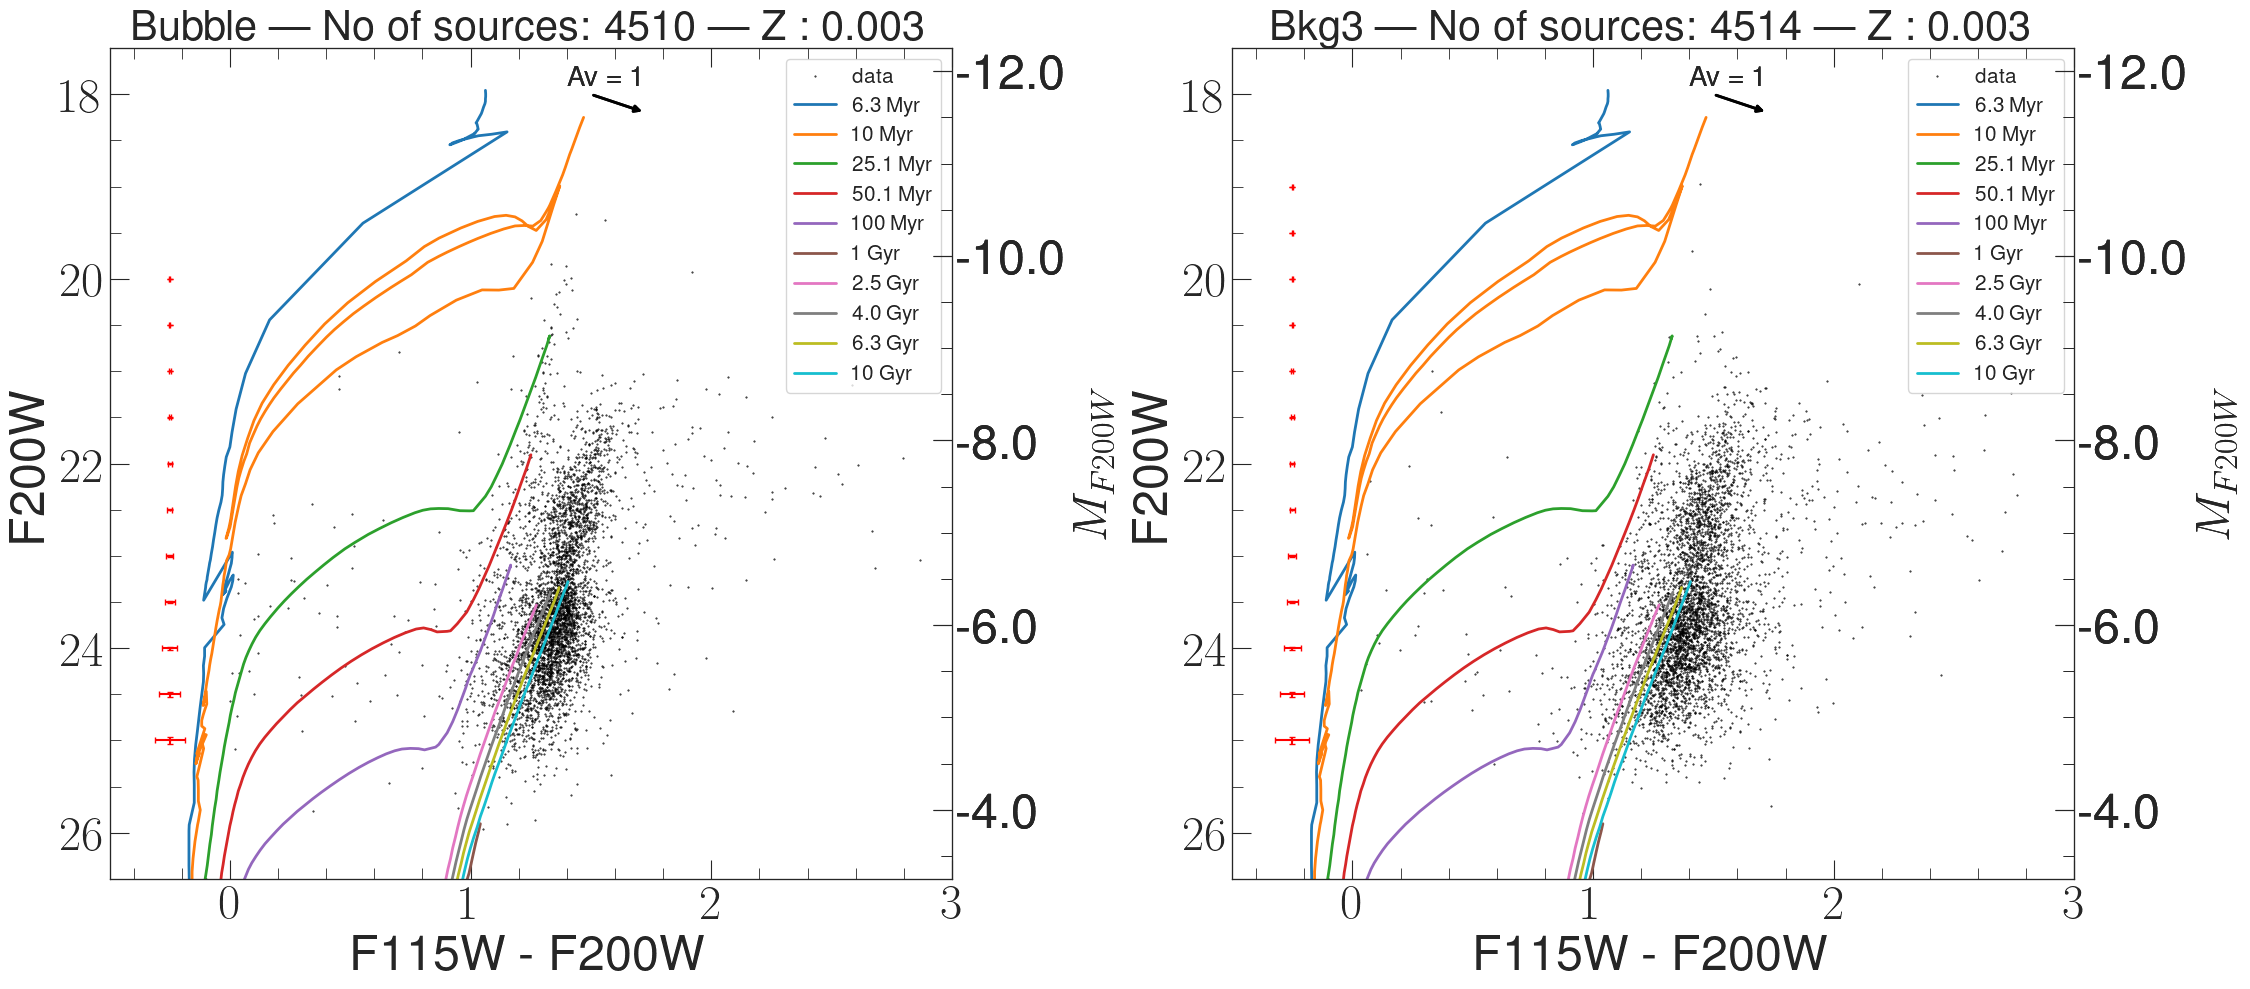

In [182]:
r_in = 0
r_out = 8.9

filt1 = 'f115w'

filt2 = 'f200w'

filt3 = 'f200w'

fig,ax = plt.subplots(1,2, figsize=(22.6,10))

fig,ax1, tab1 = gen_CMD(filt1, filt2,filt3, name = f'ngc628/f115w_f200w',mag_err_lim = 0.2,
                       cmd=df_cmd_jwst, r=None, Av_=1, Av_x=1.5, Av_y=18, xlims=[-0.5,3], ylims=[17.5,26.5],
                 out_dir='photometry',gen_kde=False, label=3, met=0.02,dismod=29.7126, ages=[6.8,7,7.4,7.7,8,9],
                 r_in=r_in, r_out=r_out, ref_xpos=-0.25 ,regions=['bubble'],lw=2, fig=fig, ax=ax[0])

fig,ax1, tab1 = gen_CMD(filt1, filt2,filt3, name = f'ngc628/f115w_f200w',mag_err_lim = 0.2,lw=2,
                       cmd=df_cmd_jwst, r=None, Av_=1, Av_x=1.5, Av_y=18, xlims=[-0.5,3], ylims=[17.5,26.5],
                 out_dir='photometry',gen_kde=False, label=3, met=0.003,dismod=29.7126, ages=[9.4,9.6,9.8,10],
                 r_in=r_in, r_out=r_out, ref_xpos=-0.25 ,regions=['bubble'], fig=fig, ax=ax1, skip_data=True)


fig,ax2, tab1 = gen_CMD(filt1, filt2,filt3, name = f'ngc628/f115w_f200w',mag_err_lim = 0.2,
                       cmd=df_cmd_jwst, r=None, Av_=1, Av_x=1.5, Av_y=18, xlims=[-0.5,3], ylims=[17.5,26.5],
                 out_dir='photometry',gen_kde=False, label=3, met=0.02,dismod=29.7126, ages=[6.8,7,7.4,7.7,8,9],
                 r_in=r_in, r_out=r_out, ref_xpos=-0.25 ,regions=['bkg3'],lw=2, fig=fig, ax=ax[1])

fig,ax2, tab1 = gen_CMD(filt1, filt2,filt3, name = f'ngc628/f115w_f200w',mag_err_lim = 0.2,lw=2,
                       cmd=df_cmd_jwst, r=None, Av_=1, Av_x=1.5, Av_y=18, xlims=[-0.5,3], ylims=[17.5,26.5],
                 out_dir='photometry',gen_kde=False, label=3, met=0.003,dismod=29.7126, ages=[9.4,9.6,9.8,10],
                 r_in=r_in, r_out=r_out, ref_xpos=-0.25 ,regions=['bkg3'], fig=fig, ax=ax2, skip_data=True)

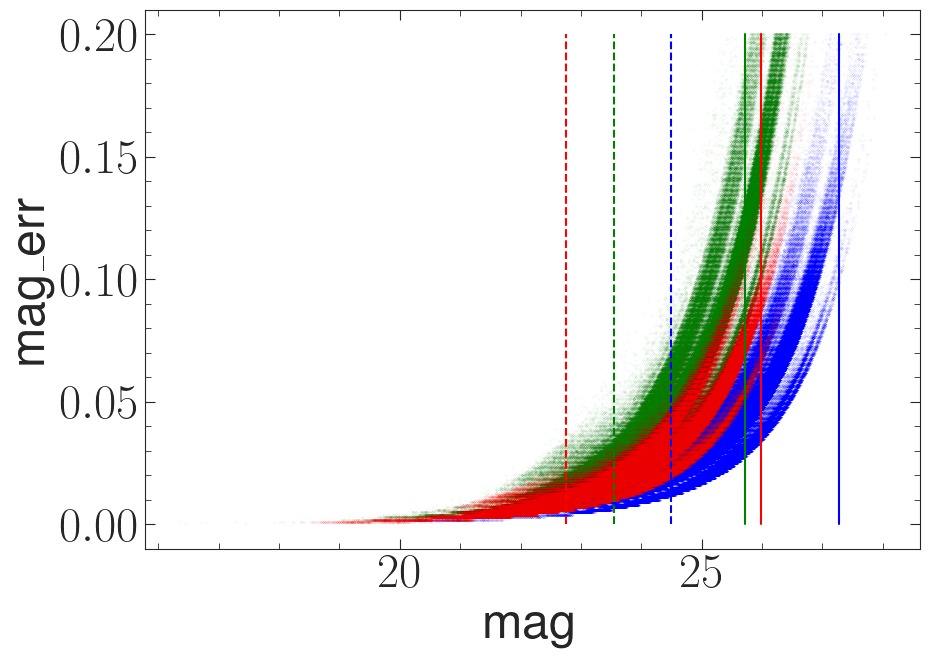

In [122]:
fig, ax = plt.subplots(figsize=(10,7))
x = tab1['mag_vega_F115W']
y = tab1['mag_err']

ax.scatter(x, y, s = 0.001, color='blue')

x = tab1['mag_vega_F150W']
y = tab1['mag_err_1']

ax.scatter(x, y, s = 0.001, color='green')

x = tab1['mag_vega_F200W']
y = tab1['mag_err_2']

ax.scatter(x, y, s = 0.001, color='red')

ax.set_xlabel('mag')
ax.set_ylabel('mag_err')

ax.plot([27.27155834, 27.27155834],[0,0.2], '-b')
ax.plot([24.49524254, 24.49524254],[0,0.2], '--b')


ax.plot([25.71734278, 25.71734278],[0,0.2], '-g')
ax.plot([23.5535029, 23.5535029],[0,0.2], '--g')

ax.plot([25.9781503, 25.9781503],[0,0.2], '-r')
ax.plot([ 22.7474432,  22.7474432],[0,0.2], '--r')

ax.xaxis.set_major_locator(AutoLocator())
ax.xaxis.set_minor_locator(AutoMinorLocator())

ax.yaxis.set_major_locator(AutoLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())

ax.tick_params(which='both', length=7,direction="in", bottom=True, top=True,left=True, right=True)
ax.tick_params(which='minor', length=4)

In [66]:
np.std([29.68,29.73,29.95,30.02,30.04])

0.1500133327407931

In [ ]:
#ages_ = np.round(np.log10([6e6, 1e7,2e7, 3e7, 5e7,1e8,5e8]),1)
ages_ = np.round(np.log10([1e9, 5e9, 1e10]),1)

In [ ]:
r_in = 0
r_out = 10

fig, ax = plt.subplots(1,4, sharey=False,figsize=(44,10))

fig,ax1, tab = gen_CMD('f115w', 'f150w', 'f150w', name = '3004/f115w_f150w_f200w',
                       cmd=df_cmd_jwst, Av_=1, Av_x=-2.5, Av_y=18, xlims=[-0.5,1.5], ylims=[17,28],
                     out_dir='PHOT_OUTPUT_r40.5',gen_kde=True,gen_contours=False, label=3, met=0.003,
                    dismod=30.04, ages=ages_, sqr_field=False, r_in=r_in, r_out=r_out, 
                       regions=['bubble'],
                    fig=fig,ax=ax[0],ref_xpos=-0.5)

fig,ax2, tab = gen_CMD('f150w', 'f200w', 'f200w', name = '3004/f115w_f150w_f200w',
                       cmd=df_cmd_jwst, r=None, Av_=-2.5, Av_x=1.5, Av_y=18, xlims=[-0.5,1.5], ylims=[17,28],
                 out_dir='PHOT_OUTPUT_r40.5',gen_kde=True, label=3, met=0.003,dismod=30.04, ages=ages_,
                 r_in=r_in, r_out=r_out, fig=fig,ax=ax[1],ref_xpos=-0.5,
                regions=['bubble'])

fig,ax3, tab = gen_CMD('f115w', 'f200w', 'f200w',name = '3004/f115w_f150w_f200w',
                       cmd=df_cmd_jwst, r=None, Av_=1, Av_x=1.5, Av_y=18, xlims=[0.5,2.5], ylims=[20,28],
                 out_dir='PHOT_OUTPUT_r40.5',gen_kde=True, label=3, met=0.003,dismod=30.04, ages=ages_,
                 r_in=r_in, r_out=r_out, fig=fig,ax=ax[2],ref_xpos=-0.5,
                regions=['bubble'])

fig,ax4, tab = gen_CMD('f115w', 'f200w', 'f115w',name = '3004/f115w_f150w_f200w',
                       cmd=df_cmd_jwst, r=None, Av_=1, Av_x=1.5, Av_y=18, xlims=[0.5,2.5], ylims=[20,28],
                 out_dir='PHOT_OUTPUT_r40.5',gen_kde=True, label=3, met=0.003,dismod=30.04, ages=ages_,
                 r_in=r_in, r_out=r_out, fig=fig,ax=ax[3],ref_xpos=-0.5,
                regions=['bubble'])

In [ ]:
r_in = 0
r_out = 12

fig, ax = plt.subplots(6,15,figsize=(120,60), sharex=True, sharey=True)

k=0
for i in range(15):
    for j in range(6):
        fig,ax1, _ = gen_CMD('f115w', 'f200w', name = 'ngc628/f115w_f200w', cmd=None, r=None, Av_=1, Av_x=2.5, Av_y=26, xlims=[-0.5,4], ylims=[17,28],
                         out_dir='photometry',gen_kde=False, label=10, met=0.006,dismod=30.04, ages=ages_, sqr_field=True,
                         r_in=r_in, r_out=r_out, fig=fig,ax=ax[5-j,i], ab_dist=False,
                         regions=[f'reg_{k}'])
        if j!=0:
            ax1.set_xlabel(None)
        if i!=0:
            ax1.set_ylabel(None)
        k+=1

### **Extinction Vector**

In [ ]:
23.4+0.025

In [ ]:
filt1 = 'f115w'
filt2 = 'f200w'
r_in  = 0
r_out = 10

dl= 0.05

l_lo = 23 
l_hi = 23.5
cmd_xlo = 0.5
cmd_xhi = 2
fig, ax, dats_bub, x_val, y_val, y_bins = gen_CMD_xcut(filt1, filt2,  name = 'stage2/f115w_f150w_f200w',
                                                       cmd=df_cmd_jwst, label_min=0, label_max=3,
                                                      r_in=r_in, r_out=r_out, age=10, met=0.006,
                                                      l_lo=l_lo, l_hi=l_hi, out_dir='PHOT_OUTPUT_r40.5',
                                                      dl=dl,cmd_xlo=cmd_xlo, cmd_xhi=cmd_xhi,
                                                       region='bubble',
                                                     fit_isochrone=True)


fig, ax, dats_bkg3, x_val, y_val, y_bins = gen_CMD_xcut(filt1, filt2,  name = 'stage2/f115w_f150w_f200w',
                                                        cmd=df_cmd_jwst,label_min=0, label_max=3,
                                                       r_in=r_in, r_out=r_out, age=10, met=0.006,
                                                       l_lo=l_lo, l_hi=l_hi,out_dir='PHOT_OUTPUT_r40.5',
                                                      dl=dl,cmd_xlo=cmd_xlo, cmd_xhi=cmd_xhi,
                                                         region='bkg3',fit_isochrone=True)

In [ ]:
min_ = 1
max_ = 2
step = 0.025
bins = np.arange(min_, max_, step)

init = models.Gaussian1D()
fit = fitting.LevMarLSQFitter()

for i in range(len(y_val)):
    
    fig, ax = plt.subplots()
    dat1 = dats_bub[i][0]
    dat2 = dats_bkg3[i][0]

   # Bubble
    y, x = np.histogram(dat1, bins=bins)
    max_bub = y.max()
    
    x = 0.5*(x[1:] + x[:-1])
    
    ax.step(x,y, where='mid', color='black')
    
    model = fit(init,x,y)
    xn = np.linspace(x.min(),x.max(),1000)
    
    ax.plot(xn,model(xn),'-b')
    
    x_p1 = model.mean.value
    s_p1 = model.stddev.value
    ax.plot([x_p1, x_p1],[0,model.amplitude.value], '--b')
    
    # Bkg3
    y, x = np.histogram(dat2, bins=bins)
    
    max_bkg3 = y.max()
    
    x = 0.5*(x[1:] + x[:-1])
    
    ax.step(x,y, where='mid', color='gold')
    
    model = fit(init,x,y)
    xn = np.linspace(x.min(),x.max(),1000)
    ax.plot(xn,model(xn),'-', color='orange')
    
    x_p3 = model.mean.value
    s_p3 = model.stddev.value
    ax.plot([x_p3, x_p3],[0,model.amplitude.value], '--', color='orange')
    
    max_ = np.max([max_bub,  max_bkg3])
    
    
    ax.plot([x_val[i], x_val[i]], [0, max_+10],'-g',linewidth=3)
    title = f"{np.round(y_bins[i],2)} - {np.round(y_bins[i+1],3)} (mag)| "
    title += r"$\mu_{bubble} :$" + f"{np.round(x_p1,3)}" + r" $\mu_{bkg3} :$" + f"{np.round(x_p3,3)} " 
    
    title += r'$\sigma_{bubble} : $ ' + f"{np.round(s_p1,3)} " + r' $\sigma_{bkg3} : $ ' + f"{np.round(s_p3,3)}\n"
    title +=  r"$\ dist_{bub,ref}$ : " + f"{np.round(x_p1 - x_val[i],3)}  " 
    title +=   r"$\ dist_{bkg3,ref}$ : " + f"{np.round(x_p3 - x_val[i],3)}"
    
    ax.set_title(title, fontsize=15)
    ax.set_ylabel('Counts', fontsize=15)
    ax.legend(['Bubble', 'Bubble Gaussian Fit', 'Bubble mean', 'Bkg3', 'Bkg3 Gaussian Fit', 'Bkg3 mean',
                 'Reference line'])
    
    ax.set_xlabel('Color');
    plt.show()

### **TRGB**

#### **Magnitude**

In [164]:
filt1 = 'f115w'
filt2 = 'f200w'
filt3 = 'f200w'

r_in  = 0
r_out = 12

if filt3 == 'f200w':
    dl= 0.25
elif filt3 == 'f115w':
    dl = 0.25
elif filt3== 'f150w':
    dl = 0.25
    
l_lo = 19
l_hi = 28

if filt3 == 'f200w':
    cmd_xlo = 1.25
    y0 = 23.5
elif filt3 == 'f115w':
    cmd_xlo = 1.25
    y0 = 24.8
elif filt3 == 'f150w':
    cmd_xlo = 1.23
    y0 = 24.

cmd_xhi = cmd_xlo + dl*1.1

nx = 15
ny = 6


if filt3 == 'f200w':
    col_lims = [23.20, 23.7]
    
elif filt3 == 'f115w':
    col_lims = [24.4, 25.1]
    
elif filt3 == 'f150w':
    col_lims = [23.5, 24.3]

k = 12

mss = []
for b in np.arange(0.001,0.0101,0.001):
    bins = np.arange(l_lo, l_hi, b)
    ms = []
    for sigma_s in np.arange(0.05,0.101,0.01):

        fig = plt.figure(figsize=(14, 9))
        gs = fig.add_gridspec(1, 3,  width_ratios=(4, 1,1),
                              left=0.1, right=0.9, bottom=0.1, top=0.9,
                              wspace=0.05, hspace=0.05)

        ax =  fig.add_subplot(gs[0, 0])

        fig, ax, dats_bub, x_val, y_val, y_bins,params = gen_CMD_ycut(filt1, filt2, filt3, name= 'ngc628/f115w_f200w',
                                                              region=f'reg_{k}',cmd=df_cmd_jwst, 
                                                              r_in=r_in, r_out=r_out, label=3,
                                                              met=0.003, sqr_field=True, mag_err_lim=0.2,
                                                              age=10, fig=fig, ax=ax, gen_kde=True,
                                                              l_lo=l_lo, l_hi=l_hi, out_dir='photometry',
                                                              dl=dl, cmd_xlo=cmd_xlo, cmd_xhi=cmd_xhi,
                                                               xlims=[0.,3], ylims=[21,27], y0=y0,
                                                              fit_isochrone=True, perp_iso=True, dismod=29.7126)

        ax_hist = fig.add_subplot(gs[0, 1], sharey=ax)
        ax_edge = fig.add_subplot(gs[0, 2], sharey=ax)


        for dat in dats_bub:
            x = dat[0]
            y = dat[1]

            yh,xh,_, = ax_hist.hist(y,bins, orientation='horizontal' , histtype='step', color='grey')
            xh = 0.5*(xh[1:] + xh[:-1])
            #yf = gaussian_filter(yh,5) 

            yf = gloess(xh,yh,sigma_s,1)
            ysob = np.convolve(yf,np.array([-1,0,1]), mode='same')

            ax_hist.plot(yf, xh, color='black')
            ax_edge.plot(ysob, xh,'b')
            
            c1 = (xh>=col_lims[0]) & (xh<=col_lims[1])
            m = xh[c1][ysob[c1]==ysob[c1].min()][0]

            ax_hist.tick_params(axis="y", labelleft=False)
            ax_edge.tick_params(axis="x", labelbottom=False)
            ax_edge.tick_params(axis="y", labelleft=False)

            ax_edge.set_title(f'{filt3.upper()}'+ '$_{TRGB}$' f': {np.round(m,5)}', fontsize=12)
            ax.plot([0,3],[m,m],'--k', zorder=201)
            ax_hist.plot([0,yh.max()],[m,m],'--k',label=f'{filt3.upper()}'+ '$_{TRGB}$')
            ax_hist.legend()
            ax_hist.set_xticks([np.ceil(yh.max())],[np.ceil(yh.max())])
            ax_hist.tick_params(axis='both', labelsize=15)
            dismod = m - params[0]-params[1]
            ax_hist.set_title(f'DM : {np.round(dismod, 3)}', fontsize=15)
            ax_edge.plot([ysob.min(),ysob.max()],[m,m],'--k')
            ax_edge.set_xlim([ysob.min()*1.1,0])
            #ax_edge.invert_xaxis()

            for ax_ in [ax_hist, ax_edge]:
                ax_.xaxis.set_major_locator(AutoLocator())
                ax_.xaxis.set_minor_locator(AutoMinorLocator())

                ax_.yaxis.set_major_locator(AutoLocator())
                ax_.yaxis.set_minor_locator(AutoMinorLocator())

                ax_.tick_params(which='both', length=7,direction="in", bottom=True, top=True,left=True, right=True)
                ax_.tick_params(which='minor', length=4)

            fig.tight_layout()
            fig.savefig(f"TRGB/{filt3}/bubble_{filt3}_{k}_{sigma_s}_{b}_mag.png")
            plt.close(fig) 
        
        ms.append(m)
    mss.append(ms)

print(k)

/tmp/ipykernel_1437/3545360784.py:115: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


12


In [ ]:
m_t = np.array(mss)[:,:]
np.nanmedian(m_t), np.nanstd(m_t), np.nanmedian(m_t) - params[0] - params[1]

In [ ]:
bins = np.arange(0.001, 0.011, 0.001)

for n, i in enumerate(m_t.T):
    
    plt.plot(bins, i, '-o')
    plt.legend(np.arange(0.05, 0.11, 0.01))

In [ ]:
reg_block = reg_arr[10:,3:]
reg_block = list([ [f'reg_{int(j)}' for j in i] for i in reg_block])

In [ ]:
reg_block = [['bubble', 'reg_27', 'reg_63'],
             ['reg_3', 'reg_33', 'reg_69'],
             ['reg_9', 'reg_39', 'reg_75'],
             ['reg_15', 'reg_51', 'reg_81'],
             ['reg_21', 'reg_57', 'reg_87']]

In [ ]:
reg_block = [['reg_4', 'reg_13', 'reg_28'],
             ['reg_32', 'reg_52', 'reg_60'],
             ['reg_63', 'reg_66', 'reg_78'],
             ['reg_84', 'bubble', 'bubble'],
             ['bubble', 'bubble', 'bubble']]

In [ ]:
reg_block

In [ ]:
filt1 = 'f115w'
filt2 = 'f200w'
filt3 = 'f200w'

r_in  = 0
r_out = 12

if filt3 == 'f200w':
    dl= 0.25
elif filt3 == 'f115w':
    dl = 0.25
elif filt3== 'f150w':
    dl = 0.25
    
l_lo = 19
l_hi = 28

if filt3 == 'f200w':
    cmd_xlo = 1.25
    y0 = 23.5
elif filt3 == 'f115w':
    cmd_xlo = 1.25
    y0 = 24.8
elif filt3 == 'f150w':
    cmd_xlo = 1.23
    y0 = 24.

cmd_xhi = cmd_xlo + dl*1.1

nx = 15
ny = 6

if filt3 == 'f200w':
    col_lims = [23.20, 23.7]
    
elif filt3 == 'f115w':
    col_lims = [24.4, 25.1]
    
elif filt3 == 'f150w':
    col_lims = [23.5, 24.3]


fig, ax = plt.subplots(3,5,figsize=(25, 15),sharex=True, sharey=True)


for i in range(3):
    for j in range(5):
        ms = []
        k = reg_block[j][i]
        
        if k =='bubble':
            r_out=8
            k_id = 'bubble'
        else:
            r_out = 12
            k_id = float(k.split('_')[-1])
            
        ysobs = []
        for b in np.arange(0.001,0.011,0.001):
            for sigma_s in np.arange(0.05,0.11,0.01):
                
                if not os.path.exists(f'{k_id}_{b}_{sigma_s}.npy'):
                    fig1, ax1, dats_bub, x_val, y_val, y_bins,params = gen_CMD_ycut(filt1, filt2, filt3, name= 'ngc628/f115w_f200w',
                                                                  region=k,cmd=df_cmd_jwst, 
                                                                  r_in=r_in, r_out=r_out, label=3,
                                                                  met=0.003, sqr_field=True, mag_err_lim=0.2,
                                                                  age=10, gen_kde=True,
                                                                  l_lo=l_lo, l_hi=l_hi, out_dir='photometry',
                                                                  dl=dl, cmd_xlo=cmd_xlo, cmd_xhi=cmd_xhi,
                                                                   xlims=[0.,3], ylims=[21,27], y0=y0,
                                                                  fit_isochrone=True, perp_iso=True, dismod=29.714)
                    np.save(f'{k_id}_{b}_{sigma_s}.npy', dats_bub)
                    plt.close(fig1)
                    
                else:
                    dats_bub = np.load(f'{k_id}_{b}_{sigma_s}.npy')
                
                for dat in dats_bub:
                    x = dat[0]
                    y = dat[1]
                    
                    bins = np.arange(l_lo, l_hi, b)
                    yh,xh= np.histogram(y,bins)  
                    xh = 0.5*(xh[1:] + xh[:-1])

                    yf = gloess(xh,yh.astype(np.float64),sigma_s,1)
                    ysob = np.convolve(yf,np.array([-1,0,1]), mode='same')
                     
                    ax[i,j].plot(xh,ysob/ysob.min(),'-k', alpha=0.5, lw=2) 
                    
                    xn = np.arange(l_lo, l_hi, 0.001)
                    xn= 0.5*(xn[1:] + xn[:-1])  
                    ysob = np.interp(xn,xh,ysob)            
                    ysobs.append(ysob)
                    
        ysobs = np.array(ysobs)
        ysob = np.median(ysobs, axis=0)

        ax[i,j].plot(xn,ysob/ysob.min(),'r', lw=4) 
        if k == 'bubble':
            x = bubble_f200w
            xerr = 0.00789 
        else:
            x = trgb_f200w_mag[np.where(reg_arr==k_id)][0]
            xerr = trgb_f200w_err[np.where(reg_arr==k_id)][0]
            k_id = int(k_id)

        ax[i,j].plot([x,x],[0,1.4], '--k',zorder=100,alpha=0.8,lw=2)

        ax[i,j].plot([bubble_f200w,bubble_f200w],[0,1.4], '-g', alpha=0.8,zorder=195)

        ax[i,j].bar(x,1.4,2*xerr, color='yellow',alpha=0.7, zorder=10)

        ax[i,j].set_xlim(22.8,23.9)

        ax[i,j].set_ylim(0,1.4)
        ax[i,j].annotate(k_id,(23.75-len(str(k_id))*1.5e-2,1.25), color='red', fontsize=17, zorder=400)

        ax[i,j].errorbar([bubble_f200w],[1.05],xerr=np.atleast_2d([0.1398, 0.2502]).T,
                         fmt='.k',elinewidth=2,markersize=4, capsize=7, zorder=300)

        ax[i,j].errorbar([bubble_f200w],[1.05],xerr=np.atleast_2d([0.0558, 0.0612]).T,
                         fmt='.k',elinewidth=2,markersize=4, capsize=7, zorder=300)

        AF =  Av_dict['f200w']*1

        ax[i,j].annotate('', xy=(bubble_f200w, 1.2),
                     xycoords='data',  weight='bold',
                     xytext=(bubble_f200w+AF, 1.2),
                     textcoords='data',
                     arrowprops=dict(arrowstyle= '<|-',
                                     color='black',
                                     lw=2,
                                     ls='-'), zorder=400
                   )


        ax[i,j].annotate(f'Av = {1}', xy=(bubble_f200w+0.01, 1.25),
                     xycoords='data', weight='bold', fontsize=20,
                     textcoords='data', zorder=300, color='black'
                   )

        ax[i,j].annotate(f'Z', xy=(bubble_f200w+0.01, 1.1),
                     xycoords='data', color='black', weight='bold',
                     textcoords='data', zorder=300,fontsize=20,
                   )

        ax[i,j].xaxis.set_major_locator(AutoLocator())
        ax[i,j].xaxis.set_minor_locator(AutoMinorLocator())

        ax[i,j].tick_params(which='both', length=10,direction="in", bottom=True, top=True,left=True, right=True)
        ax[i,j].tick_params(which='minor', length=6)

        for spine in ax[i,j].spines.values():
            spine.set_linewidth(3) 
        

fig.text(0.5, 0.04, 'F200W', ha='center', fontsize=20)

plt.subplots_adjust(hspace=0,wspace=0)

In [33]:
# Magnitude error at TRGB
model_mag_err_f200w = models.Exponential1D(1.87077026e-10, 1.31284337e+00)

# Color error at TRGB
model_col_err = models.Exponential1D(9.72187779e-10, 1.39331541e+00)

bubble_f200w     = 23.3345
bubble_f200w_err = np.sqrt(0.00789**2 + model_mag_err_f200w(bubble_f200w)**2)

trgb_f200w_mag = np.array([[23.4575, 23.465, 23.525, 23.6050, 23.53075, 23.4455],
                           [23.47325, 23.5937, 23.53775, 23.37175, 23.4595, 23.4955],
                           [23.49150, 23.47599, 23.37425, 23.4370,  23.44150,  23.4625],
                           [23.46975, 23.4295,  23.49925,  23.385,  23.431749, 23.443749],
                           [23.45500, 23.4599,  23.46250,  23.429499,  23.417249,  23.39850],
                           [23.38749, 23.4650,  23.385,  23.347999,  23.34799,  23.38225],
                           [23.36050,  23.4332500,  23.309500,  23.2282499,  23.2845, 23.2465],
                           [ 23.5192499,  23.3965,  np.nan,  np.nan,  23.2630,  23.39699], #23.519249
                           [ 23.395999,  23.31325, 23.35599,  23.2995,  23.26950, 23.47825],
                           [ 23.3065,  23.292499,  23.43775,  23.35150,  23.40875,  23.394499],
                           [ 23.28399,  23.47500,  23.468500,  23.39599,  23.425000,  23.46250],
                           
                           [ 23.46250,  23.46824999,  23.49050, 23.4262499,  23.45350, 23.52225],
                           [ 23.50899,  23.45050,  23.34550,  23.4325,  23.46225,  23.46375],
                           [ 23.43625,  23.4850,  23.555000,  23.46824,  23.55475,  23.4420],
                           [ 23.50550,  23.59750,  23.5270,  23.4850,  23.525250,  np.nan]])

trgb_f200w_err = np.array([[0.00955,  0.0067,  0.0054,  0.0084,  0.0052,  0.0089],
                           [0.0035,  0.01058,  0.00536, 0.004534, 0.0044,  0.0043],
                           [0.0054,   0.0039,  0.005345,  0.01514, 0.00475,  0.005595],
                           [0.00513,  0.02502,  0.00270,  0.00997, 0.0051495, 0.027913],
                           [ 0.005,  0.005885,  0.00442,  0.011658926,  0.00768,  0.00431],
                           [ 0.006399,  0.00402,  0.00989,  0.007429,  0.003502,  0.002646],
                           [0.01167,  0.008600,  0.002720,  0.0097,  0.016770, 0.01544],
                           [ 0.0063944,  0.002316,  np.nan,  np.nan, 0.01056, 0.010498],
                           [ 0.01133511, 0.0074,  0.00767,  0.01290, 0.0085117, 0.008598],
                           [ 0.013819,  0.009427,   0.009764,  0.00821,  0.0141245,  0.00789011],
                           [ 0.006389,  0.005485,  0.005807,  0.00734773,  0.00714082, 0.0028327],
                           
                           [ 0.003719,  0.0094440,  0.00442574, 0.00900,  0.001789553,  0.0037],
                           [ 0.0062077,  0.00649018,  0.00708,  0.00833,  0.00646,  0.02307],
                           [ 0.0020,  0.0028603,  0.0020,  0.015136,  0.00410,   0.00591],
                           [ 0.006115,  0.002079,  0.007883,  0.0038,  0.00725219,  np.nan]])

trgb_f200w_err = np.sqrt(model_mag_err_f200w(trgb_f200w_mag)**2 + trgb_f200w_err**2)

Doubt 71

In [34]:
bubble_f115w     = 24.785
bubble_f115w_err = 0.0062

trgb_f115w_mag = np.array([[24.8545, 24.8557, 24.9077, 25.0250, 24.903, 24.86749],
                           [24.8329, 24.9319, 24.9220, 24.8900, 24.83475, 24.8749],
                           [24.8529, 24.94475, 25.0935, 24.9198, 24.8465,  24.851999],
                           [ 24.84850,  24.8905,  24.84575,  24.914249,  25.015,  24.82400],
                           [ 24.947999,  24.89425,  24.860749,  24.819999,  24.804750,  24.866749],
                           [ 24.893249,  24.835250,  24.7930,  24.8485,  24.82750,  24.697249],
                           [ 24.8445,  24.885250,  np.nan,  np.nan,  np.nan,  np.nan],
                           [ np.nan,  np.nan,  np.nan,  np.nan,  np.nan,  np.nan],
                           [ 24.79950,  np.nan,  np.nan,  np.nan,  24.79375,  24.799500],
                           [ 24.782749,  24.8774999,  24.8905,  24.75100,  24.87075,  24.9100],
                           [ 24.947749,  24.8895,  24.862500,  24.89050,  24.86950,  24.85749],
                           [ 24.83325,  24.890250,  24.835750,  24.80399,  24.82550,  24.8974999],
                           [ 24.83650,  24.914999,  24.96500,  24.85900,  24.81100,  24.8545],
                           [ 24.864250,  24.867749,  24.948999,  24.9350,  24.923249,  24.80175],
                           [ 24.915999,  24.982499, 24.93050,  24.883999,  24.8550,  25.0450]])

trgb_f115w_err = np.array([[0.0037,  0.0080,  0.0081,  0.0083, 0.0084, 0.0094],
                           [0.0106,  0.0114,  0.00695, 0.0149, 0.0117, 0.01469],
                           [0.0018,  0.01113, 0.0095,  0.0156, 0.0031,  0.00652],
                           [0.00266, 0.00355, 0.00126,  0.005261,  0.009413, 0.005506],
                           [0.0083595,  0.002936,  0.00395,   0.00794,  0.004538,  0.00480],
                           [0.007299,  0.00282690,  0.0064,  0.002324,  0.00114,  0.00606],
                           [0.00533,  0.001123,  np.nan, np.nan,  np.nan,  np.nan],
                           [np.nan,  np.nan,  np.nan,  np.nan,  np.nan,  np.nan],
                           [ 0.0023,   np.nan,  np.nan,  np.nan,  0.01046,  0.00276],
                           [ 0.0031679,  0.002494,  0.001929,  0.00310,  0.0160412,  0.020460],
                           [ 0.0051674,  0.0062207,  0.0079311,  0.00734773,  0.007624,  0.00735921],
                           [ 0.0085020,  0.0031088,  0.0057223,  0.00722214,  0.00694712,  0.0034528],
                           [ 0.006362,  0.01984071,  0.004908,  0.003784,  0.004950,  0.00834],
                           [ 0.01120,  0.00610020,  0.00794300,  0.00728,  0.00887969,  0.007523303],
                           [ 0.0080,  0.0041686, 0.012921,  0.003969,  0.00814590,  0.0071235]])

In [35]:
trgb_mags_J = trgb_f115w_mag#np.load('TRGB/trgb_mags_f115w.npy')
trgb_mags_K = trgb_f200w_mag#np.load('TRGB/trgb_mags_f200w.npy')'

In [36]:
mags_f115w = []
mags_f200w = []

ages__ = [9.6,9.8,10.00001]
for age in ages__:
    mags1 = []
    mags2 = []
    for met in [0.001,0.002,0.003,0.004,]:
        df = df_cmd_jwst[ (df_cmd_jwst['logAge']==age) & (df_cmd_jwst['Zini']==met) & (df_cmd_jwst['label']<=3)]

        t = df[df['F115Wmag']==df['F115Wmag'].min()]
        mag = t['F115Wmag'].values[0]       
        mags1.append(mag)
        
        t = df[df['F200Wmag']==df['F200Wmag'].min()]
        mag = t['F200Wmag'].values[0]       
        mags2.append(mag)
        
    mags_f115w.append(mags1)
    mags_f200w.append(mags2)

mags_f115w = np.array(mags_f115w)
mags_f200w = np.array(mags_f200w)

In [37]:
yy, xx  =np.mgrid[0:5,0:15]

In [38]:
z = (xx-7)**2 + (yy-2)**2

In [39]:
nx = 15
ny = 6

k=0
reg_arr = np.zeros_like(trgb_mags_J[:,:])
for i in range(nx):
    for j in range(ny):
        reg_arr[i,j]=k
        k+=1

In [40]:
reg_arr

array([[ 0.,  1.,  2.,  3.,  4.,  5.],
       [ 6.,  7.,  8.,  9., 10., 11.],
       [12., 13., 14., 15., 16., 17.],
       [18., 19., 20., 21., 22., 23.],
       [24., 25., 26., 27., 28., 29.],
       [30., 31., 32., 33., 34., 35.],
       [36., 37., 38., 39., 40., 41.],
       [42., 43., 44., 45., 46., 47.],
       [48., 49., 50., 51., 52., 53.],
       [54., 55., 56., 57., 58., 59.],
       [60., 61., 62., 63., 64., 65.],
       [66., 67., 68., 69., 70., 71.],
       [72., 73., 74., 75., 76., 77.],
       [78., 79., 80., 81., 82., 83.],
       [84., 85., 86., 87., 88., 89.]])

#### **TRGB Color**

In [ ]:
filt1 = 'f115w'
filt2 = 'f200w'
filt3 = 'f200w'

dl= 0.04
cmd_xlo = 1.2
cmd_xhi = 1.6

r_in  = 0
r_out = 12
dats = []
nx = 15
ny = 6
trgb_cols = np.zeros((nx,ny,7))*np.nan
k = 0

min_ = cmd_xlo
max_ = cmd_xhi
step = 0.01

bins = np.arange(min_, max_, step)
init = models.Gaussian1D()
fit = fitting.LevMarLSQFitter()

for i in range(nx):
    for j in range(ny):
        m = trgb_mags_K[i,j]
        
        if np.isnan(m):
            print(k)
            k += 1
            continue
            
        l_lo = m - 0.01
        l_hi = m + 0.03
        dats = []
        fig, ax = plt.subplots(1,2,figsize=(16, 8))
        _, _, dat, x_val, y_val, y_bins = gen_CMD_xcut(filt1, filt2, filt3,name= 'ngc628/f115w_f200w', cmd=df_cmd_jwst,
                                                           label_min=2, label_max=3, Av_=1, Av_x=1.5,Av_y=23.5,
                                                           r_in=r_in, r_out=r_out, age=10., met=0.003, sqr_field=True,
                                                           l_lo=l_lo, l_hi=l_hi, out_dir='photometry',
                                                           dl=dl, cmd_xlo=cmd_xlo, cmd_xhi=cmd_xhi,
                                                           cmd_ylo=23, cmd_yhi=25,
                                                           fit_slope=True,
                                                           region=f'reg_{k}',xlims=[0,3],ylims=[22, 26],
                                                           fit_isochrone=True, dismod=29.75,
                                                           fig=fig, ax=ax[0])
        #plt.close(fig)
        dats.append(dat)


        dat = dats[0][0][0]

        y, x = np.histogram(dat, bins=bins)
        
        max_bub = y.max()

        x = 0.5*(x[1:] + x[:-1])
        
        ax[1].step(x,y, where='mid', color='black')
        
        model = fit(init, x,y)
        ax[1].plot(np.linspace(min_, max_,100), model(np.linspace(min_, max_,100)),'-r')
       
        mean, median, stddev= sigma_clipped_stats(dat, sigma=2, cenfunc=biweight_location, stdfunc=biweight_scale, maxiters=10)

        p = x[y==y.max()][0]
        x_p1 = mean
        s_p1 = stddev

        ax[1].plot([x_p1, x_p1],[0,y.max()], '--b')

        title = ''
        title += r"$Biweighted_{\mu}:$ " + f"{np.round(x_p1,4)} | "
        title += r'$Biweighted_{\sigma}:$ ' + f"{np.round(s_p1,4)}"
        title += r' | $Peak :$' + f' {np.round(p,4)}\n'
        title += r' $Gaussian_{\mu}: $' + f' {np.round(model.mean.value,4)} | '
        title += r' $Gaussian_{\sigma}: $' + f' {np.round(model.stddev.value,4)}'
        

        ax[1].set_title(title, fontsize=15)
        ax[1].set_ylabel('Counts', fontsize=15)

        ax[1].set_xlabel(f'{filt1.upper()}-{filt2.upper()}')

        trgb_cols[i,j,0] = p   # Peak
        trgb_cols[i,j,1] = mean # Bi weighted mean
        trgb_cols[i,j,2] = np.mean(dat) # Mean color
        trgb_cols[i,j,3] = median # Bi weighted median
        
        trgb_cols[i,j,4] = model.mean.value # Gaussian Mean
        trgb_cols[i,j,5] = model.stddev.value
        trgb_cols[i,j,6] = len(dat)
        ax[1].legend(['Data','Gaussian Fit',f'Biweighted Mean of {len(dat)}'])
        #fig.savefig(f"TRGB/reg{k}_color.png")
        plt.close(fig)
        k+=1
print("Completed!")

In [105]:
#np.save('TRGB/trgb_cols_JK.npy', trgb_cols)

In [41]:
bubble_col = np.array([1.35500000e+00, 1.37743939e+00, 1.36598795e+00, 1.37500000e+00,
       1.37825104e+00, 6.19607834e-02, 8.30000000e+01])

In [42]:
trgb_cols = np.load('TRGB/trgb_cols_JK.npy')

Text(0, 0.5, 'y')

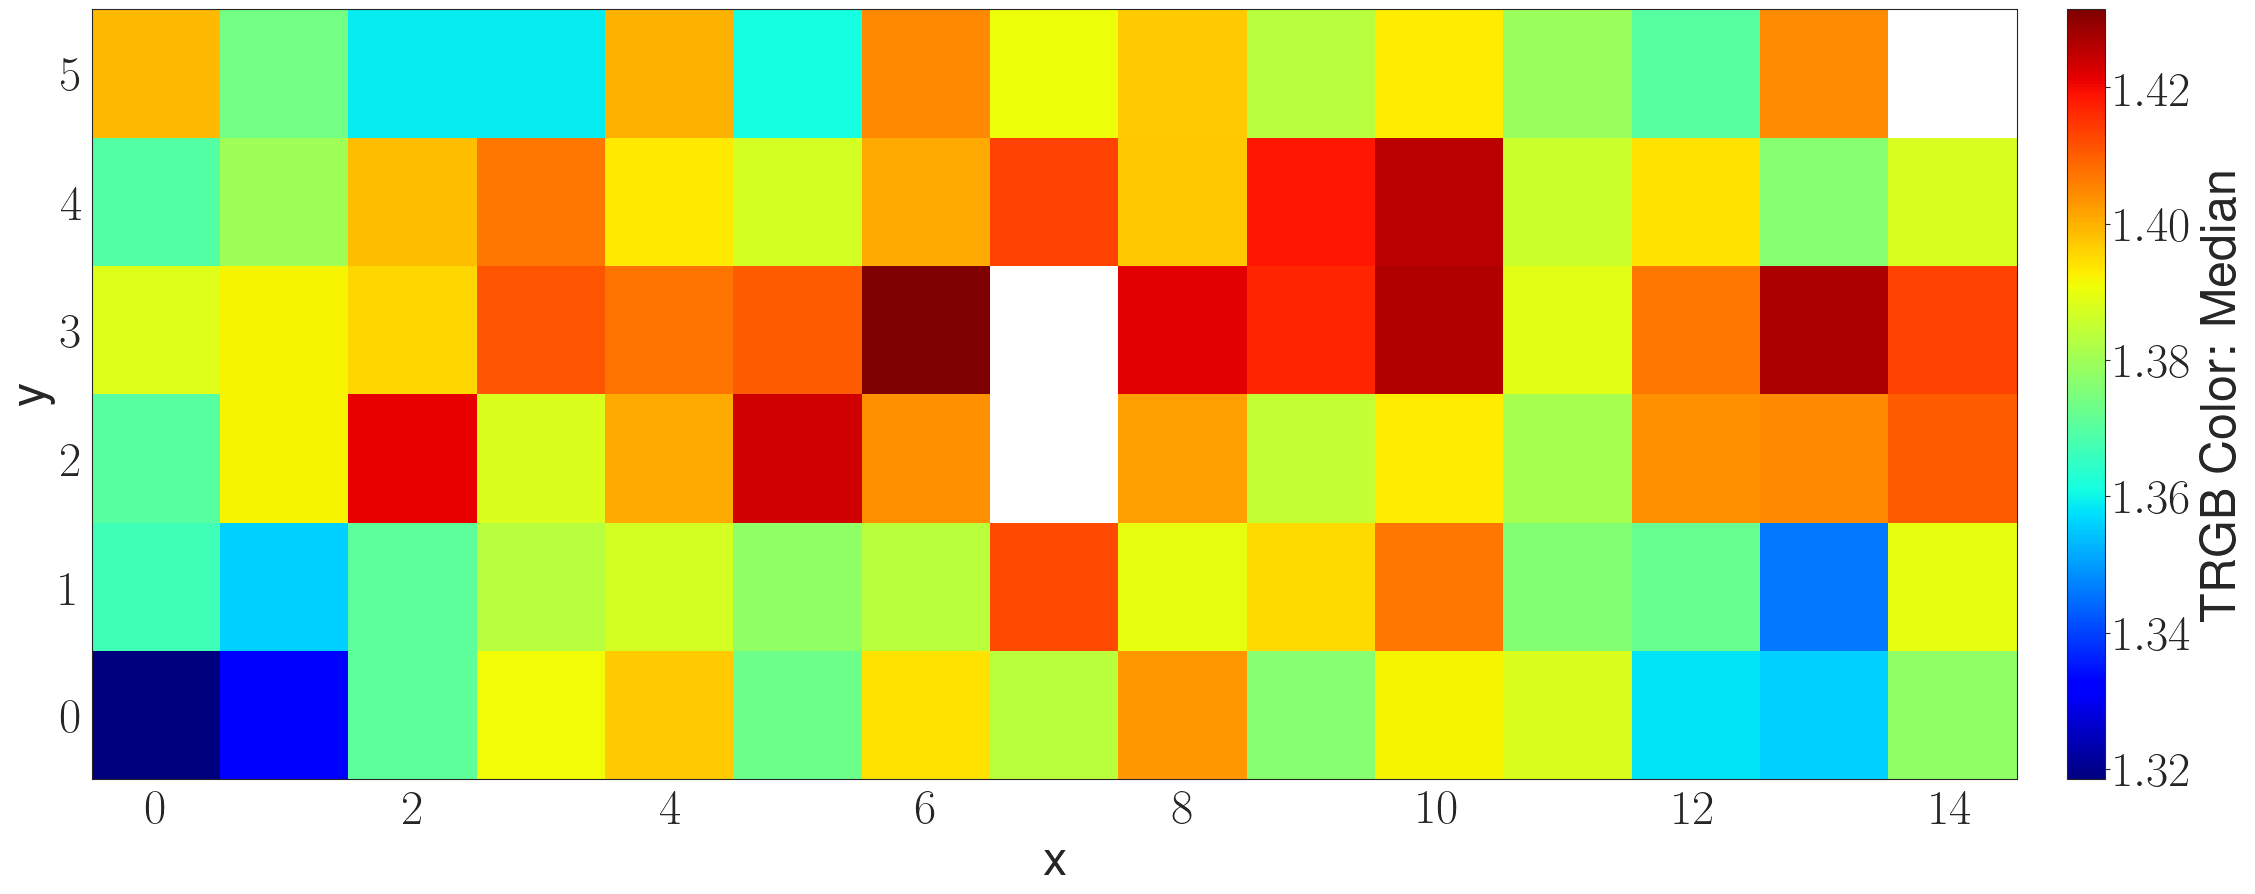

In [43]:
plt.figure(figsize=(32,10))
img = plt.imshow(trgb_cols.T[3], cmap='jet')
cb = plt.colorbar(img, pad=0.02)
cb.set_label('TRGB Color: Median')
plt.xlabel('x')
plt.ylabel('y')

In [44]:
Av = 0.19
y_r = mags_f200w[-1] + Av_dict['f200w']*Av
x_r = mags_f115w[-1] + Av_dict['f115w']*Av - (mags_f200w[-1] +  Av_dict['f200w']*Av)

x_10 = np.arange(1.35,1.5,0.001)
y_10 = np.interp(x_10,x_r,y_r)
met_10 = np.interp(x_10,x_r, [0.001,0.002,0.003,0.004])

x_c = bubble_col[3] 
y_c = bubble_f200w
d = np.arange(29,30,0.0001).reshape(-1,1)
    
r = np.sqrt( (x_10 - x_c)**2 + (y_10 + d - y_c)**2)

dismod = d[np.argwhere(r==r.min())[0][0]][0]
met = met_10[np.argwhere(r==r.min())[0][1]]

In [45]:
dismod, met

(29.71269999999834, 0.002523225806451572)

In [46]:
model_col_err(bubble_f200w), model_mag_err_f200w(bubble_f200w)

(0.018242378461340303, 0.009798911537390074)

In [47]:
ages__ = [9.6, 9.8, 10.0]

In [48]:
dismod = 29.7126999
Av = 0.19

Av_t = 0.0

x = (mags_f115w.T + Av_dict['f115w']*(Av+Av_t)) - (mags_f200w.T + Av_dict['f200w']*(Av+Av_t))
y = mags_f200w.T + Av_dict['f200w']*(Av+Av_t) + dismod

In [49]:
bubble_f200w

23.3345

In [50]:
y[:,-1] - bubble_f200w

array([ 0.2502499,  0.0612499, -0.0557501, -0.1397501])

In [51]:
np.round(bubble_f200w-23.2787499,4), np.round(23.3957499-bubble_f200w,4)

(0.0558, 0.0612)

In [52]:
bubble_f200w

23.3345

In [53]:
x, y = np.mgrid[0:15,0:6]/1.0
x -= 7
y-= 2.5
x *= 24
y *= 24

r = np.sqrt(x**2 + y**2)

r = np.where(x<0,-r,r)*42.5/1e3

(1.12, 1.6)

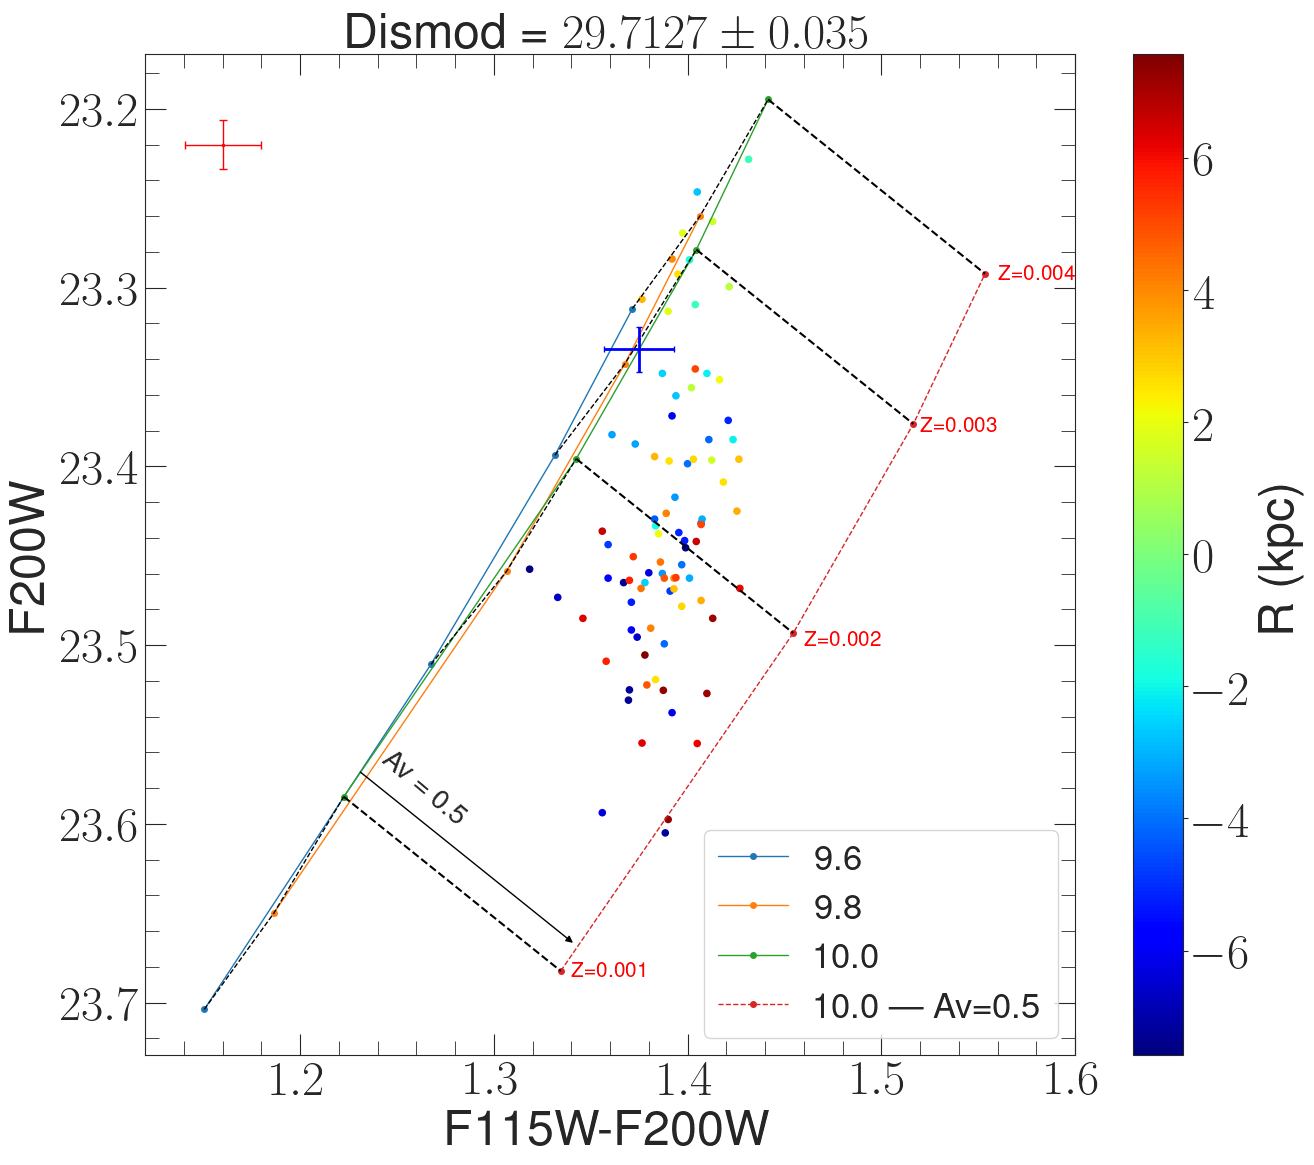

In [54]:
fig, ax = plt.subplots(figsize=(15,13))

dismod = 29.7126999
Av = 0.19

Av_t = 0.0

x = (mags_f115w.T + Av_dict['f115w']*(Av+Av_t)) - (mags_f200w.T + Av_dict['f200w']*(Av+Av_t))
y = mags_f200w.T + Av_dict['f200w']*(Av+Av_t) + dismod

ax.plot(x,y, '-o',
       linewidth=1, markersize=4)

x1 = x[:,-1]
y1 = y[:,-1]
Av_t = 0.5

x = (mags_f115w.T + Av_dict['f115w']*(Av+Av_t)) - (mags_f200w.T + Av_dict['f200w']*(Av+Av_t))
y = mags_f200w.T + Av_dict['f200w']*(Av+Av_t) + dismod

ax.plot(x[:,-1],y[:,-1], '--o',
       linewidth=1, markersize=4, )
x2 = x[:,-1]
y2 = y[:,-1]

x_n = np.concatenate([[x1],[x2]])
y_n = np.concatenate([[y1],[y2]])

ax.plot(x_n,y_n,'--k')

Av_t = 0.
x = (mags_f115w.T + Av_dict['f115w']*(Av+Av_t)) - (mags_f200w.T + Av_dict['f200w']*(Av+Av_t))
y = mags_f200w.T + Av_dict['f200w']*(Av+Av_t) + dismod


ax.plot(x.T,y.T, '--k',
       linewidth=1)

start = 0
end = 89
    
x = trgb_cols[:,:,3].ravel()[start:end+1]
y = trgb_mags_K[:,:].ravel()[start:end+1]
    
xerr = model_col_err(trgb_mags_K[:,:].ravel()[start:end+1])
yerr = trgb_f200w_err[:,:].ravel()[start:end+1]

xerr, yerr = np.nanmean(xerr), np.nanmean(yerr)
img = ax.scatter(x,y,c=r, s=20,cmap='jet')
  
ax.errorbar([1.16],[23.22],xerr=xerr, yerr=yerr, fmt='.r',elinewidth=1,
           markersize=3, capsize=3)
            
#img = ax.errorbar(x,y,xerr=xerr, yerr=yerr, fmt='.k',elinewidth=0.5,
#            markersize=0.5, capsize=2, zorder=100)

#img = ax.scatter(x,y,marker='o',
#            s=0.5, zorder=100)

ax.invert_yaxis()
cb = plt.colorbar(img,ax=ax)

cb.set_label('R (kpc)')
#ax.invert_xaxis()

Av_x = 1.23
Av_y = 23.57

Av_ = 0.5

AF1_ =  Av_dict['f115w']*Av_
AF2_ =  Av_dict['f200w']*Av_

dx = AF1_
dy = AF2_

dx = dx-dy
ax.annotate('', xy=(Av_x, Av_y),
             xycoords='data',
             xytext=(Av_x+dx, Av_y+dy),
             textcoords='data',
             arrowprops=dict(arrowstyle= '<|-',
                             color='black',
                             lw=1,
                             ls='-')
           )

ax.annotate(f'Av = {Av_}', xy=(Av_x+0.01, Av_y+0.03),
             xycoords='data',
             #xytext=(Av_x+dx, Av_y+dy),
             textcoords='data', rotation=-40, fontsize=20
           )
"""
for n,i,j in zip(reg_arr.ravel().astype(int)[start:end+1],x,y):
    ax.annotate(f'{n}', xy=(i- 0.001, j+0.008),
             xycoords='data', fontsize=10, color = 'black', zorder= 100,
           )"""

x = bubble_col[3]
y = bubble_f200w

xerr = model_col_err(bubble_f200w)
yerr = bubble_f200w_err
ax.errorbar([x],[y],xerr=xerr,yerr=yerr, fmt='.b',elinewidth=2,
            markersize=3, capsize=2)

Av = 0.19
r_ind = -1
y_r = mags_f200w[r_ind] + Av_dict['f200w']*Av + dismod
x_r = mags_f115w[r_ind] + Av_dict['f115w']*Av - (mags_f200w[r_ind] +  Av_dict['f200w']*Av)

#ax.plot(x_r, y_r,'--k',)
ax.set_xlabel('F115W-F200W')
ax.set_ylabel('F200W')
ax.set_title('Dismod = $' + f'{np.round(dismod,4)} ' + r'\pm 0.035$')
ax.legend(ages__+['10.0 | Av=0.5'], fontsize=25)

ax.xaxis.set_major_locator(AutoLocator())
ax.xaxis.set_minor_locator(AutoMinorLocator())

ax.yaxis.set_major_locator(AutoLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())

ax.tick_params(which='both', length=15,direction="in", bottom=True, top=True,left=True, right=True)
ax.tick_params(which='minor', length=10)

ax.annotate('Z=0.001',(1.34,23.685), color='red', fontsize=15)
ax.annotate('Z=0.002',(1.46,23.5), color='red', fontsize=15)
ax.annotate('Z=0.003',(1.52,23.38), color='red', fontsize=15)
ax.annotate('Z=0.004',(1.56,23.295), color='red', fontsize=15)
ax.set_xlim(1.12,1.6)

In [164]:
k = 0

Av_map = np.zeros((nx,ny))*np.nan
met_map = np.zeros((nx,ny))*np.nan

for i in range(15):
    for j in range(6):

        Av = 0.19
        dismod = 29.7126999
        ind_ = -1
        y_r = mags_f200w[ind_] + Av_dict['f200w']*Av + dismod
        x_r = mags_f115w[ind_] + Av_dict['f115w']*Av - (mags_f200w[ind_] +  Av_dict['f200w']*Av)

        x_10 = np.arange(1.2,1.5,0.001)
        y_10 = np.interp(x_10,x_r,y_r)
        met_10 = np.interp(x_10,x_r, [0.001,0.002,0.003,0.004,])

        ind = k

        x_c = trgb_cols[:,:,3].ravel()[ind]
        y_c = trgb_mags_K[:,:].ravel()[ind]
        
        if np.isnan(x_c) or np.isnan(y_c) :
            k+=1
            continue

        Av_ = np.arange(-1,0.7, 0.001).reshape(-1,1)

        dx = (Av_dict['f115w']-Av_dict['f200w'])*Av_
        dy = Av_dict['f200w']*Av_

        r = np.sqrt( (x_10 - (x_c-dx))**2 + (y_10 - (y_c-dy))**2)

        av1, z1 = Av_[np.argwhere(r==r.min())[0][0]][0], met_10[np.argwhere(r==r.min())[0][1]]
        
        Av_map[i, j] = av1
        met_map[i, j] = z1
        
        k+=1

In [165]:
errs = np.array([[model_col_err(bubble_f200w), bubble_f200w_err],
                 [model_col_err(bubble_f200w), -bubble_f200w_err],
                 [-model_col_err(bubble_f200w), bubble_f200w_err],
                 [-model_col_err(bubble_f200w), -bubble_f200w_err]])

In [166]:
avs = []
zs = []
for i,j in errs:
    Av = 0.19
    dismod = 29.7126999
    ind_ = -1
    y_r = mags_f200w[ind_] + Av_dict['f200w']*Av + dismod
    x_r = mags_f115w[ind_] + Av_dict['f115w']*Av - (mags_f200w[ind_] +  Av_dict['f200w']*Av)

    x_10 = np.arange(1.2,1.5,0.001)
    y_10 = np.interp(x_10,x_r,y_r)
    met_10 = np.interp(x_10,x_r, [0.001,0.002,0.003,0.004])


    x_c = bubble_col[3] +i
    y_c = bubble_f200w + j

    Av_ = np.arange(-1,0.7, 0.001).reshape(-1,1)

    dx = (Av_dict['f115w']-Av_dict['f200w'])*Av_
    dy = Av_dict['f200w']*Av_

    r = np.sqrt( (x_10 - (x_c-dx))**2 + (y_10 - (y_c-dy))**2)

    av1, z1 = Av_[np.argwhere(r==r.min())[0][0]][0], met_10[np.argwhere(r==r.min())[0][1]]

    avs.append(av1)
    zs.append(z1)

In [167]:
np.std(avs), np.std(zs)

(0.059165023451360245, 0.00011461830970605066)

In [168]:
mask = np.where(Av_map<-0.06,np.nan,1)

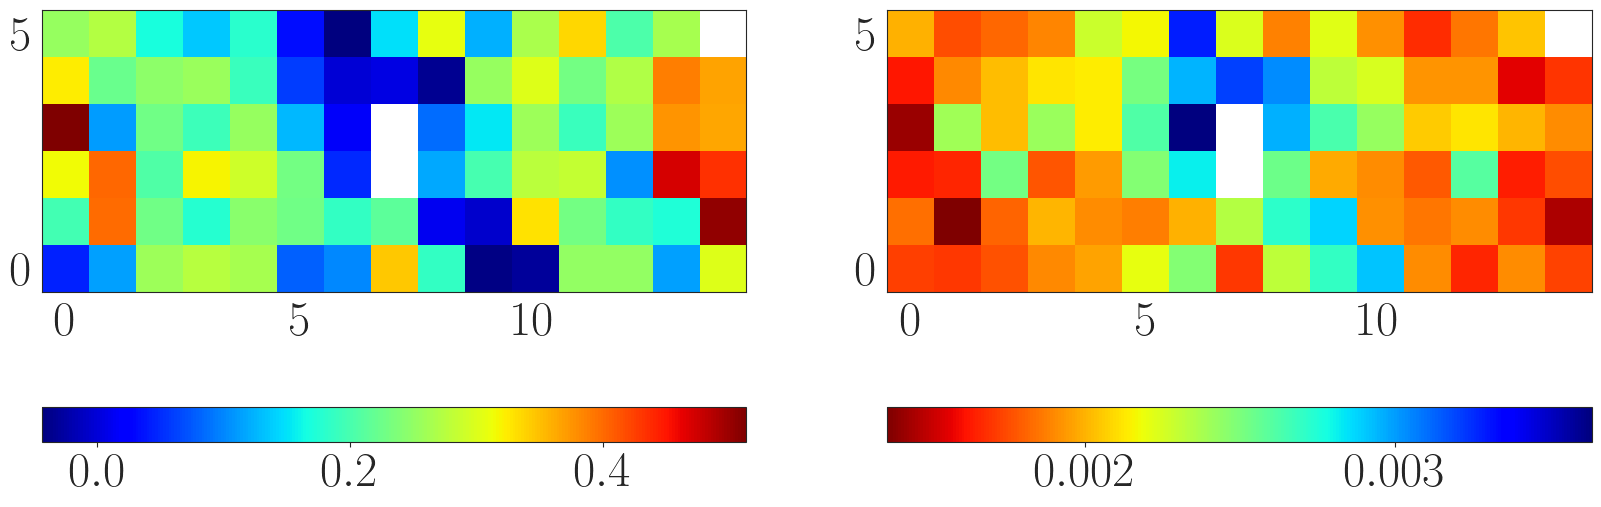

In [169]:
fig, ax = plt.subplots(1,2, figsize=(20,10))

img = ax[0].imshow(Av_map.T*mask.T, cmap='jet')
plt.colorbar(img,ax=ax[0], orientation='horizontal')
img= ax[1].imshow(met_map.T*mask.T, cmap='jet_r')
plt.colorbar(img,ax=ax[1], orientation='horizontal')

In [170]:
x, y = np.mgrid[0:15,0:6]/1.0
x -= 7
y-= 2.5
x *= 24
y *= 24

r = np.sqrt(x**2 + y**2)

In [171]:
@custom_model

def exp1d(x,x0=0,tau=1,A=1,B=0.):
    return A*np.exp(-(x+x0)/tau) + B

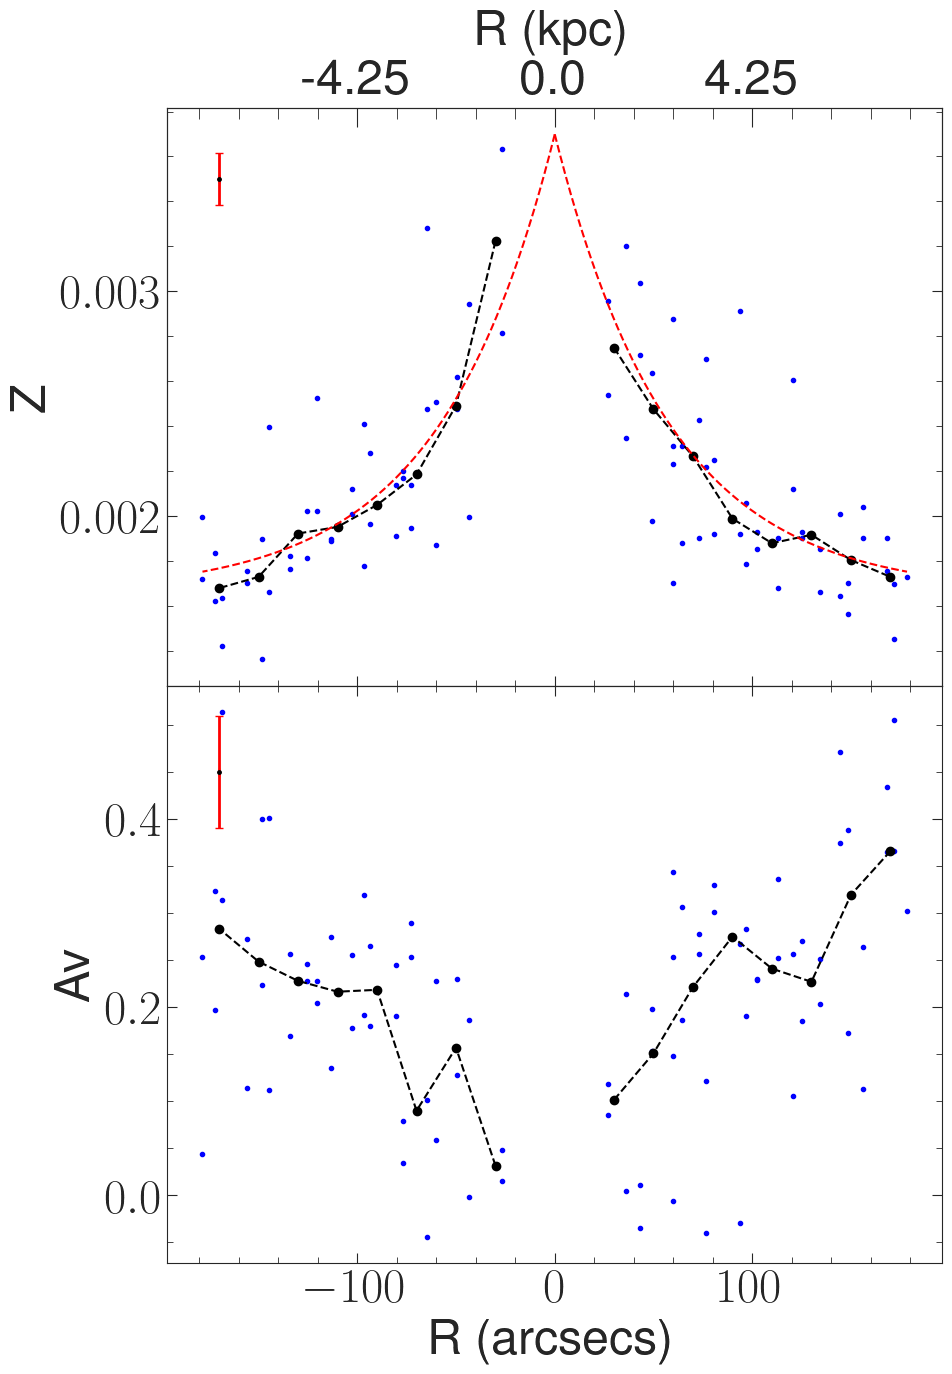

In [184]:
fig , ax = plt.subplots(2,1,figsize=(10,15), sharex=True)
# Total

x = r.ravel()
y = (met_map*mask).ravel()
ind = ~np.isnan(y)
x = x[ind]
y = y[ind]

init = exp1d(tau=10)
fit = fitting.LevMarLSQFitter()
model = fit(init,abs(x),y)

# Left
x = r[:7].ravel()
y = (met_map*mask)[:7].ravel()
ind = ~np.isnan(y)

x = x[ind]
y = y[ind]

x_new = np.arange(0,x.max()*1.1,20)
x_c = 0.5*(x_new[1:] + x_new[:-1])

y_new = []
for i in range(len(x_new)-1):
    ind = np.where((x>x_new[i]) & (x<=x_new[i+1]))
    
    y_new.append(np.median(y[ind]))

y_c = np.array(y_new)

ax[0].scatter(-x,y, marker='.', color='blue')
ax[0].plot(-x_c,y_c, '--ok')
x_new = np.linspace(0,x.max(),1000)

init = exp1d(tau=10)
fit = fitting.LevMarLSQFitter()
model1 = fit(init,x,y)

ax[0].plot(-x_new, model(x_new),'--r')

#Right
x = r[7:].ravel()
y = (met_map*mask)[7:].ravel()
ind = ~np.isnan(y)

x = x[ind]
y = y[ind]

x_new = np.arange(0,x.max()*1.1,20)
x_c = 0.5*(x_new[1:] + x_new[:-1])

y_new = []
for i in range(len(x_new)-1):
    ind = np.where((x>x_new[i]) & (x<=x_new[i+1]))
    
    y_new.append(np.median(y[ind]))

y_c = np.array(y_new)

ax[0].scatter(x,y, marker='.', color='blue')
ax[0].plot(x_c,y_c, '--ok')

x_new = np.linspace(0,x.max(),1000)

init = exp1d(tau=10)
fit = fitting.LevMarLSQFitter()
model2 = fit(init,x,y)

ax[0].plot(x_new, model(x_new),'--r')

ax[0].set_ylabel('Z')

# Extinction

# Left
x = r[:7].ravel()
y = (Av_map*mask)[:7].ravel()
ind = ~np.isnan(y)

x = x[ind]
y = y[ind]

x_new = np.arange(0,x.max()*1.1,20)
x_c = 0.5*(x_new[1:] + x_new[:-1])

y_new = []
for i in range(len(x_new)-1):
    ind = np.where((x>x_new[i]) & (x<=x_new[i+1]))
    
    y_new.append(np.median(y[ind]))

y_c = np.array(y_new)

ax[1].scatter(-x,y, marker='.', color='blue')
ax[1].plot(-x_c,y_c, '--ok')

#Right
x = r[7:].ravel()
y = (Av_map*mask)[7:].ravel()
ind = ~np.isnan(y)

x = x[ind]
y = y[ind]

x_new = np.arange(0,x.max()*1.1,20)
x_c = 0.5*(x_new[1:] + x_new[:-1])

y_new = []
for i in range(len(x_new)-1):
    ind = np.where((x>x_new[i]) & (x<=x_new[i+1]))
    
    y_new.append(np.median(y[ind]))

y_c = np.array(y_new)

ax[1].scatter(x,y, marker='.', color='blue')
ax[1].plot(x_c,y_c, '--ok')



ax[1].set_xlabel('R (arcsecs)')
ax[1].set_ylabel('Av')

ax[0].errorbar(x=[-170],y=[0.0035],xerr=0,yerr=0.0001146, fmt='.r',elinewidth=2,
            markersize=5, capsize=3, markerfacecolor='black', markeredgecolor='black')

ax[1].errorbar(x=[-170],y=[0.45],xerr=0,yerr=0.059165, fmt='.r',elinewidth=2,
            markersize=5, capsize=3, markerfacecolor='black', markeredgecolor='black')

ax1 = ax[0].twiny()  # instantiate a second axes that shares the same x-axis
ax1.set_xlabel('R (kpc)',labelpad=10)  # we already handled the x-label with ax1
xticks = ax[1].get_xticks()
xticks_n = xticks

dx = xticks_n - np.floor(xticks_n)

ax1.set_xticks(xticks, np.floor(xticks_n)*42.5/1e3)
z
ax1.set_xlim(ax[1].get_xlim()[0],ax[1].get_xlim()[1])



ax[0].xaxis.set_major_locator(AutoLocator())
ax[0].xaxis.set_minor_locator(AutoMinorLocator())

ax[0].yaxis.set_major_locator(AutoLocator())
ax[0].yaxis.set_minor_locator(AutoMinorLocator())

ax[0].tick_params(which='both', length=7,direction="in", bottom=True,left=True, right=True)
ax[0].tick_params(which='minor', length=4)

ax[1].xaxis.set_major_locator(AutoLocator())
ax[1].xaxis.set_minor_locator(AutoMinorLocator())

ax[1].yaxis.set_major_locator(AutoLocator())
ax[1].yaxis.set_minor_locator(AutoMinorLocator())

ax[1].tick_params(which='both', length=7,direction="in", bottom=True, top=True,left=True, right=True)
ax[1].tick_params(which='minor', length=4)


ax1.xaxis.set_minor_locator(AutoMinorLocator())
ax1.tick_params(which='both', length=14,direction="in", right=True)
ax1.tick_params(which='minor', length=8)
plt.subplots_adjust(hspace=0)

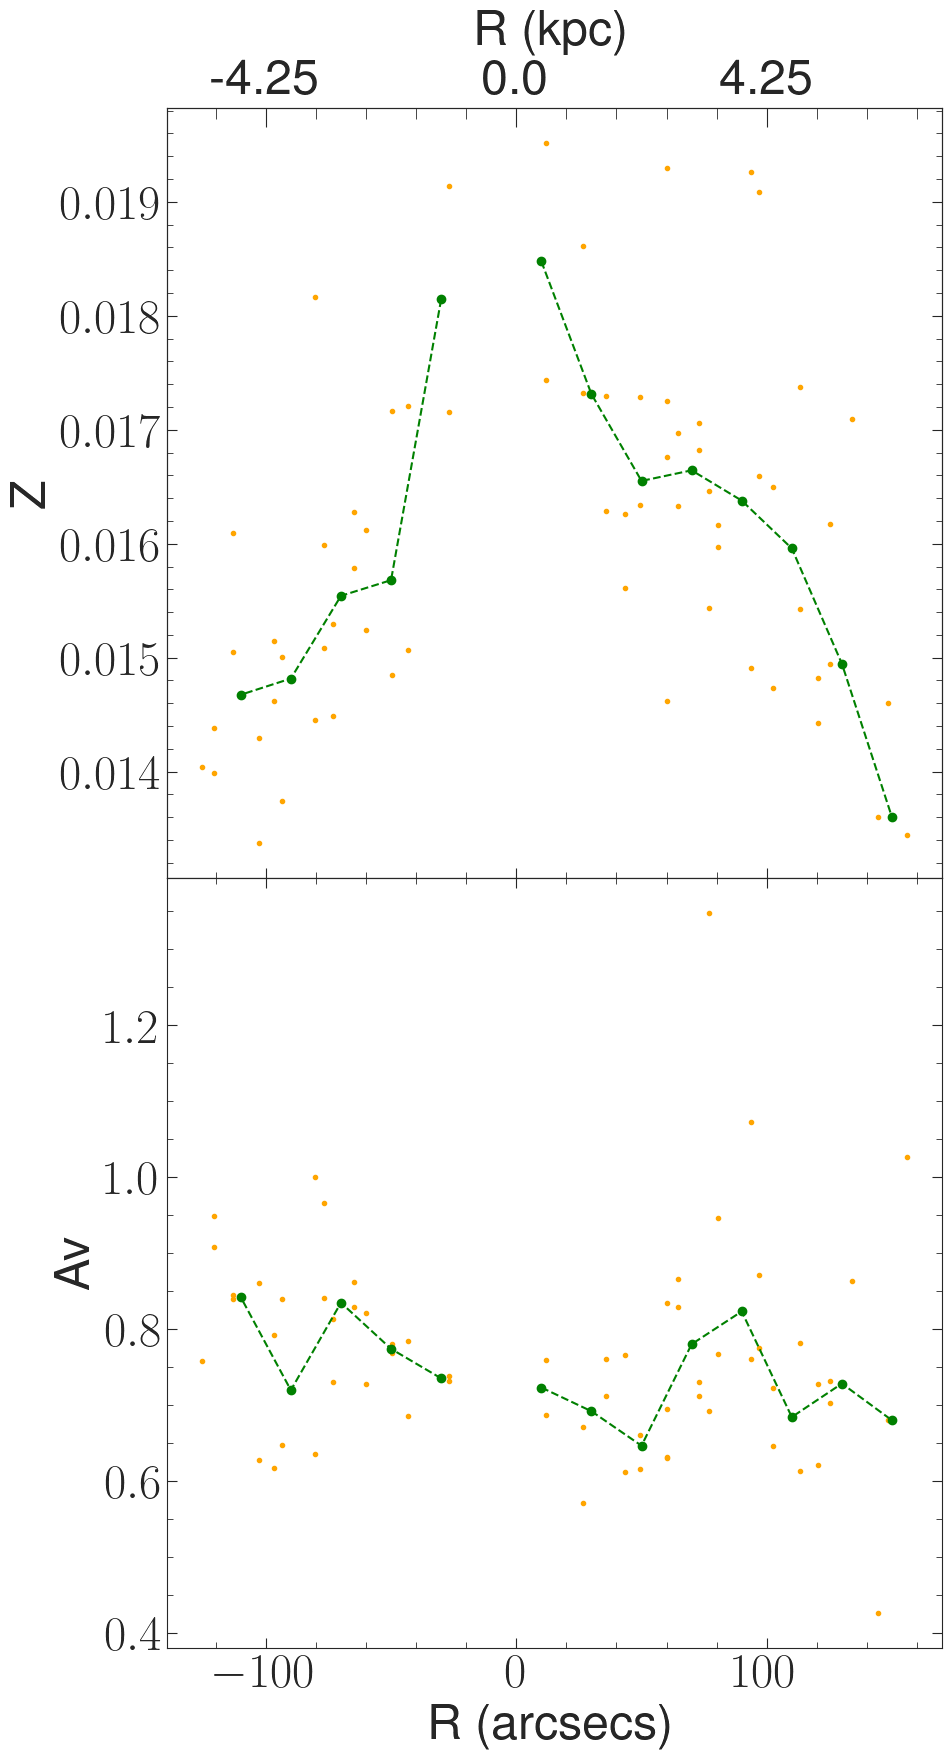

In [189]:
fig , ax = plt.subplots(2,1,figsize=(10,20), sharex=True)


#Gas-phase metallicity

# Left
x = r[:7].ravel()
y = (Z_gas*mask)[:7].ravel()
ind = ~np.isnan(y)

x = x[ind]
y = y[ind]

x_new = np.arange(0,x.max()*1.1,20)
x_c = 0.5*(x_new[1:] + x_new[:-1])

y_new = []
for i in range(len(x_new)-1):
    ind = np.where((x>x_new[i]) & (x<=x_new[i+1]))
    
    y_new.append(np.median(y[ind]))

y_c = np.array(y_new)

ax[0].scatter(-x,y, marker='.', color='orange')
ax[0].plot(-x_c,y_c, '--og')


#Right
x = r[7:].ravel()
y = (Z_gas*mask)[7:].ravel()
ind = ~np.isnan(y)

x = x[ind]
y = y[ind]

x_new = np.arange(0,x.max()*1.1,20)
x_c = 0.5*(x_new[1:] + x_new[:-1])

y_new = []
for i in range(len(x_new)-1):
    ind = np.where((x>x_new[i]) & (x<=x_new[i+1]))
    
    y_new.append(np.median(y[ind]))

y_c = np.array(y_new)

ax[0].scatter(x,y, marker='.', color='orange')
ax[0].plot(x_c,y_c, '--og')

ax[0].set_ylabel('Z')

# Balmer decrement Exinction MUSE

# Left
x = r[:7].ravel()
y = (Av_map_n*mask)[:7].ravel()
ind = ~np.isnan(y)

x = x[ind]
y = y[ind]

x_new = np.arange(0,x.max()*1.1,20)
x_c = 0.5*(x_new[1:] + x_new[:-1])

y_new = []
for i in range(len(x_new)-1):
    ind = np.where((x>x_new[i]) & (x<=x_new[i+1]))
    
    y_new.append(np.median(y[ind]))

y_c = np.array(y_new)

ax[1].scatter(-x,y, marker='.', color='orange')
ax[1].plot(-x_c,y_c, '--og')

#Right
x = r[7:].ravel()
y = (Av_map_n*mask)[7:].ravel()
ind = ~np.isnan(y)

x = x[ind]
y = y[ind]

x_new = np.arange(0,x.max()*1.1,20)
x_c = 0.5*(x_new[1:] + x_new[:-1])

y_new = []
for i in range(len(x_new)-1):
    ind = np.where((x>x_new[i]) & (x<=x_new[i+1]))
    
    y_new.append(np.median(y[ind]))

y_c = np.array(y_new)

ax[1].scatter(x,y, marker='.', color='orange')
ax[1].plot(x_c,y_c, '--og')

ax[1].set_xlabel('R (arcsecs)')
ax[1].set_ylabel('Av')

ax1 = ax[0].twiny()  # instantiate a second axes that shares the same x-axis
ax1.set_xlabel('R (kpc)',labelpad=10)  # we already handled the x-label with ax1
xticks = ax[1].get_xticks()
xticks_n = xticks

dx = xticks_n - np.floor(xticks_n)

ax1.set_xticks(xticks, np.floor(xticks_n)*42.5/1e3)

ax1.set_xlim(ax[1].get_xlim()[0],ax[1].get_xlim()[1])


ax[0].xaxis.set_major_locator(AutoLocator())
ax[0].xaxis.set_minor_locator(AutoMinorLocator())

ax[0].yaxis.set_major_locator(AutoLocator())
ax[0].yaxis.set_minor_locator(AutoMinorLocator())

ax[0].tick_params(which='both', length=7,direction="in", bottom=True,left=True, right=True)
ax[0].tick_params(which='minor', length=4)

ax[1].xaxis.set_major_locator(AutoLocator())
ax[1].xaxis.set_minor_locator(AutoMinorLocator())

ax[1].yaxis.set_major_locator(AutoLocator())
ax[1].yaxis.set_minor_locator(AutoMinorLocator())

ax[1].tick_params(which='both', length=7,direction="in", bottom=True, top=True,left=True, right=True)
ax[1].tick_params(which='minor', length=4)


ax1.xaxis.set_minor_locator(AutoMinorLocator())
ax1.tick_params(which='both', length=14,direction="in", right=True)
ax1.tick_params(which='minor', length=8)
plt.subplots_adjust(hspace=0)

Text(0, 0.5, '$\\sigma_{Z_{gas}}$')

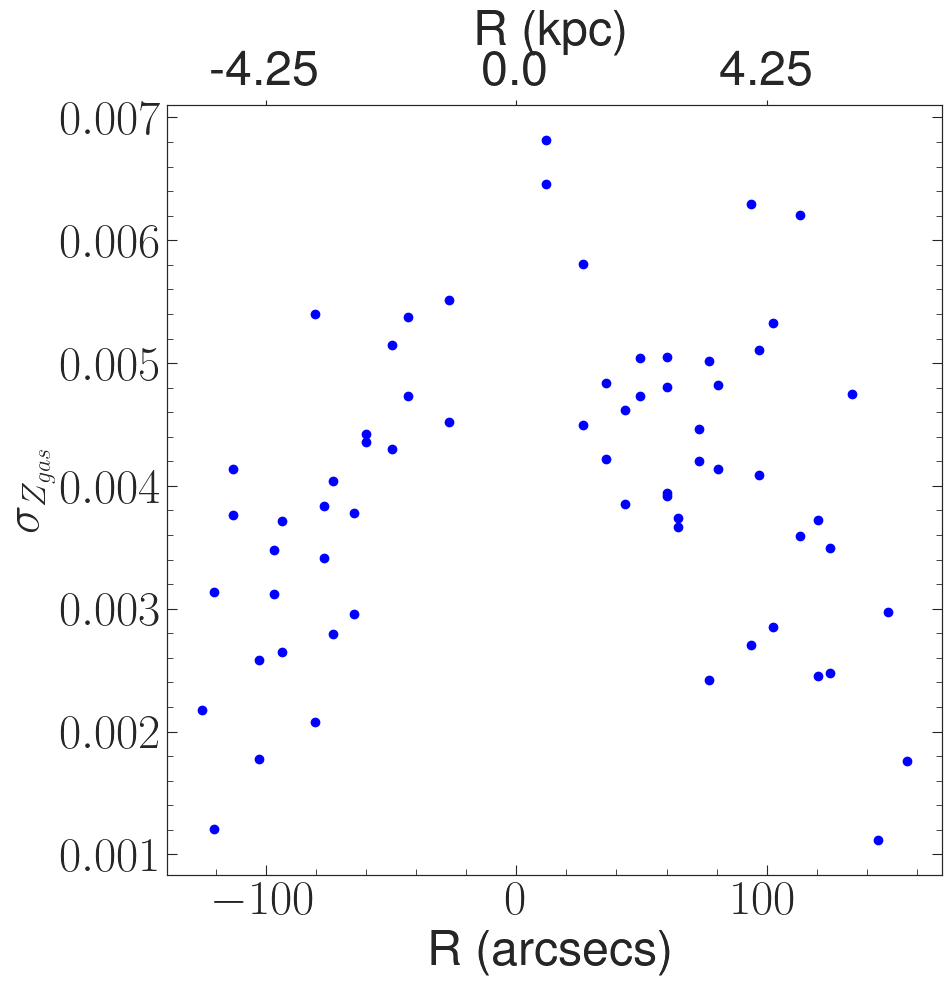

In [134]:
r_ = r.copy()
r_[:7] *= -1

x = r_.ravel()
y = Z_gas_std.ravel()

fig, ax_ = plt.subplots(figsize=(10,10))

ax_.scatter(x,y, color='blue')

ax_.xaxis.set_major_locator(AutoLocator())
ax_.xaxis.set_minor_locator(AutoMinorLocator())

ax_.yaxis.set_major_locator(AutoLocator())
ax_.yaxis.set_minor_locator(AutoMinorLocator())

ax_.tick_params(which='both', length=7,direction="in", left=True, right=True,bottom=False)
ax_.tick_params(which='minor', length=4)

ax1 = ax_.twiny()  # instantiate a second axes that shares the same x-axis
ax1.set_xlabel('R (kpc)')  # we already handled the x-label with ax1
xticks = ax_.get_xticks()
xticks_n = xticks

dx = xticks_n - np.floor(xticks_n)

ax1.set_xticks(xticks, np.floor(xticks_n)*42.5/1e3)

ax1.set_xlim(ax_.get_xlim()[0],ax_.get_xlim()[1])

ax_.set_xlabel('R (arcsecs)')

ax_.set_ylabel(r'$\sigma_{Z_{gas}}$')

Text(0, 0.5, '$Z_{gas}$')

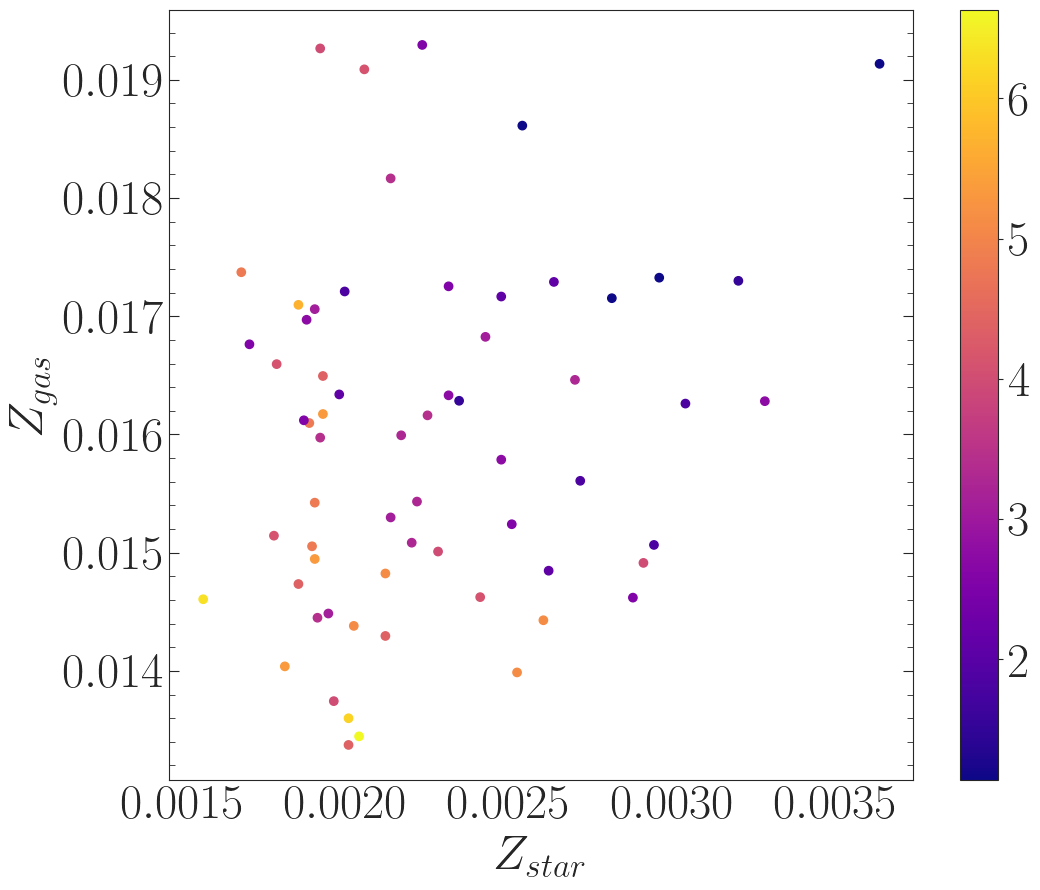

In [200]:
r_ = r.copy()
r_[:7] *= -1

x = met_map.ravel()
y = Z_gas.ravel()

fig, ax_ = plt.subplots(figsize=(12,10))

img = ax_.scatter(x,y, c=r*42.5e-3,cmap='plasma')

cb = plt.colorbar(img,ax = ax_)


ax_.xaxis.set_major_locator(AutoLocator())
ax_.xaxis.set_minor_locator(AutoMinorLocator())

ax_.yaxis.set_major_locator(AutoLocator())
ax_.yaxis.set_minor_locator(AutoMinorLocator())

ax_.tick_params(which='both', length=7,direction="in", left=True, right=True,bottom=False)
ax_.tick_params(which='minor', length=4)

ax_.set_xlabel(r'$Z_{star}$')

ax_.set_ylabel(r'$Z_{gas}$')

Text(0, 0.5, 'Z')

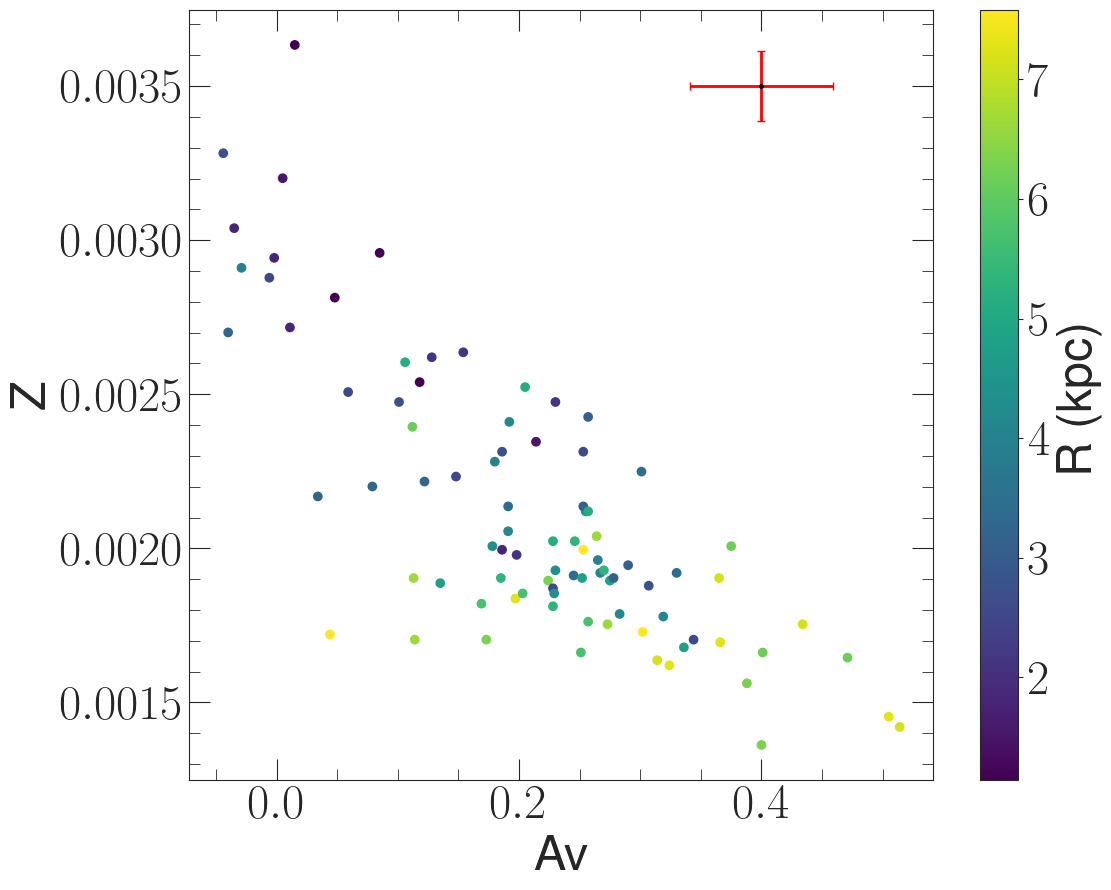

In [225]:
fig, ax = plt.subplots(figsize=(12,10))

img = ax.scatter(Av_map.ravel(), met_map.ravel(), c=r*42.5/1e3, cmap='viridis')

cb = plt.colorbar(img,ax=ax)

cb.set_label('R (kpc)')

ax.errorbar(x=[0.4],y=[0.0035],xerr=0.059165,yerr=0.0001146, fmt='.r',elinewidth=2,
            markersize=5, capsize=3, markerfacecolor='black', markeredgecolor='black')
ax.xaxis.set_major_locator(AutoLocator())
ax.xaxis.set_minor_locator(AutoMinorLocator())

ax.yaxis.set_major_locator(AutoLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())

ax.tick_params(which='both', length=15,direction="in", bottom=True, top=True,left=True, right=True)
ax.tick_params(which='minor', length=8)

ax.set_xlabel('Av')
ax.set_ylabel('Z')

(0.0012257999999999477, 0.003996864864864118)

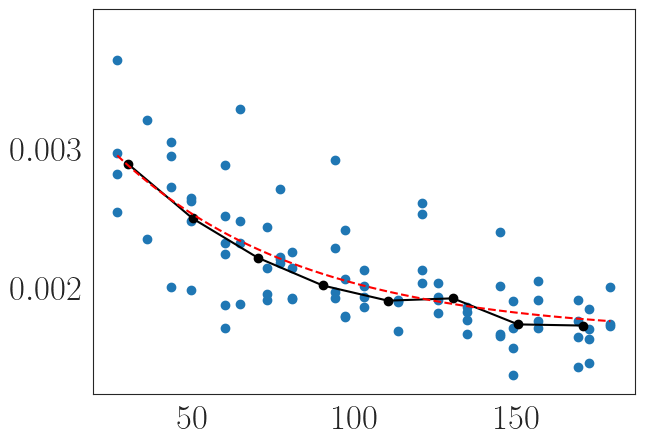

In [110]:
x = r.ravel()
y = (met_map*mask).ravel()
ind = ~np.isnan(y)
x = x[ind]
y = y[ind]

x_new = np.arange(0,x.max()*1.1,20)
x_c = 0.5*(x_new[1:] + x_new[:-1])

y_new = []
for i in range(len(x_new)-1):
    ind = np.where((x>x_new[i]) & (x<=x_new[i+1]))
    
    y_new.append(np.median(y[ind]))

y_c = np.array(y_new)


plt.scatter(x,y)
plt.plot(x_c,y_c,'-ok')

init = exp1d(tau=10)
fit = fitting.LevMarLSQFitter()
model = fit(init,abs(x),y)


x_new = np.linspace(x.min(),x.max(),1000)

plt.plot(x_new, model(x_new),'--r')

plt.ylim(0.9*y.min(), 1.1*y.max())

/home/avinashck/anaconda3/envs/inaoe/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/avinashck/anaconda3/envs/inaoe/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


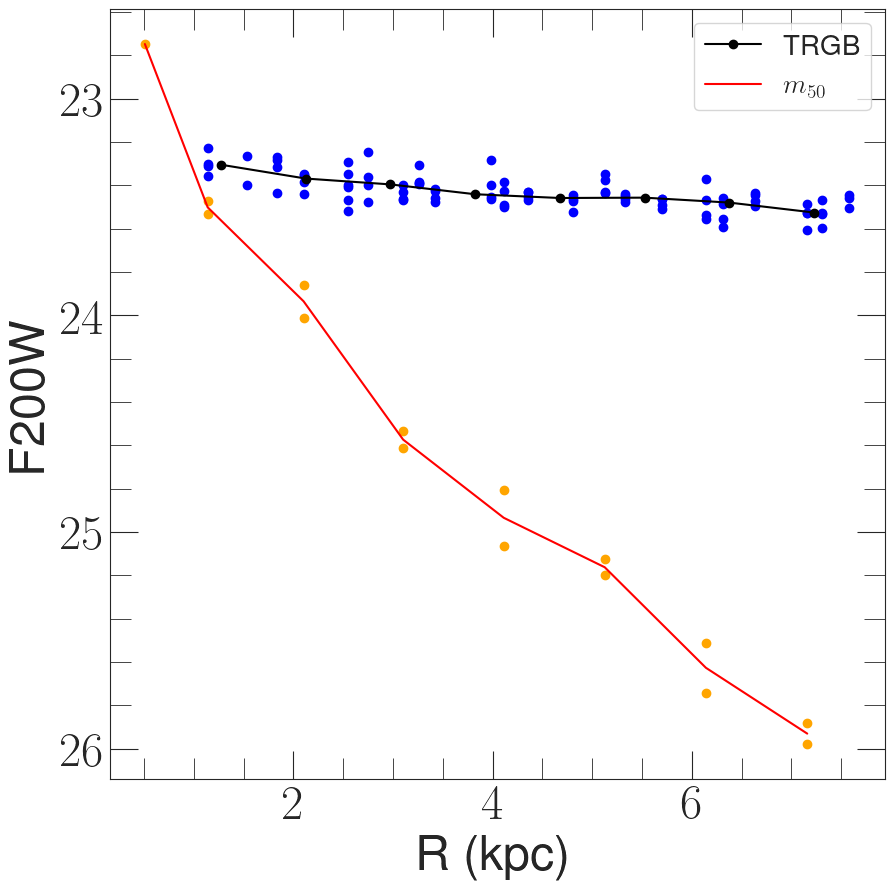

In [136]:
fig, ax = plt.subplots(figsize=(10,10))
x = r.ravel()
y = (trgb_f200w_mag*mask).ravel()
ind = ~np.isnan(y)
x = x[ind]
y = y[ind]

x_new = np.arange(0,x.max()*1.2,20)
x_c = 0.5*(x_new[1:] + x_new[:-1])

y_new = []
for i in range(len(x_new)-1):
    ind = np.where((x>x_new[i]) & (x<=x_new[i+1]))
    
    y_new.append(np.median(y[ind]))

y_c = np.array(y_new)


ax.scatter(x*42.5*1e-3,y, color='blue')
ax.plot(x_c*42.5*1e-3,y_c,'-ok', label = 'TRGB')

y_f200w = np.array([25.9781503 , 25.74232124, 25.19845565, 24.80504045, 24.53260125,
       23.85941158, 23.47109451, 22.7474432 , 23.53099111, 24.00988105,
       24.61366905, 25.06264859, 25.12595093, 25.5101388 , 25.88185164])

x = np.array([-168.42802617, -144.49913495, -120.59850745,  -96.74709298,
        -72.99315036,  -49.47726751,  -26.83281573,   12.        ,
         26.83281573,   49.47726751,   72.99315036,   96.74709298,
        120.59850745,  144.49913495,  168.42802617])[:len(y_f200w)]

ax.scatter(abs(x)*42.5e-3,y_f200w, color='orange', label='_no_legend_')

x = x[7:][::-1]
y = 0.5*(y_f200w[:8] + y_f200w[7:][::-1])

ax.plot(x*42.5e-3,y, '-r', label=r'$m_{50}$')
            
ax.set_xlabel('R (kpc)')
ax.set_ylabel('F200W')

ax.xaxis.set_major_locator(AutoLocator())
ax.xaxis.set_minor_locator(AutoMinorLocator())

ax.yaxis.set_major_locator(AutoLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())

ax.tick_params(which='both', length=20,direction="in", bottom=True, top=True,left=True, right=True)
ax.tick_params(which='minor', length=15)

ax.invert_yaxis()
ax.legend(fontsize=20)

In [156]:
x

array([168.42802617, 144.49913495, 120.59850745,  96.74709298,
        72.99315036,  49.47726751,  26.83281573])

In [144]:
y2

array([22.7474432 , 23.47109451, 23.85941158, 24.53260125, 24.80504045,
       25.19845565, 25.74232124, 25.9781503 ])

In [152]:
y_f200w[6:][::-1]

array([25.88185164, 25.5101388 , 25.12595093, 25.0658088 , 24.60594044,
       23.53099111, 22.7474432 , 23.47109451])

In [150]:
y_f200w[7::-1]

array([22.7474432 , 23.47109451, 23.85941158, 24.53260125, 24.80504045,
       25.19845565, 25.74232124, 25.9781503 ])

In [ ]:
plt.imshow(r.T, cmap='jet')

In [ ]:
model

In [ ]:
model1

In [ ]:
model2

### **Carbon Stars**

In [ ]:
tab = Table.read('../PHOT_OUTPUT_r40.5/galaxy/f115w_f200w.fits')

In [ ]:
tab['f115w_f200w'] = tab['mag_vega_F115W'] - tab['mag_vega_F200W']

x = np.linspace(1,4)
y = (24-29)*(x-2.1) + 24

init = models.Linear1D()
fit = fitting.LinearLSQFitter()
model_1 = fit(init, x,y)

y = -(24-24.2)*(x-2.5) + 24

model_2 = fit(init, x,y)

ra_cen, dec_cen = 24.1739654, 15.7837025

tab['r'] = angular_separation(tab['ra_1']*u.deg, tab['dec_1']*u.deg, ra_cen*u.deg, dec_cen*u.deg).to(u.arcsec).value

x = tab['ra_1']
y = tab['dec_1']
c = tab['r']

rs = [0, 10]
A  = np.pi*rs[-1]**2

while rs[-1] < 75:
    r = np.sqrt((A+np.pi*rs[-1]**2)/np.pi)
    
    rs.append(r)
    
n_cs = [0]
for i in range(len(rs)-1):
    r_in = rs[i]
    r_out = rs[i+1]
    
    # Annulus
    t = tab[(tab['r']>=r_in) & (tab['r']<r_out)]
    
    # Carbon stars
    t = t[t['mag_vega_F200W']>=model_1(t['f115w_f200w'])]
    t = t[t['mag_vega_F200W']<=model_2(t['f115w_f200w'])]
    
    x = t['ra_1']
    y = t['dec_1']
    
    n_cs.append(len(t))

In [ ]:

fig, ax = plt.subplots()

x = tab['f115w_f200w']
y = tab['mag_vega_F200W']
ax.scatter(x,y, s=0.5)

x = t['f115w_f200w']
y = t['mag_vega_F200W']

ax.scatter(x,y, s=0.5)
x = np.linspace(1,4)
y1 = model_1(x)
y2 = model_2(x)

ax.plot(x,y1,'--r')
ax.plot(x,y2,'--r')

ax.invert_yaxis()
ax.set_xlabel('F115W-F200W')
ax.set_ylabel('F200W')

ax.legend(['Total','Carbon Stars'])

In [ ]:
x = rs
y = n_cs

plt.plot(x,y,'-ok')
plt.xlabel('Radius (arcsecs)')
plt.ylabel('No of Carbon stars')

In [ ]:
t = tab

# Carbon stars
t = t[t['mag_vega_F200W']>=model_1(t['f115w_f200w'])]
t = t[t['mag_vega_F200W']<=model_2(t['f115w_f200w'])]

x = t['ra_1']
y = t['dec_1']

scale = 11417/4486
l = 5
fig, ax = plt.subplots(figsize=(l*scale+3,l))

theta = np.pi/2.75

x,y = x*np.cos(theta) - y*np.sin(theta),x*np.sin(theta) + y*np.cos(theta)
xmin, xmax = -4.259903639039913, -4.369990102024565
ymin, ymax = 28.524099525386, 28.568378781292367

# Peform the kernel density estimate
xx, yy = np.mgrid[xmin:xmax:200j, ymin:ymax:200j]
positions = np.vstack([xx.ravel(), yy.ravel()])
values = np.vstack([x, y])

kernel = gaussian_kde(values, bw_method=200/3600)
f = np.reshape(kernel(positions), xx.shape)

f = np.fliplr(f).T

img = ax.contourf(f, cmap='jet', levels=np.linspace(200,f.max(),10),
          extent=[xmax, xmin,
                  ymin, ymax], zorder=200, alpha=0.3)

df_f = df[(df['age']>7) &(df['age']<=9.5)]
x = df_f['RA']
y = df_f['DEC']
c = df_f['age']
scale = 11417/4486
l = 5
theta = np.pi/2.75
ax.scatter(x*np.cos(theta) - y*np.sin(theta),x*np.sin(theta) + y*np.cos(theta),s=0.2,c=c, cmap='Greys',
                zorder=199)
ax.invert_xaxis()
ax.set_xlim(-4.259903639039913, -4.369990102024565)
ax.set_ylim(28.524099525386, 28.568378781292367)
ax.axis('Off')
cb = plt.colorbar(img, shrink=0.9, pad=-0.03)
cb.set_label('Gaussian Kernel Density')
fig.tight_layout()

#### **Simulated Carbon Star Image**

In [ ]:
tab = Table.read('Carbon_stars.fits')

In [ ]:
df = tab[['ra_2', 'dec_2', 'flux_2','mag_vega_F200W']].to_pandas()

In [ ]:
df = df.rename(columns={'ra_2':'ra',
                'dec_2':'dec',
                'flux_2': 'flux',
                'mag_vega_F200W':'mag'})

In [ ]:
zero_flux = df['flux']/pow(10,-0.4*df['mag'])
zero_flux = np.median(zero_flux)

In [ ]:
2.5*np.log10(zero_flux)

In [ ]:
hdul_n = fits.open(dict_images[det_n][filt_n]['images'][0])
data_n = hdul_n[1].data

pixel_scale = hdul_n[1].header['CDELT1']*3600

wcs_n = WCS(hdul_n[1].header)

In [ ]:
hdul_n[1].header

In [ ]:
wcs_n

In [ ]:
np.arccos(0.422540420042849)*180/np.pi

In [ ]:
psf = fits.open(f'../data/PSF/epsf/F200W/snap_test_psf.fits')[0].data[0,0]
psf = psf.reshape(51,5,51,5).sum(axis=(1,3))
psf /= psf.sum()

hdu = fits.PrimaryHDU(psf)
hdul = fits.HDUList([hdu])
hdul.writeto('psf.fits', overwrite=True)

tel_params ={
            'aperture'       : 650,
            'pixel_scale'    : pixel_scale,
            'psf_file'       : f'psf.fits',
            'response_funcs' :  [ f'{data_path}/INSIST/UV/Coating.dat,5,100',   # 6 mirrors
                                ],
             'coeffs'        : 1/11112.266256569348,
             'theta'         : 65.00492096781794,
             'M_sky' : 27,
            }

In [ ]:
sim = pt.Imager(df, coords=(24.17399193760206,  15.78396038669509),
                tel_params=tel_params, n_x=11604, n_y=4630, exp_time = 2920.4)

In [ ]:
2.5*np.log10(sim.zero_flux), 

In [ ]:
sim.shot_noise = False
sim.sky = False
sim.Bias = False
sim.QN = False
sim.DC = False
sim.PRNU = False
det_params = {'shot_noise' :  'Poisson',
              'qe_response': [],
              'qe_mean'    : 1,
              'G1'         :  1,
              'bias'       : 1,
              'PRNU_frac'  :  0.25/100,
              'DCNU'       :  0.1/100,
              'RN'         :  0.5,
              'T'          :  218,
              'DN'         :  0.01/100
              }

sim(det_params=det_params, photometry=None)

In [ ]:
sim.show_image()

In [ ]:
sim.writeto('../data/pista_carbon_stars_II.fits')

### **Age gradient**

In [ ]:
fs = glob.glob('data/*.csv')
df = pd.read_csv(fs[0])

for f in fs[1:]:
    df_n = pd.read_csv(f)
    df = pd.concat([df, df_n])

In [ ]:
df.keys()

In [ ]:
df_f = df[(df['age']>5.9) &(df['age']<=7)]
x = df_f['RA']
y = df_f['DEC']
c = df_f['age']
scale = 11417/4486
l = 5
fig, ax = plt.subplots(figsize=(l*scale+3,l))

theta = np.pi/2.75
img = ax.scatter(x*np.cos(theta) - y*np.sin(theta),x*np.sin(theta) + y*np.cos(theta),s=5,c=c, cmap='jet')
#ax.set_xlabel('RA')
#ax.set_ylabel('DEC')
ax.invert_xaxis()
ax.set_xlim(-4.259903639039913, -4.369990102024565)
ax.set_ylim(28.524099525386, 28.568378781292367)
ax.axis('Off')
cb = plt.colorbar(img, shrink=0.9, pad=-0.03)
cb.set_label('log(Age)')
fig.tight_layout()

In [ ]:
df_f = df[(df['age']>7) &(df['age']<=8)]
x = df_f['RA']
y = df_f['DEC']
c = df_f['age']
scale = 11417/4486
l = 5
fig, ax = plt.subplots(figsize=(l*scale+3,l))

theta = np.pi/2.75
img = ax.scatter(x*np.cos(theta) - y*np.sin(theta),x*np.sin(theta) + y*np.cos(theta),s=0.2,c=c, cmap='jet')
#ax.set_xlabel('RA')
#ax.set_ylabel('DEC')
ax.invert_xaxis()
ax.set_xlim(-4.259903639039913, -4.369990102024565)
ax.set_ylim(28.524099525386, 28.568378781292367)
ax.axis('Off')
cb = plt.colorbar(img, shrink=0.9, pad=-0.03)
cb.set_label('log(Age)')
fig.tight_layout()

In [ ]:
df_f = df[(df['age']>8) &(df['age']<=9.6)]
x = df_f['RA']
y = df_f['DEC']
c = df_f['age']
scale = 11417/4486
l = 5
fig, ax = plt.subplots(figsize=(l*scale+3,l))

theta = np.pi/2.75
img = ax.scatter(x*np.cos(theta) - y*np.sin(theta),x*np.sin(theta) + y*np.cos(theta),s=0.2,c=c, cmap='jet')
#ax.set_xlabel('RA')
#ax.set_ylabel('DEC')
ax.set_xlim(-4.259903639039913, -4.369990102024565)
ax.set_ylim(28.524099525386, 28.568378781292367)
ax.invert_xaxis()
ax.axis('Off')
cb = plt.colorbar(img, shrink=0.9, pad=-0.03)
cb.set_label('log(Age)')
fig.tight_layout()

In [ ]:
df_f = df[(df['age']>9.6) &(df['age']<=10)]
x = df_f['RA']
y = df_f['DEC']
c = df_f['age']
scale = 11417/4486
l = 5
fig, ax = plt.subplots(figsize=(l*scale+3,l))

theta = np.pi/2.75
img = ax.scatter(x*np.cos(theta) - y*np.sin(theta),x*np.sin(theta) + y*np.cos(theta),s=0.2,c=c, cmap='jet')
#ax.set_xlabel('RA')
#ax.set_ylabel('DEC')
ax.invert_xaxis()
ax.axis('Off')
cb = plt.colorbar(img, shrink=0.9, pad=-0.03)
cb.set_label('log(Age)')
fig.tight_layout()

## **HST**

### **PARSEC Isochrones**

#### **ACS/WFC**

In [185]:
with open("../data/isochrones_master/cmd_hst_acs.dat") as f:
    dat = f.readlines()

data = []

for i,d in enumerate(dat[15:-1]):
    if 'Zini' not in d:
        data.append([float(i) for i in d.split()])
        
df_cmd_acs = pd.DataFrame(data,columns=dat[13][2:].split())[:-1]
df_cmd_acs = df_cmd_acs.drop_duplicates(['Mini','logAge','label'])
df_cmd_acs.to_csv("../data/isochrones_master/cmd_hst_acs.csv", index=None)

In [66]:
df_cmd_acs = pd.read_csv("../data/isochrones_master/cmd_hst_acs.csv")

In [67]:
ages = np.unique(df_cmd_acs['logAge'].values)
mets = np.unique(df_cmd_acs['Zini'].values)
mag_err_lim = 0.2

In [42]:
ages

array([ 6.     ,  6.1    ,  6.2    ,  6.3    ,  6.4    ,  6.5    ,
        6.6    ,  6.7    ,  6.8    ,  6.9    ,  7.     ,  7.1    ,
        7.2    ,  7.3    ,  7.4    ,  7.5    ,  7.6    ,  7.7    ,
        7.8    ,  7.9    ,  8.     ,  8.1    ,  8.2    ,  8.3    ,
        8.4    ,  8.5    ,  8.6    ,  8.7    ,  8.8    ,  8.9    ,
        9.     ,  9.1    ,  9.2    ,  9.3    ,  9.4    ,  9.5    ,
        9.6    ,  9.7    ,  9.8    ,  9.90001, 10.00001, 10.10001])

In [47]:
mets

array([0.0001, 0.0002, 0.0005, 0.001 , 0.002 , 0.003 , 0.004 , 0.006 ,
       0.008 , 0.01  , 0.014 , 0.017 , 0.02  , 0.03  , 0.04  , 0.06  ])

In [68]:
mss = []
colss = []
for i in [9.6,9.8,10,10.1000]:
    df = df_cmd_acs[np.round(df_cmd_acs['logAge'],4)==i]
    df = df[df['label']==3]
    ms = []
    cols = []
    for j in [0.0001, 0.0002, 0.0005, 0.001 , 0.002 , 0.003 , 0.004 , 0.006]:
        df_ = df[df['Zini']==j]
        df_ = df_[df_['logL']==df_['logL'].max()]
        m = df_['F814Wmag'].values[0]
        col = (df_['F606Wmag'] - df_['F814Wmag']).values[0]
        ms.append(m)
        cols.append(col)
    mss.append(ms)
    colss.append(cols)
m = np.array(mss)
col = np.array(colss)

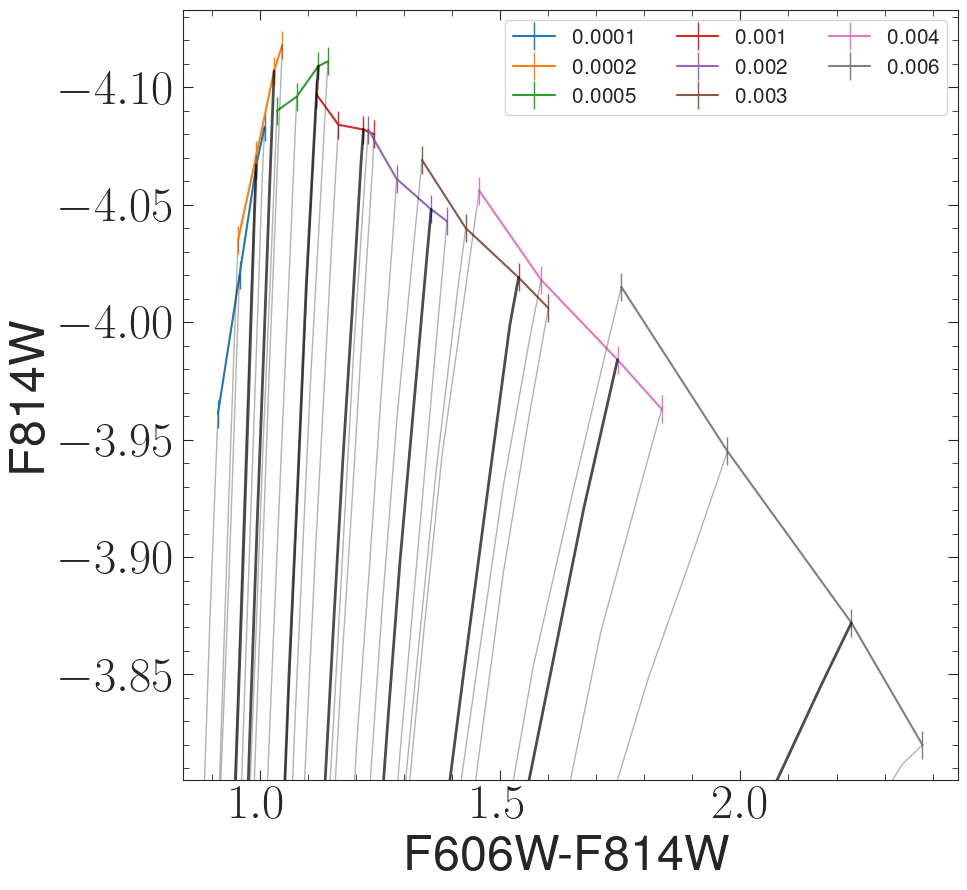

In [69]:
fig, ax = plt.subplots(figsize=(10,10))

ax.plot(col,m, '-|', markersize=20)

ax.xaxis.set_major_locator(AutoLocator())
ax.xaxis.set_minor_locator(AutoMinorLocator())

ax.yaxis.set_major_locator(AutoLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())

ax.tick_params(which='both', length=7,direction="in", bottom=True, top=True,left=True, right=True)
ax.tick_params(which='minor', length=4)
ax.invert_yaxis()

ax.legend([0.0001, 0.0002, 0.0005, 0.001 , 0.002 , 0.003 , 0.004 , 0.006],
         ncols=3, fontsize=15)
ax.set_xlabel(r'F606W-F814W')
ax.set_ylabel(r'F814W')

Av_ = 1
Av_x = 3
Av_y = -3.9

AF1_ =  Av_dict['f606w']*Av_
AF2_ =  Av_dict['f814w']*Av_
AF3_ =  Av_dict['f814w']*Av_

dx = AF1_ - AF2_
dy = AF3_

ax.annotate('', xy=(Av_x, Av_y),
             xycoords='data',
             xytext=(Av_x+dx, Av_y+dy),
             textcoords='data',
             arrowprops=dict(arrowstyle= '<|-',
                             color='black',
                             lw=2,
                             ls='-')
           )

ax.annotate(f'Av = {Av_}', xy=(Av_x-0.01, Av_y-0.01),fontsize=20)

ax.set_ylim(ax.get_ylim()[0], ax.get_ylim()[1])
ax.set_xlim(ax.get_xlim()[0], ax.get_xlim()[1])

for i in [9.6,9.8,10,10.1000]:
    df = df_cmd_acs[np.round(df_cmd_acs['logAge'],3)==i]
    df = df[df['label']==3]
    ms = []
    cols = []
    for j in [0.0001, 0.0002, 0.0005, 0.001 , 0.002 , 0.003 , 0.004 , 0.006]:
        df_ = df[df['Zini']==j]
        x = df_['F606Wmag'] - df_['F814Wmag']
        y = df_['F814Wmag']
        
        mask = (y.values[1:]- y.values[:-1])<0.5
        mask = np.array([True] + list(mask))
        mask = np.where(~mask, np.nan, 1)
        
        if i ==10:
            lw = 2
            alpha=0.7
        else:
            lw =1
            alpha=0.3
        ax.plot(x,y*mask, color='black',alpha=alpha,lw=lw)
    

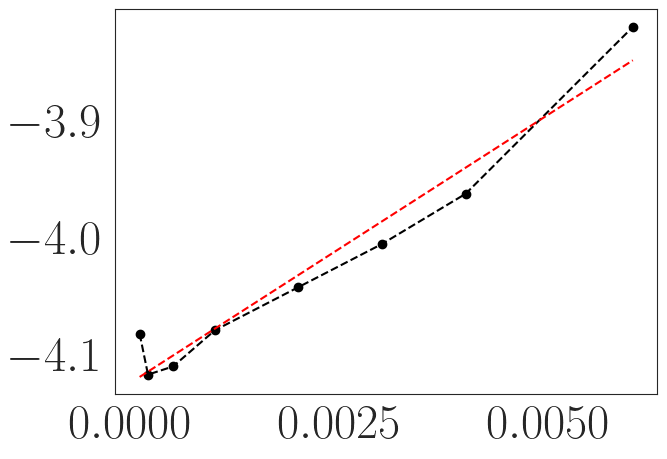

In [84]:
x = np.array([0.0001, 0.0002, 0.0005, 0.001 , 0.002 , 0.003 , 0.004 , 0.006])
y = m[3]

init = models.Linear1D()
fit = fitting.LinearLSQFitter()
model = fit(init, x, y)
plt.plot(x,y, '--ok')
plt.plot(x,model(x),'--r')

In [85]:
np.round(y.max()-y.min(),3)

0.298

In [169]:
grad_y = np.gradient(y,x)
np.round(grad_y*0.001,3)

array([-0.35 , -0.257,  0.038,  0.054,  0.037,  0.04 ,  0.052,  0.092,
        0.122,  0.131])

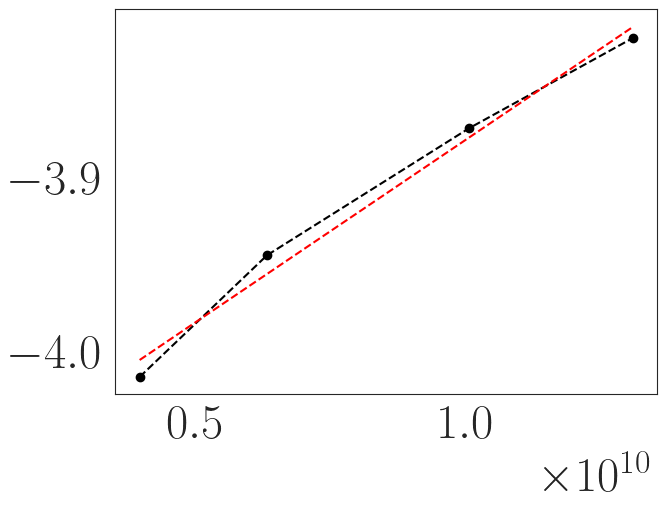

In [90]:
x = 10**np.array([9.6,9.8,10,10.1139])
y = m[:,-1]
init = models.Linear1D()
fit = fitting.LinearLSQFitter()
model = fit(init, x, y)
plt.plot(x,y, '--ok')
plt.plot(x,model(x),'--r')

In [98]:
np.round(y.max()-y.min(),3)

0.195

In [55]:
np.round(model.parameters[0]*1e9,3)

0.057

In [ ]:
if not os.path.exists('../data/isochrones/HST_ACS'):
    os.mkdir('../data/isochrones/HST_ACS/')
else:
    os.system('rm ../data/isochrones/HST_ACS/*')
l = 1    
for i, age in enumerate([ 6.,  6.1, 6.2, 6.3, 6.4, 6.5, 6.6, 6.7, 6.8 , 6.9, 7., 7.1, 7.2, 7.3, 7.4, 7.5, 7.6, 7.7,
                          7.8, 7.9, 8.0, 8.1, 8.2]):
    
    if len(str(i+1))==1:
        i = '0' + str(i+1)
    else:
        i =  str(i+1)
    for met in [0.02]:
        
        temp = df_cmd_acs[df_cmd_acs['logAge']==age]
        temp = temp[temp['Zini']==met]
        
        # Interpolation using F115W-F200W vs F200W
        
        x = temp['F435Wmag'].values - temp['F814Wmag'].values 
        y = temp['F814Wmag'].values
        
        diff = np.array([0] + list(np.sqrt((x[1:]-x[:-1])**2 + (y[1:]-y[:-1])**2)))
        dist = []
        for i in range(len(diff)):
            dist.append(diff[:i+1].sum())
            
        temp['dist'] = dist
        temp = temp.sort_values('dist')
        
        x = temp['dist']
        x_new = np.arange(x.min(), x.max(),0.01)

        label = np.interp(x_new, x, temp['label'])
        Mini = np.interp(x_new, x, temp['Mini'])
        f435w = np.interp(x_new, x, temp['F435Wmag'])
        f555w = np.interp(x_new, x, temp['F555Wmag'])
        f814w = np.interp(x_new, x, temp['F814Wmag'])

        temp_interp = pd.DataFrame(zip(label, Mini, f435w, f555w, f814w), columns = ['label','Mini','F435Wmag', 'F555Wmag', 'F814Wmag'])
        temp_interp['Zini'] = temp['Zini'].max()
        temp_interp['logAge'] = temp['logAge'].max()
        temp = temp_interp
        
        temp = temp[['label', 'Mini', 'F435Wmag', 'F555Wmag', 'F814Wmag', 'Zini', 'logAge']]
        header = list(temp.keys())
        header[0] = '#' + header[0]
            
        if l<10:       
            temp.to_csv(f'../data/isochrones/HST_ACS/0{l}_PARSEC1.1_Z0.020_logAGE{age}Myr_HST_BVI.isoc',sep=' ',
                       index=None, header = header)
        else:
            temp.to_csv(f'../data/isochrones/HST_ACS/{l}_PARSEC1.1_Z0.020_logAGE{age}Myr_HST_BVI.isoc',sep=' ',
                       index=None, header = header)
        l+=1

In [ ]:
temp

#### **WFC3/UVIS**

In [26]:
with open("../data/isochrones_master/cmd_hst_uvis_n.dat") as f:
    dat = f.readlines()

data = []

for i,d in enumerate(dat[13:-1]):
    if 'Zini' not in d:
        data.append([float(i) for i in d.split()])
        
df_cmd_uvis = pd.DataFrame(data,columns=dat[13][2:].split())[:-1]
df_cmd_uvis.to_csv("../data/isochrones_master/cmd_hst_uvis.csv")
#df_cmd_uvis = df_cmd_uvis[df_cmd_uvis['MH']==0.51508]
#df_cmd_uvis = df_cmd_uvis[(df_cmd_uvis['label']>-1) & (df_cmd_uvis['label']<7)]

In [27]:
df_cmd_uvis = pd.read_csv("../data/isochrones_master/cmd_hst_uvis.csv")

In [ ]:
ages = np.round(np.arange(6.0,8.1,0.1),1)

mag_err_lim = 0.2

In [ ]:
if not os.path.exists('../data/isochrones/HST_UVIS'):
    os.mkdir('../data/isochrones/HST_UVIS/')
else:
    os.system('rm ../data/isochrones/HST_UVIS/*')
    
for i, age in enumerate(ages):
    temp = df_cmd_uvis[df_cmd_uvis['logAge']==age]
    if len(str(i+1))==1:
        i = '0' + str(i+1)
    else:
        i =  str(i+1)
    
    temp = temp[['label', 'Mini', 'F275Wmag', 'F336Wmag', 'Zini', 'logAge']]
    temp =  temp[temp['Mini']>=2]
    header = list(temp.keys())
    header[0] = '#' + header[0]
        
    temp.to_csv(f'../data/isochrones/HST_UVIS/{i}_PARSEC1.1_Z0.015_logAGE{age}Myr_HST_UVIS.isoc',sep=' ',
               index=None, header = header)

### **CMD**

In [38]:
np.round(9.9545,4)

9.9545

In [36]:
10**9.9545/1e9

9.005337627506472

In [39]:
ages_ = [9.9545]

In [74]:
a = []
for i in df_cmd_uvis['Zini']:
    if i in [0.0001,0.0004,0.001]:
        a.append(True)
    else:
        a.append(False)

In [75]:
df_cmd = df_cmd_uvis[a]

/tmp/ipykernel_2645/1483801798.py:251: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


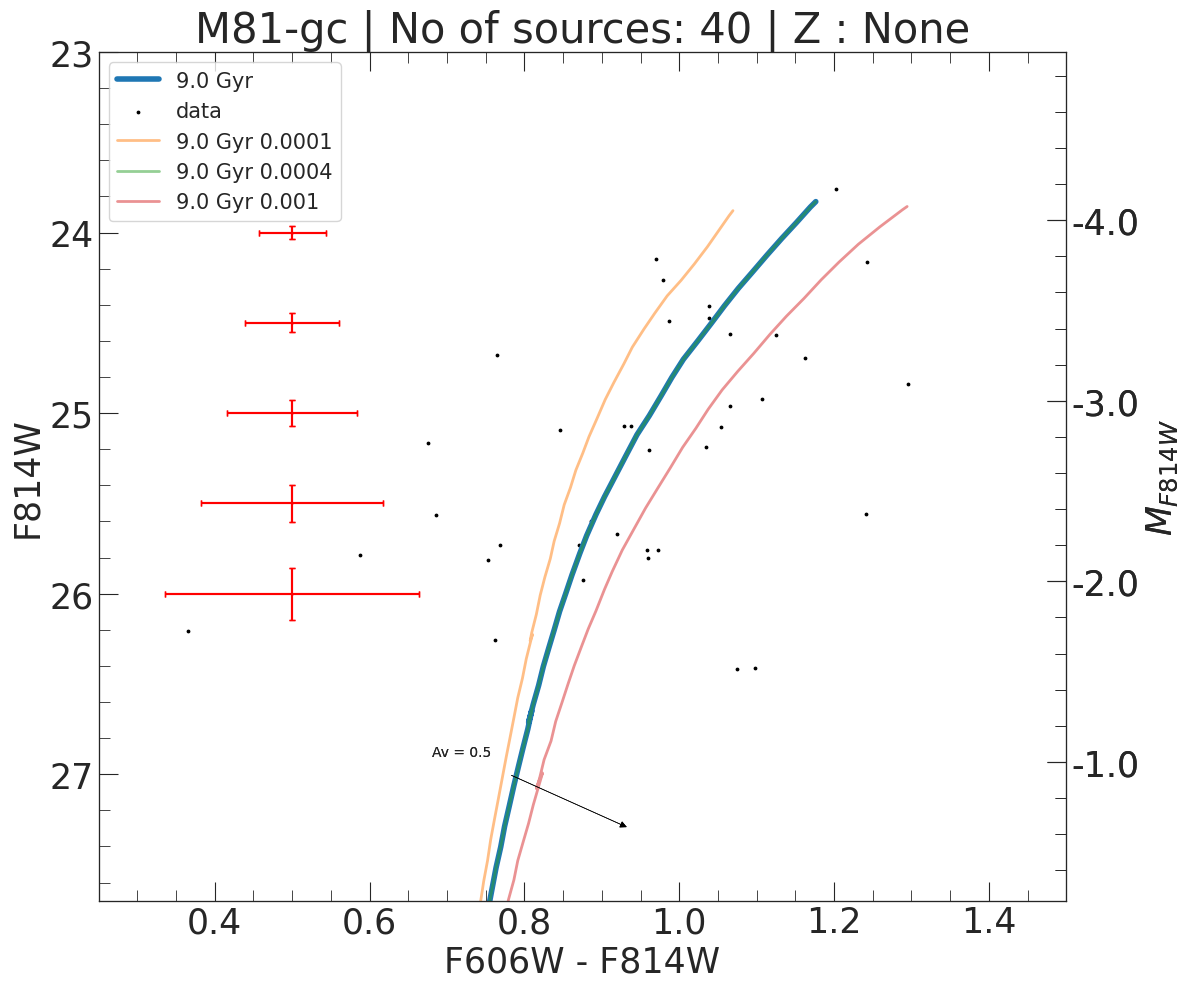

In [90]:
r_in = 0.3
r_out = 10

fig, ax, tab = gen_CMD('f606w','f814w','f814w', name = '606_814_main',cmd=df_cmd, out_dir='../HST/data/photometry/m81-gc', Av = 0.220,
                 Av_=0.5, xlims=[0.25,1.5], ylims=[23, 27.7], r_in=r_in,r_out=r_out, ref_xpos = 0.5, mag_err_lim=0.2,
                ra_col='ra_1', dec_col='dec_1', label = 3, met=0.0004, regions=['m81-gc'], ages=ages_, dismod=27.8,s=3, alpha=1, lw=4,
                  Av_x = 0.78, Av_y=27,skip_data=True,)
ax.get_legend().remove()
fig, ax, tab = gen_CMD('f606w','f814w','f814w', name = '606_814_main',cmd=df_cmd, out_dir='../HST/data/photometry/m81-gc', Av = 0.220,
                 Av_=0.5, xlims=[0.25,1.5], ylims=[23, 27.7], r_in=r_in,r_out=r_out, ref_xpos = 0.5, mag_err_lim=0.2, lw=2,
                ra_col='ra_1', dec_col='dec_1', label = 3, met=None, regions=['m81-gc'], ages=ages_, dismod=27.8,s=3,  alpha=0.5,
                  Av_x = 0.78, Av_y=27,fig=fig,ax=ax,)


In [ ]:
r_in = 0
r_out = 100

fig, ax, tab = gen_CMD('f606w','f814w','f814w', name = 'sim_gc',cmd=df_cmd_uvis, out_dir='../HST/data/sim', Av = 0.220,
                 Av_=0.5, xlims=[0,2.], ylims=[22, 28], r_in=r_in,r_out=r_out, ref_xpos = 0.25, mag_err_lim=0.5,
                ra_col='ra_1', dec_col='dec_1', ang=0,
                label = 9, met=0.0004, regions=['m81-gc'], ages=ages_, dismod=27.8,s=3,  alpha=0.5,
                  Av_x = 1.5, Av_y=27)

In [ ]:
x = tab['ra_1']
y = tab['dec_1']

plt.scatter(x,y,s=0.5, color='black')

In [ ]:
with open("../../HST/data/sim/9gyr.dat") as f:
    dat = f.readlines()

data = []

for i,d in enumerate(dat[14:]):
    if '#' not in d and 'terminated' not in d:
        data.append([float(i) for i in d.split()])

In [ ]:
df = pd.DataFrame(data,columns=dat[13][2:].split())
df = df.drop_duplicates(['Mini','age','label'])

In [ ]:
y, x = 10/3600*np.mgrid[-1000:1000,-1000:1000]/1000
p  = models.Sersic2D(r_eff=10/3600,n=2)(x,y)

In [ ]:
p/=p.sum()

In [ ]:
plt.imshow(np.log10(p),extent=[x.min()*3600,x.max()*3600,
                              y.min()*3600,y.max()*3600])

In [ ]:
flat = p.flatten()
sample_index = np.random.choice(a=flat.size,size=len(df), p=flat)

In [ ]:
adjusted_index = np.unravel_index(sample_index, p.shape)

In [ ]:
ra = x[adjusted_index] + 149.47781
dec = y[adjusted_index] + 68.816955

In [ ]:
ra_plot = (ra - 149.47781)*3600
dec_plot = (dec -68.816955)*3600
plt.scatter(ra_plot,dec_plot,s=0.0001, color='black')
plt.xlim(-0.3,0.3)

plt.ylim(-0.3,0.3)
plt.axis('equal')

In [ ]:
df['ra_1'] = ra
df['dec_1']= dec

In [ ]:
df = df.rename(columns={'F606Wmag':'mag_vega_F606W',
               'F814Wmag' : 'mag_vega_F814W'})

In [ ]:
df['mag_vega_F606W'] = df['mag_vega_F606W'] + 27.8 + Av_dict['f606w']*0.22
df['mag_vega_F814W'] = df['mag_vega_F814W'] + 27.8 + Av_dict['f814w']*0.22                                                                                                            

In [ ]:
df['mag_err_1'] = model_606(df['mag_vega_F606W'])
df['mag_err_2'] = model_814(df['mag_vega_F814W'])

In [ ]:
df['mag_err_1'].min()

In [ ]:
tab_sim = Table.from_pandas(df[['ra_1','dec_1','mag_vega_F606W', 'mag_err_1', 'mag_vega_F814W','mag_err_2']])

In [ ]:
tab_sim.write('../../HST/data/sim/sim_gc.fits', overwrite=True)

In [ ]:
((tab_sim['ra_1']-149.47781)*3600).mean()

In [ ]:
x = tab['mag_vega_F606W'].value
y = tab['mag_err_1'].value

init = models.Exponential1D()
fit = fitting.LevMarLSQFitter()

model_606 = fit(init,x,y)

plt.scatter(x, y,marker='.', color='black')

y = np.linspace(0,0.2)
x_606 = lambda y: model_606.parameters[1]*np.log(y/model_606.parameters[0])

plt.plot(x_606(y),y,'--r')

x = tab['mag_vega_F814W']
y = tab['mag_err_2']

init = models.Exponential1D()
fit = fitting.LevMarLSQFitter()
model_814 = fit(init,x,y)

plt.scatter(x, y,marker='.', color='red')

y = np.linspace(0,0.2)
x_814 = lambda y: model_814.parameters[1]*np.log(y/model_814.parameters[0])

plt.plot(x_814(y),y,'--g')

In [ ]:
tab0 = Table.read('../../HST/data/photometry/m81-gc/606_814_main.fits')
tab1 = Table.read('../../HST/data/photometry/m81-gc/606_814_1not2.fits')
tab2 = Table.read('../../HST/data/photometry/m81-gc/606_814_2not1.fits')

In [ ]:
err = 0.2
tab1 = tab1[(tab1['mag_vega_F606W']<=x_606(err))
                &  (tab1['mag_err']<=err)]

tab2 = tab2[(tab2['mag_vega_F814W']<=x_814(err)) 
                 & (tab2['mag_err']<=err)]

In [ ]:
tab1['mag_vega_F814W'] = x_814(err)
tab1['mag_err_1'] = tab1['mag_err']
tab1['mag_err_2'] = err

tab2['mag_vega_F606W'] = x_606(err)
tab2['mag_err_1'] = err
tab2['mag_err_2'] = tab2['mag_err']

In [ ]:
tab1.rename_columns(['ra','dec'], ['ra_1','dec_1'])
tab2.rename_columns(['ra','dec'], ['ra_1','dec_1'])

In [ ]:
tab_n = tab0[['ra_1','dec_1','mag_vega_F606W','mag_err_1',
             'mag_vega_F814W', 'mag_err_2']]

tab_n['flag'] = 'both'

In [ ]:
tab1 = tab1[['ra_1','dec_1','mag_vega_F606W','mag_err_1',
             'mag_vega_F814W', 'mag_err_2']]

tab1['flag'] = '606'

tab2 = tab2[['ra_1','dec_1','mag_vega_F606W','mag_err_1',
             'mag_vega_F814W', 'mag_err_2']]

tab2['flag'] = '814'

In [ ]:
tab_tot = vstack([tab_n, tab1, tab2])

In [ ]:
tab_tot

In [ ]:
x = tab_tot['ra_1']
y = tab_tot['dec_1']

plt.scatter(x,y)

In [ ]:
tab_tot.write('../../HST/data/photometry/m81-gc/606_814_comb.fits',
          overwrite=True)

In [ ]:
r_in = 0.5
r_out = 3

fig, ax, tab = gen_CMD('f606w','f814w','f814w',name = '606_814_final',cmd=df_cmd_uvis, out_dir='../HST/data/photometry/m81-gc', Av = 0.220,
                 Av_=0.5, xlims=[-2,2], ylims=[22,30], r_in=r_in,r_out=r_out, ref_xpos = -1.5, mag_err_lim=0.2,
                label = 3, met=0.0004, regions=['m81-gc'], ages=ages_, dismod=27.8,s=2,  alpha=0.3,
                  Av_x = 1.5, Av_y=27)

In [ ]:
x = tab['mag_vega_F606W']
y = np.sqrt(tab['mag_err_1']**2 + tab['mag_err_2']**2)

plt.scatter(x,y)

In [ ]:
r_in = 0
r_out = 500

fig, ax, tab = gen_CMD('f435w','f555w', name = 'f435w_f555w',cmd=df_cmd_acs, out_dir='photometry/ngc628',
                 Av_=0.5, xlims=[-2,3], ylims=[20,28], r_in=r_in,r_out=r_out, ref_xpos = -1.5,
                label = 9, met=0.02, regions=['filament'], ages=ages_, dismod=29.75,
                  Av_x = 2, Av_y=27)

In [ ]:
r_in = 0
r_out = 500

fig, ax, tab = gen_CMD('f555w','f814w', name = 'f555w_f814w',cmd=df_cmd_acs, out_dir='photometry/ngc628',
                 Av_=0.5, xlims=[-2,6], ylims=[20,28], r_in=r_in,r_out=r_out, ref_xpos = -1.5,
                label = 3, met=0.02, regions=['bubble'], ages=[9.0,9.4,9.8,10,10.1], dismod=29.75, gen_kde=True,
                  Av_x = 2, Av_y=27)

In [ ]:
r_in = 0
r_out = 12

fig, ax = plt.subplots(1,2, sharey=False,figsize=(24,10))

filt1 = 'f435w'

filt2 = 'f814w'

filt3 = 'f814w'

fig,ax1, tab = gen_CMD(filt1, filt2,filt3, name = 'ngc628/f435w_f814w',
                       cmd=None, Av_=1, Av_x=4, Av_y=26, xlims=[-1,6], ylims=[19,28],
                     out_dir='photometry',gen_kde=True,gen_contours=False, label=10, met=0.02,
                    dismod=29.8, ages=ages_, sqr_field=False, r_in=r_in, r_out=r_out, regions=['bubble'],
                    fig=fig,ax=ax[0],ref_xpos=-0.5)

fig,ax2, tab = gen_CMD(filt1, filt2,filt3, name = 'ngc628/f435w_f814w',
                       cmd=None, r=None, Av_=1, Av_x=4, Av_y=26, xlims=[-1,6], ylims=[19,28],
                 out_dir='photometry',gen_kde=False, label=10, met=0.02,dismod=29.95, ages=ages_,
                 r_in=r_in, r_out=r_out, fig=fig,ax=ax[1],ref_xpos=-0.5, alpha=0.5, s=0.5,
                regions=['bubble'])


In [ ]:
r_in = 0
r_out = 500

fig,ax1, tab = gen_CMD('f435w', 'f814w', 'f814w',name = 'ngc628/f435w_f814w',
                       cmd=df_cmd_acs, r=None, Av_=1, Av_x=1.5, Av_y=27, xlims=[-0.5,6], ylims=[17,30],
                 out_dir='photometry',gen_kde=True, label_min=0, label_max=10, met=None,dismod=30.04, ages=[8],
                 r_in=r_in, r_out=r_out,regions=['galaxy'])
#ax1.set_title('')
#ax1.get_legend().remove() 

In [ ]:
x = tab['mag_vega_F814W']
y = tab['mag_err_2']

fig, ax = plt.subplots()

ax.scatter(x,y,s=0.05, color='black')

ax.set_xlabel('F814W (vega)')
ax.set_ylabel('mag_err')

ax.xaxis.set_major_locator(AutoLocator())
ax.xaxis.set_minor_locator(AutoMinorLocator())

ax.yaxis.set_major_locator(AutoLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())

ax.tick_params(which='both', length=7,direction="in", bottom=True, top=True,left=True, right=True)
ax.tick_params(which='minor', length=4)

In [ ]:
x = tab['ra_1']
y = tab['dec_1']

plt.scatter(x,y, s=0.1)

In [ ]:
r_in = 0
r_out = 10

fig, ax, tab = gen_CMD('f435w','f814w', name = 'f435w_f814w',cmd=df_cmd_acs, out_dir='photometry/ngc628',
                 Av_=0.5, xlims=[-2,6], ylims=[18,28], r_in=r_in,r_out=r_out, ref_xpos = -1.5,
                label = 3, met=0.02, regions=['bubble'], ages=ages_, dismod=29.8,
                  Av_x = 2, Av_y=27)

In [ ]:
ages_ = np.round(np.log10([4e6, 7e6, 1e7, 2e7, 3e7, 5e7]),1)

In [ ]:
ages_

In [ ]:
age_lin = []
for i in ages_:
    if i > 6  and i <9:
        i-=6
        age_lin.append(f'{np.ceil(10**i)} Myr')
    elif i >= 9:
        i-=9
        age_lin.append(f'{np.ceil(10**i)} Gyr')
        

In [ ]:
fig, ax = gen_CMD('f275w','f336w', cmd=df_cmd_uvis, out_dir='PHOT_OUTPUT_r25',
                 Av_=0.5, xlims=[-3,5], ylims=[18,28], r=10/0.04, met=0.008,label=9, ref_xpos=-2,
                 x_cen=631/2, y_cen=631/2, regions=['bubble','bkg3'], Av_x=4, Av_y=24,
                 flag=111)

### **Extinction Vector**

In [ ]:
df_cmd_hst['Zini']

## **JWST-HST**

In [ ]:
df_cmd_hst_jwst = pd.read_csv('../data/isochrones_master/cmd_jwst_hst.csv')

In [ ]:
ages = np.round(np.arange(6.0,8.5,0.1),1)

In [ ]:
if not os.path.exists('../data/isochrones/HST_JWST'):
    os.mkdir('../data/isochrones/HST_JWST/')
else:
    os.system('rm ../data/isochrones/HST_JWST/*')
    
for i, age in enumerate(ages):
    temp = df_cmd_hst_jwst[df_cmd_hst_jwst['logAge_1']==age]
    if len(str(i+1))==1:
        i = '0' + str(i+1)
    else:
        i =  str(i+1)
    
    temp = temp[['label_1', 'Mass_1', 'F435Wmag', 'F555Wmag', 'F814Wmag', 'F115Wmag', 'F150Wmag', 'F200Wmag', 'Zini_1', 'logAge_1']]
    header = list(temp.keys())
    header[0] = '#' + header[0]
        
    temp.to_csv(f'../data/isochrones/HST_JWST/{i}_PARSEC1.1_Z0.02_logAGE{age}Myr_JWST_JHK.isoc',sep=' ',
               index=None, header = header)


In [ ]:
r_in = 0
r_out = 10

fig,ax = gen_CMD('f200w', 'f555w', name='f115w_f150w_f200w_f435w_f555w_f814w',
                 cmd=df_cmd_hst_jwst, r=None, ra_col='ra_1_1', dec_col='dec_1_1',
                 Av_=3, Av_x=2.5, Av_y=26, xlims=[-7,5], ylims=[18,30],
                 out_dir='PHOT_OUTPUT_r25',gen_kde=False, label=9, met=0.02,
                 r_in=r_in, r_out=r_out,
                regions=['bubble'])

In [ ]:
ages_ = np.round(np.log10([6e6, 1e7,2e7, 3e7, 5e7,1e8,5e8]),1)

In [ ]:
r_in = 0
r_out = 7

for i in range(17, 22):
    fig, ax = plt.subplots(1,2, sharey=False,figsize=(22,10))
    try:
        fig,ax1, tab = gen_CMD('f435w', 'f555w',name='ngc628/f435w_f555w', cmd=df_cmd_acs, r=None, Av_=1, Av_x=2.5, Av_y=26, xlims=[-2,3], ylims=[20,29],
                         out_dir='photometry',gen_kde=False, label=10, met=0.02,dismod=29.7418, ages=[6,7,7.6,7.8,8], alpha=0.5,
                         r_in=r_in, r_out=regions_dict[f'bubble_{i}']['radius'], fig=fig,ax=ax[0], ref_xpos=-1, s=1,
                        regions=[f'bubble_{i}'])
        
    except:
        pass
    fig,ax2, tab_ = gen_CMD('f115w', 'f200w',name='ngc628/f115w_f200w', cmd=df_cmd_jwst, r=None, Av_=1, Av_x=2.5, Av_y=26, xlims=[-0.5,4], ylims=[17,28],
                     out_dir='photometry',gen_kde=False, label=10, met=0.02,dismod=29.7418, ages=[6.8,7,7.6,7.8,8], alpha=0.5,
                     r_in=r_in, r_out=regions_dict[f'bubble_{i}']['radius'], fig=fig,ax=ax[1], s=1,
                    regions=[f'bubble_{i}'])

    fig,ax2, tab_ = gen_CMD('f115w', 'f200w',name='ngc628/f115w_f200w', cmd=df_cmd_jwst, r=None, Av_=1, Av_x=2.5, Av_y=26, xlims=[-0.5,4], ylims=[17,28],
                 out_dir='photometry',gen_kde=False, label=10, met=0.003,dismod=29.7418, ages=[10], alpha=0.9,
                 r_in=r_in, r_out=regions_dict[f'bubble_{i}']['radius'], fig=fig,ax=ax[1], skip_data=True, s=1,
                regions=[f'bubble_{i}'])
    ax2.annotate(f"""Bubble radius: {regions_dict[f'bubble_{i}']['radius']}" """,(0,18), fontsize=20)
    fig.savefig(f'../data/cmds/bubbles/bubble_{i}.png')
    break
    plt.close(fig,)

In [ ]:
ax2.legend().get_texts()[6].set_text('10.0 Gyr (Z=0.003)')

In [ ]:
r_in = 0
r_out = 7

i = 16
fig, ax = plt.subplots(1,2, sharey=False,figsize=(22,10))

fig,ax1, tab1 = gen_CMD('f435w', 'f555w',name='ngc628/f435w_f555w', cmd=df_cmd_acs, r=None, Av_=1, Av_x=2.5, Av_y=26, xlims=[-1,6], ylims=[20,29],
                 out_dir='photometry',gen_kde=False, label=10, met=0.02,dismod=29.75, ages=ages_, alpha=0.5,
                 r_in=r_in, r_out=regions_dict[f'bubble_{i}']['radius'], fig=fig,ax=ax[0],
                regions=[f'bubble_{i}'])

fig,ax2, tab1_ = gen_CMD('f115w', 'f200w',name='ngc628/f115w_f200w', cmd=df_cmd_jwst, r=None, Av_=1, Av_x=2.5, Av_y=26, xlims=[-0.5,4], ylims=[17,28],
                 out_dir='photometry',gen_kde=False, label=10, met=0.02,dismod=29.75, ages=ages_, alpha=0.5,
                 r_in=r_in, r_out=regions_dict[f'bubble_{i}']['radius'], fig=fig,ax=ax[1],
                regions=[f'bubble_{i}'])
ax2.annotate(f"""Bubble radius: {regions_dict[f'bubble_{i}']['radius']}" """,(0,18), fontsize=20)

r_in = 1.6
r_out = 7

fig,ax1, tab2 = gen_CMD('f435w', 'f555w',name='ngc628/f435w_f555w', cmd=df_cmd_acs, r=None, Av_=1, Av_x=2.5, Av_y=26, xlims=[-1,6], ylims=[20,29],
                 out_dir='photometry',gen_kde=False, label=10, met=0.02,dismod=29.75, ages=ages_, alpha=0.5, s=5,
                 r_in=r_in, r_out=regions_dict[f'bubble_{i}']['radius'], fig=fig,ax=ax[0],
                regions=[f'bubble_{i}'])

fig,ax2, tab2_ = gen_CMD('f115w', 'f200w',name='ngc628/f115w_f200w', cmd=df_cmd_jwst, r=None, Av_=1, Av_x=2.5, Av_y=26, xlims=[-0.5,4], ylims=[17,28],
                 out_dir='photometry',gen_kde=False, label=10, met=0.02,dismod=29.75, ages=ages_, alpha=0.5, s=5,
                 r_in=r_in, r_out=regions_dict[f'bubble_{i}']['radius'], fig=fig,ax=ax[1],
                regions=[f'bubble_{i}'])
ax2.annotate(f"""Bubble radius: {regions_dict[f'bubble_{i}']['radius']}" """,(0,18), fontsize=20)


In [ ]:
x = tab['ra_1']
y = tab['dec_1']

fig, ax = plt.subplots()

ax.scatter(x,y)

ax.invert_xaxis()
ax.axis('equal')

## **SED**

In [ ]:
df_sed_bub = Table.read("../data/f275_f336w_f435w_f336w_f115w_f150w_f200w_bub.fits")
df_sed_bkg = Table.read("../data/f275_f336w_f435w_f336w_f115w_f150w_f200w_bkg.fits")

In [ ]:
len(df_sed_bub), len(df_sed_bkg)

In [ ]:
filts = [i.upper() for i in list(Av_dict.keys())]
filts_wav = [2709.7, 3354.5, 4322.0, 5368.0, 8146.9, 11490, 14970, 19680]
Avs = np.array(list(Av_dict.values()))

In [ ]:
m = 21
dm = 0.5

df_filt1 = df_sed_bub[(df_sed_bub['mag_vega_F115W']>= m) 
                      & (df_sed_bub['mag_vega_F115W']<= m + dm)]

df_filt2 = df_sed_bkg[(df_sed_bkg['mag_vega_F115W']>= m) 
                      & (df_sed_bkg['mag_vega_F115W']<= m + dm)]

fig, ax = plt.subplots(figsize=(15,8))

for i in range(len(df_filt1)):

    y = df_filt1[i:i+1]['mag_vega_F275W', 'mag_vega_F336W', 'mag_vega_F435W', 'mag_vega_F555W', 'mag_vega_F814W',
                'mag_vega_F115W', 'mag_vega_F150W', 'mag_vega_F200W'].to_pandas().values[0]

    ax.plot(filts_wav,y,'-ob')
 

for i in range(len(df_filt2)):

    y = df_filt2[i:i+1]['mag_vega_F275W', 'mag_vega_F336W', 'mag_vega_F435W', 'mag_vega_F555W', 'mag_vega_F814W',
                'mag_vega_F115W', 'mag_vega_F150W', 'mag_vega_F200W'].to_pandas().values[0]

    #ax.plot(filts_wav,y,'-or')
    
ax.xaxis.set_major_locator(AutoLocator())
ax.xaxis.set_minor_locator(AutoMinorLocator())

ax.yaxis.set_major_locator(AutoLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())

ax.tick_params(which='both', length=10,direction="in", bottom=True, top=True,left=True, right=True)
ax.tick_params(which='minor', length=4);
ax.set_xticks(filts_wav, labels=filts, rotation=45, fontsize = 15)
ax.invert_yaxis();

## **CMD gradient**

In [ ]:
rs = [0,5/0.031]

area = np.pi*(rs[-1]**2 - rs[-2]**2)

while 1:
    r = np.sqrt(area/np.pi + rs[-1]**2)
    if r < 797/2:
        rs.append(r)
    else:
        break
    
rs = np.array(rs)

In [ ]:
rs

In [ ]:
rs[1:]**2 - rs[:-1]**2

In [ ]:
x_cen = 797/2
y_cen = 797/2

In [ ]:
plt.figure(figsize=(7, 10))

ax1 = plt.subplot(1, 1, 1,projection=cutout_n.wcs)

ax1.set_title(filt_n, fontdict=font2)
norm = simple_norm(cutout_n.data, 'sqrt',percent=99.)

img = ax1.imshow(cutout_n.data, norm = norm, cmap='gray')

levels = [13.2,15]

smooth_data = gaussian_filter(cutout_m.data, 2)
cmap = ListedColormap(['yellow','cyan'])
ax1.contour(smooth_data, levels=levels, cmap=cmap, transform=ax1.get_transform(cutout_m.wcs))
#ax1.grid(color='red')


for r in rs:
    circle = Circle((x_cen, y_cen), r, fill=False,  color='black')
    ax1.add_patch(circle)
 
circle = Circle((x_cen, y_cen), 200, fill=False,  color='red')
ax1.add_patch(circle)

circle = Circle((x_cen, y_cen), 282.843, fill=False,  color='red')
ax1.add_patch(circle)

circle = Circle((x_cen, y_cen), rs.max(), fill=False,  color='red')
ax1.add_patch(circle)
    
cb = plt.colorbar(img, orientation='horizontal', anchor = (0.5, 1.1))
cb.set_label(f"{imh_m['BUNIT']}")

In [ ]:
mag_err_lim = 0.1

In [ ]:
age_lin = []
for i in ages_:
    if i > 6  and i <9:
        i-=6
        age_lin.append(f'{np.round(10**i,2)} Myr')
    elif i >= 9:
        i-=9
        age_lin.append(f'{np.round(10**i,2)} Gyr')   

In [ ]:
for i in range(len(rs)-1):
    fig,ax = gen_CMD('f115w', 'f150w', r_in=rs[i],r_out=rs[i+1],
                     cmd=None, flag=111, gen_kde=False, add_ref=True,
                     x_cen=797/2, y_cen=797/2, out_dir='PHOT_OUTPUT_r25')
    fig.suptitle(f"R = {np.round(rs[i],1)}-{np.round(rs[i+1],1)}", fontsize=20)
    plt.show()

## **Simulate Stars using PISTA**

In [ ]:
region, filt_n

In [ ]:
filt_n = 'F435W'

In [ ]:
if not os.path.exists(f"../PHOT_OUTPUT_m50/{region}/{filt_n}"):
    os.mkdir(f"../PHOT_OUTPUT_m50/{region}/{filt_n}")

In [ ]:
hdu = fits.open(f"../PHOT_OUTPUT_AUTO/{region}/{filt_n}/data_conv.fits")[1]

In [ ]:
data_source = hdu.data
pixel_scale = hdu.header['CDELT1']*3600

In [ ]:
norm = simple_norm(data_source, 'sqrt', percent=99.)
plt.imshow(data_source, cmap='jet', norm=norm)

In [ ]:
phot_table = Table.read(f"../PHOT_OUTPUT_AUTO/{region}/{filt_n}/{filt_n}_photometry_filt.fits")

In [ ]:
psf = np.median(fits.open(f'../data/PSF/epsf/{filt_n}/snap_test_psf.fits')[0].data, axis=(1,0))
psf = psf.reshape(51,5,51,5).sum(axis=(1,3))
#psf = np.where(psf>=0,psf,0)
#psf -= psf.min()
psf /= psf.sum()

In [ ]:
hdu = fits.PrimaryHDU(psf)
hdul = fits.HDUList([hdu])
hdul.writeto('psf.fits', overwrite=True)

In [ ]:
data = psf
norm = simple_norm(data, 'log', percent=99.99, log_a=100)
img = plt.imshow(data, cmap='jet', norm=norm)
plt.colorbar(img)

In [ ]:
tel_params ={
            'aperture'       : 650,
            'pixel_scale'    : pixel_scale,
            'psf_file'       : f'psf.fits',
            'response_funcs' :  [ f'{data_path}/INSIST/UV/Coating.dat,5,100',   # 6 mirrors
                                ],
             'coeffs'        : 0.5 ,
             'theta'         : 0
            }

In [ ]:
df = phot_table[ (phot_table['SNR']<20) ][['ra', 'dec',f'mag_vega_{filt_n}', 'flux','flag_phot']].to_pandas()

In [ ]:
df = df[df['flag_phot']==1]

In [ ]:
zero_flux = (df['flux']/10**(-0.4*df[f'mag_vega_{filt_n}'])).mean()

In [ ]:
zp = 2.5*np.log10(zero_flux)

In [ ]:
zero_flux = 10**(0.4*(zp+0.5))

In [ ]:
df = df.rename(columns = {f'mag_vega_{filt_n}': 'mag'})

In [ ]:
sim = pt.Imager(df=df, tel_params=tel_params, exp_time=2000,
               n_x=data_source.shape[0], n_y=data_source.shape[1])

In [ ]:
det_params = {'shot_noise' :  'Poisson',
              'qe_response': [],
              'qe_mean'    : 1,
              'G1'         :  1,
              'bias'       : 10,
              'PRNU_frac'  :  0.25/100,
              'DCNU'       :  0.1/100,
              'RN'         :  3,
              'T'          :  218,
              'DN'         :  0.01/100
              }

In [ ]:
(sim.n_x_sim - sim.n_x)/2, sim.n_x_sim - (sim.n_x_sim - sim.n_x)/2

In [ ]:
sim.shot_noise=False

In [ ]:
sim(det_params=det_params)

In [ ]:
sim.digital.min()

In [ ]:
sim.show_image()

In [ ]:
x = np.random.uniform(100.0,sim.n_x_sim -100,3600)
y = np.random.uniform(100.0,sim.n_y_sim -100,3600)

mag = np.array(list(np.linspace(20,32,60))*60)
df_add  = pd.DataFrame(zip(x,y,mag), columns = ['x','y','mag'])

In [ ]:
sim.shot_noise = False

In [ ]:
out_img = sim.add_stars(data_source, zero_flux, df_add)

In [ ]:
norm = simple_norm(out_img, 'sqrt', percent=99.)
plt.imshow(out_img, cmap='jet', norm=norm)

In [ ]:
hdu = fits.open(f"../PHOT_OUTPUT_EPSF/{region}/{filt_n}/data_conv.fits")

In [ ]:
hdu[1].data = out_img
wcs = WCS(hdu[1].header)

In [ ]:
coords = np.array(wcs.array_index_to_world_values(y-49,x-49))

In [ ]:
df_add['x'] = x - 49
df_add['y'] = y - 49

In [ ]:
df_add['ra'] = coords[0,:]
df_add['dec'] = coords[1,:]

In [ ]:
df_add.to_csv(f"../PHOT_OUTPUT_m50/{region}/{filt_n}/add_stars.csv", index=None)

In [ ]:
hdu.writeto(f"../PHOT_OUTPUT_m50/{region}/{filt_n}/data_conv.fits", 
            overwrite=True)

## **Fitting Pritchet Function**

In [ ]:
@models.custom_model
def pritchet(m,alpha=0.5,m_50=30):
    return 0.5*(1 - alpha*(m - m_50)/np.sqrt(1 + alpha**2*(m-m_50)**2))

In [ ]:
df_match = pd.read_csv(f"../PHOT_OUTPUT_m50/{region}/{filt_n}/matched.csv")

In [ ]:
x = df_match['mag']
y = df_match[f'mag_vega_{filt_n}'] 
yerr = df_match['mag_err']

plt.figure(figsize=(5,5))
plt.errorbar(x, y, yerr, fmt='o', color = 'black', markersize=1, capsize=2)
plt.xlabel('Mag in')
plt.ylabel('Mag out')
plt.plot([25,30],[25,30],'--r')

In [ ]:
df_match = df_match[df_match['flag_phot']==1]
df_match = df_match[abs(df_match['mag'] - df_match[f'mag_vega_{filt_n}'])<2]

In [ ]:
x = df_match['mag']
y = df_match[f'mag_vega_{filt_n}']
yerr = df_match['mag_err']

plt.figure(figsize=(5,5))
plt.errorbar(x, y, yerr, fmt='o', color = 'black', markersize=1, capsize=2)
plt.plot([25,30],[25,30],'--r')

In [ ]:
x = np.array(df_match.groupby('mag').count().index)
y = np.array(df_match.groupby('mag').count()['x_1']/60)

y = y[np.where((x>22)&(x<30))[0]]
x = x[np.where((x>22)&(x<30))[0]]
init = pritchet()
fit = fitting.LevMarLSQFitter()
offset = y.max()
model = fit(init, x, y/offset)

fig, ax = plt.subplots(figsize=(9,7))
ax.scatter(x,y)

ax.plot(x, model(x)*offset, '--r')
ax.set_xlabel('mags')
ax.set_ylabel(r'$N_{out}/N_{in}$')
ax.set_title(f"{region} | {filt_n} | "+ r"$\alpha =$" + f" {np.round(model.alpha.value,2)}" + r" | $m_{50}=$" + f"{np.round(model.m_50.value,2)}")

ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())

ax.tick_params(which='both', width=2,direction="in", top = True,right = True,
               bottom = True, left = True)
ax.tick_params(which='major', length=7,direction="in")
ax.tick_params(which='minor', length=4, color='black',direction="in")
ax.set_ylim(0,1)

bkg2, F115W 25.59

In [ ]:
float(np.array(1))